In [3]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
print(torch.__version__)
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn

import networkx as nx
from torch_geometric.utils.convert import from_networkx

from numba import njit, prange
import time
import seaborn as sns

### for simulation below

import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import bernoulli
import pickle
from sklearn.model_selection import KFold

1.13.0+cu116


In [4]:
all_valids = []
data_ind = [i for i in range(1000)]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (train_ind, valid_ind) in enumerate(kf.split(data_ind)):
    all_valids += list(valid_ind)
    if i == (7 - 1):
#         pass
        break

In [5]:
train_ind[-10:]

array([989, 990, 991, 992, 994, 995, 996, 997, 998, 999])

In [29]:
train_ind[-10:]

array([989, 990, 991, 992, 994, 995, 996, 997, 998, 999])

In [26]:
set(list(all_valids)) == set(data_ind)

True

In [21]:
set(list(train_ind) + list(valid_ind)) == set(data_ind)

True

In [22]:
(list(train_ind) + list(valid_ind)) == (data_ind)

False

In [18]:
data_ind[-6:]

[994, 995, 996, 997, 998, 999]

In [19]:
(list(train_ind) + list(valid_ind))[-6:]

[938, 947, 973, 974, 986, 998]

In [5]:

import numpy as np
kf = KFold(n_splits=10)
x = np.array([i for i in range(100)])
for i, (train_index, test_index) in enumerate(kf.split(x)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
  Test:  index=[0 1 2 3 4 5 6 7 8 9]
Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
  Test:  index=[10 11 12 13 14 15 16 17 18 19]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
  Test:  index=[20 21 

In [2]:
sklearn.__version__

'0.24.2'

In [7]:
with open('pr_spl_fwd_test.fa', 'r') as f:
    total = []
    for i, line in enumerate(f):
        if i != 0:
            total.append(line[:-1])
            
with open('pr_spl_fwd_test_mod.fa', 'w') as f:
    total_line = ''.join(total)
    print(len(total_line))
    for i in range(0, len(total_line), 2000):
        f.write(total_line[i:i+16000] + '\n')
        

579100


In [ ]:
99. // 5

# CR

In [2]:
df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
df

node_id1   node_id2 label_id1 label_id2   ibd_sum  ibd_n
0         node_0     node_5  мордвины  мордвины  29.81720      4
1         node_0    node_10  мордвины  мордвины  11.63220      1
2         node_0    node_11  мордвины  мордвины  23.90440      2
3         node_0    node_18  мордвины  мордвины  11.25290      1
4         node_0    node_20  мордвины  мордвины   8.88252      1
...          ...        ...       ...       ...       ...    ...
67498  node_3741  node_3752  белорусы  белорусы   9.51327      1
67499  node_3745  node_3755  белорусы  белорусы   9.23221      1
67500  node_3749  node_3764  белорусы  белорусы  10.63310      1
67501  node_3754  node_3755  украинцы  белорусы   8.04722      1
67502  node_3758  node_3766  белорусы  белорусы   8.77936      1

[67503 rows x 6 columns]

In [58]:
num = len(pd.concat([df['node_id1'], df['node_id2']], axis=0).unique())
num

3767

## Compute stats

In [81]:
df = pd.read_csv(r"C:\HSE\genotek\NC_graph_rel.csv")
df_selected = df[['node_id1', 'node_id2']]
df_selected.iloc[:, 0] = df_selected.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
df_selected.iloc[:, 1] = df_selected.iloc[:, 1].apply(lambda n: int(n.split('_')[1]))

df_selected.to_csv('NC_edge_list.edges', index=False, header=False)

C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [82]:
G = nx.read_edgelist('NC_edge_list.edges', delimiter=',')

In [83]:
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
print('Density:', nx.density(G))

Number of nodes: 614
Number of edges: 6297
Density: 0.03346068621772561


In [66]:
nx.is_connected(G)

False

In [67]:
nx.diameter(G)

NetworkXError: Found infinite path length because the graph is not connected

In [68]:
degrees_erg = [d for node, d in G.degree()]
print('Max degree:', np.max(degrees_erg))
print('Mean degree:', np.mean(degrees_erg))
print('Min degree:', np.min(degrees_erg))

Max degree: 80
Mean degree: 20.5114006514658
Min degree: 1


In [69]:
nx.transitivity(G)

0.34439566279084477

In [70]:
nx.global_efficiency(G)

0.3448267716007857

In [71]:
nx.local_efficiency(G)

0.39756542676869083

## Get distribution

{'мордвины': 70, 'белорусы': 463, 'украинцы': 426, 'южные-русские': 2177, 'северные-русские': 631}
{'чеченцы': 95, 'кабардинцы,черкесы,адыгейцы': 148, 'карачаевцы,балкарцы': 86, 'ингуши': 52, 'дагестанские народы': 134, 'осетины': 52, 'кумыки': 18, 'ногайцы': 29}


C:\Users\Alex\AppData\Local\Temp\ipykernel_16212\1842522063.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(types_nc_m, rotation = 90, ha='right')
C:\Users\Alex\AppData\Local\Temp\ipykernel_16212\1842522063.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(types_cr_m, rotation = 90, ha='right')


<Figure size 640x480 with 0 Axes>

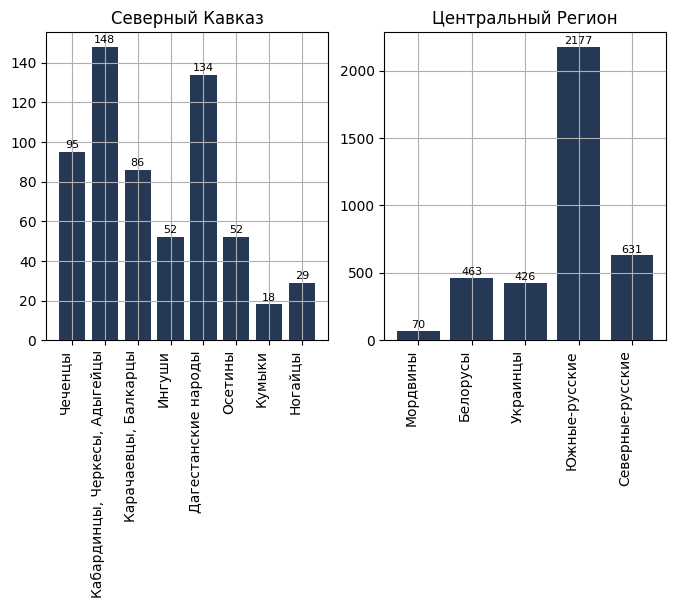

In [4]:
def addlabels(ax, x, y, t):
    for i in range(len(x)):
        ax.text(i, y[i] + 2 if t == 0 else y[i] + 20, y[i], ha = 'center', fontsize=8)

df_cr = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
df_nc = pd.read_csv(r"C:\HSE\genotek\NC_graph_rel.csv")

nodes_names_cr = set()
all_types_dict_cr = {}
nodes_names_nc = set()
all_types_dict_nc = {}

types_cr = pd.concat([df_cr['label_id1'], df_cr['label_id2']], axis=0).unique().tolist()
types_nc = pd.concat([df_nc['label_id1'], df_nc['label_id2']], axis=0).unique().tolist()


for t in types_cr:
    all_types_dict_cr[t] = 0
    
for t in types_nc:
    all_types_dict_nc[t] = 0

for i, n in enumerate(df_cr['node_id1']):
    if n not in nodes_names_cr:
        nodes_names_cr.add(n)
        all_types_dict_cr[df_cr['label_id1'][i]] += 1
        
for i, n in enumerate(df_cr['node_id2']):
    if n not in nodes_names_cr:
        nodes_names_cr.add(n)
        all_types_dict_cr[df_cr['label_id2'][i]] += 1
        
for i, n in enumerate(df_nc['node_id1']):
    if n not in nodes_names_nc:
        nodes_names_nc.add(n)
        all_types_dict_nc[df_nc['label_id1'][i]] += 1
        
for i, n in enumerate(df_nc['node_id2']):
    if n not in nodes_names_nc:
        nodes_names_nc.add(n)
        all_types_dict_nc[df_nc['label_id2'][i]] += 1
        
print(all_types_dict_cr)
print(all_types_dict_nc)

# types_nc_m = ['Chechens', 'Kabardians, Circassians, Adyghes', 'Karachays, Balkars', 'Ingush', 'Dagestan peoples', 'Ossetians', 'Kumyks', 'Nogais']
# types_cr_m = ['Mordvins', 'Belarusians', 'Ukranians', 'Southern Russians', 'Northen Russians']

types_nc_m = ['Чеченцы', 'Кабардинцы, Черкесы, Адыгейцы', 'Карачаевцы, Балкарцы', 'Ингуши', 'Дагестанские народы', 'Осетины', 'Кумыки', 'Ногайцы']
types_cr_m = ['Мордвины', 'Белорусы', 'Украинцы', 'Южные-русские', 'Северные-русские']

plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.bar(all_types_dict_nc.keys(), all_types_dict_nc.values(), color='#253957')
ax2.bar(all_types_dict_cr.keys(), all_types_dict_cr.values(), color='#253957')
ax1.set_xticklabels(types_nc_m, rotation = 90, ha='right')
ax2.set_xticklabels(types_cr_m, rotation = 90, ha='right')
addlabels(ax1, list(all_types_dict_nc.keys()), list(all_types_dict_nc.values()), 0)
addlabels(ax2, list(all_types_dict_cr.keys()), list(all_types_dict_cr.values()), 1)
ax1.grid()
ax2.grid()
ax1.set_title('Северный Кавказ')
ax2.set_title('Центральный Регион')
plt.savefig('num_nodes_per_classes_and_dataset.png', bbox_inches='tight')
plt.show()

## Training and results

### New approach

In [6]:
def get_targets(df, cond, names):
    types = df['label_id1'].unique().tolist()
    types_dict = {}

    for t in types:
        types_dict[t] = 0

    current_types_dict = types_dict.copy()

    targets_dict = {names[i]: None for i in range(len(names))}
    checked = []

    for i, n in enumerate(df['node_id1']):
        if n in checked:
            pass
        else:
            if (current_types_dict[df['label_id1'][i]] + 1) / all_types_dict[df['label_id1'][i]] < cond:
                    id_ = types.index(df['label_id1'][i])
                    current_types_dict[df['label_id1'][i]] += 1
            else:
                id_ = -1
            targets_dict[n] = id_
            checked.append(n)
            
    ####################################
    
    for i, n in enumerate(df['node_id2']):
        if n in checked:
            pass
        else:
            if (current_types_dict[df['label_id2'][i]] + 1) / all_types_dict[df['label_id2'][i]] < cond:
                    id_ = types.index(df['label_id2'][i])
                    current_types_dict[df['label_id2'][i]] += 1
            else:
                id_ = -1
            targets_dict[n] = id_
            checked.append(n)
        
    return list(targets_dict.values())

In [109]:
# inputs = np.zeros((num, num))
# names = ['?' for i in range(num)]
# adj = pd.DataFrame(inputs)

# node_names = pd.concat([df['node_id1'], df['node_id2']], axis=0).unique()
# node_names = sorted(list(map(lambda n: int(n.split('_')[1]), node_names)))

# adj.index = node_names
# adj

In [18]:
# inputs = np.zeros((num, num))
# names = ['?' for i in range(num)]
# for i, n in enumerate(df['node_id1']):
#     row = int(n.split('_')[1])
#     col = int(df['node_id2'][i].split('_')[1])
#     names[row] = n
#     names[col] = df['node_id2'][i]
#     inputs[row, col] = 1
#     inputs[col, row] = 1

# targets = get_targets(df, 2., names)

# np.save('adjacency_matrix.npy', inputs)
# np.save('classes.npy', np.array(targets))

In [19]:
# inputs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

C:\Users\Alex\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


[3 3 3 ... 3 3 3]
              precision    recall  f1-score   support

           0       0.11      0.12      0.12         8
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        43
           3       0.58      0.98      0.73       218
           4       0.00      0.00      0.00        64

    accuracy                           0.57       380
   macro avg       0.14      0.22      0.17       380
weighted avg       0.33      0.57      0.42       380

[[  1   0   0   7   0]
 [  3   0   0  44   0]
 [  1   0   0  42   0]
 [  4   0   0 214   0]
 [  0   0   0  64   0]]


C:\Users\Alex\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\anaconda3\lib\site-packages\sklearn\metrics\

<Figure size 432x288 with 0 Axes>

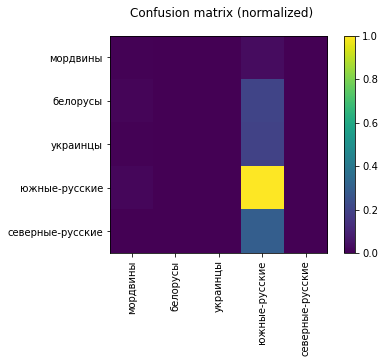

C:\Users\Alex\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [112]:
inputs = np.zeros((num, num))
names = ['?' for i in range(num)]
for i, n in enumerate(df['node_id1']):
    row = int(n.split('_')[1])
    col = int(df['node_id2'][i].split('_')[1])
    names[row] = n
    names[col] = df['node_id2'][i]
    inputs[row, col] = df['ibd_sum'][i]
    inputs[col, row] = df['ibd_sum'][i]

targets = get_targets(df, 0.9, names)

label_prop_model = LabelSpreading(kernel='rbf', n_neighbors=10, max_iter=10000, tol=1e-3, n_jobs=-1, gamma=0.0005)
label_prop_model.fit(inputs, targets)
predicted = label_prop_model.predict(inputs)

print(predicted)

##############################

unlabeled_targets = np.array(targets) == -1

targets = np.array(get_targets(df, 2, names)) # second number - whatever number > 1 because we need to select all data

print(classification_report(targets[unlabeled_targets], predicted[unlabeled_targets]))
cr = classification_report(targets[unlabeled_targets], predicted[unlabeled_targets], output_dict=True)

cm = confusion_matrix(targets[unlabeled_targets], predicted[unlabeled_targets], labels=label_prop_model.classes_)
print(cm)

plt.clf()
fig, ax = plt.subplots(1, 1)
img = ax.imshow(cm/np.max(cm))
ax.set_xticks([i for i in range(5)])
ax.set_xticklabels(all_types_dict.keys(), rotation = 90)
ax.set_yticks([i for i in range(5)])
ax.set_yticklabels(all_types_dict.keys())
fig.colorbar(img)
fig.suptitle("Confusion matrix (normalized)")
plt.savefig(r"C:\HSE\genotek\cm_cr.png", bbox_inches="tight")
plt.show()

for i in range(5):
    fpr, tpr, _ = metrics.roc_curve(targets[unlabeled_targets],  label_prop_model.predict_proba(inputs)[:, i][unlabeled_targets], pos_label=i)
    pre, rec, _ = metrics.precision_recall_curve(targets[unlabeled_targets],  label_prop_model.predict_proba(inputs)[:, i][unlabeled_targets], pos_label=i)

    plt.clf()
    plt.title('Precision / Recall for ' + list(all_types_dict.keys())[i])
    plt.plot(rec, pre)
    plt.plot(cr[str(i)]['recall'], cr[str(i)]['precision'], 'ro')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.savefig(rf"C:\HSE\genotek\precision_recall_curves_{list(all_types_dict.keys())[i]}.png", bbox_inches="tight")
    plt.show()
    
    plt.clf()
    plt.title('TPR / FPR for ' + list(all_types_dict.keys())[i])
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr), color="darkorange")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.legend(loc="lower right")
    plt.savefig(rf"C:\HSE\genotek\roc_{list(all_types_dict.keys())[i]}.png", bbox_inches="tight")
    plt.show()

### Old approach

{'мордвины': 24, 'белорусы': 162, 'украинцы': 149, 'южные-русские': 761, 'северные-русские': 220}
{'мордвины': 70, 'белорусы': 463, 'украинцы': 426, 'южные-русские': 2177, 'северные-русские': 631}
{'мордвины': 70, 'белорусы': 424, 'украинцы': 389, 'южные-русские': 2160, 'северные-русские': 628}
{'мордвины': 70, 'белорусы': 463, 'украинцы': 426, 'южные-русские': 2177, 'северные-русские': 631}
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        46
           1       0.34      0.56      0.42       262
           2       0.21      0.90      0.35       240
           3       0.94      0.51      0.66      1399
           4       0.89      0.31      0.46       408

    accuracy                           0.51      2355
   macro avg       0.68      0.47      0.39      2355
weighted avg       0.79      0.51      0.56      2355

[[   2   12   38    4   14]
 [   0  247  114   59    4]
 [   0   29  320   36    4]
 [   0  182  502 1466   10]
 [  

<Figure size 432x288 with 0 Axes>

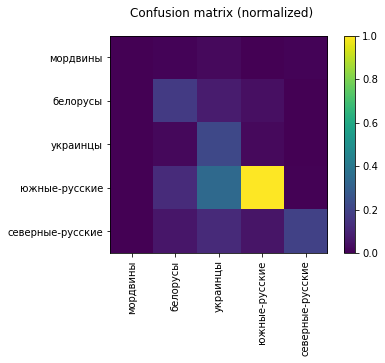

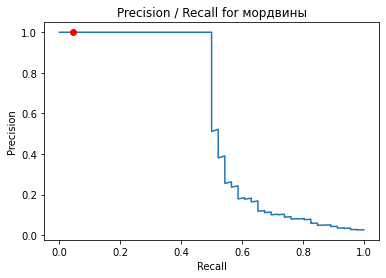

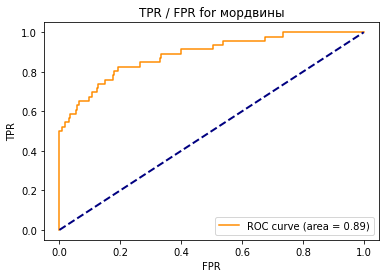

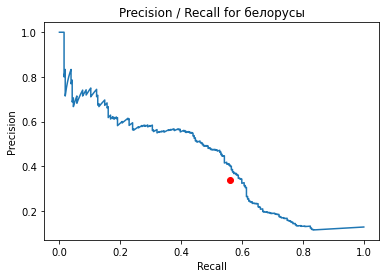

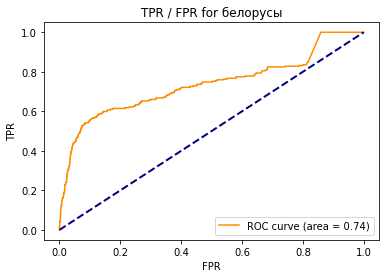

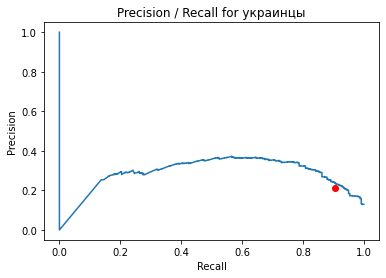

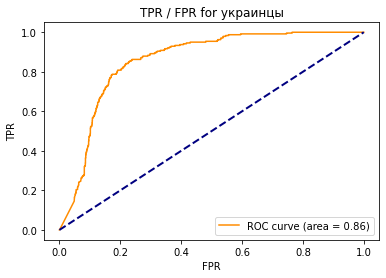

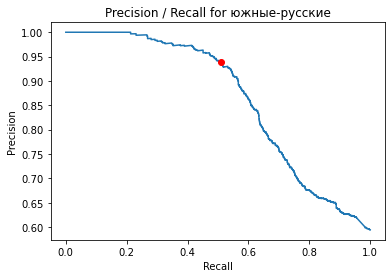

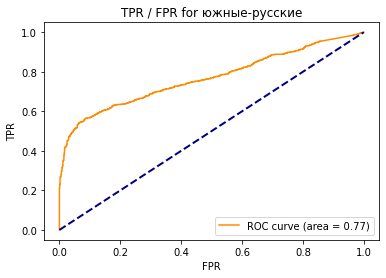

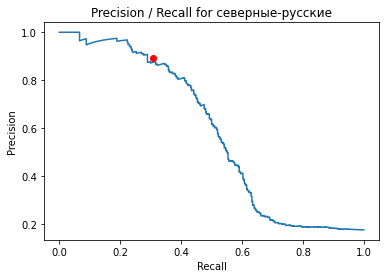

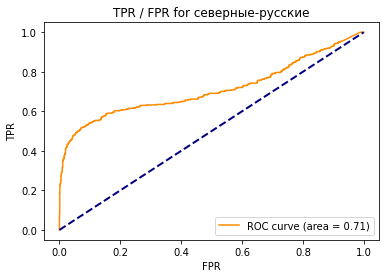

In [35]:
def get_dataset(df, cond):
    types = df['label_id1'].unique().tolist()
    types_dict = {}

    for t in types:
        types_dict[t] = 0

    current_types_dict = types_dict.copy()

    nodes_dict = {}
    
    for i, n in enumerate(df['node_id1']):
        if n in nodes_dict.keys():
            nodes_dict[n][0][df['label_id2'][i]] += df['ibd_sum'][i]
        else:
            if (current_types_dict[df['label_id1'][i]] + 1) / all_types_dict[df['label_id1'][i]] < cond:
                id_ = types.index(df['label_id1'][i])
                current_types_dict[df['label_id1'][i]] += 1
            else:
                id_ = -1
            nodes_dict[n] = [types_dict.copy(), id_]
            
    print(current_types_dict)
    print(all_types_dict)
        
    return nodes_dict

data = get_dataset(df, 0.35) # second number - the part of training data

inputs = [list(i[0].values()) for i in list(data.values())]
targets = [i[1] for i in list(data.values())]

def rbf_kernel_safe(X, Y=None, gamma=None): 

    X, Y = sklearn.metrics.pairwise.check_pairwise_arrays(X, Y) 
    if gamma is None: 
        gamma = 1.0 / X.shape[1] 

    K = sklearn.metrics.pairwise.euclidean_distances(X, Y, squared=True) 
    K *= -gamma 
    K -= K.max()
    np.exp(K, K)    # exponentiate K in-place 
    return K 

label_prop_model = LabelSpreading(kernel='knn', n_neighbors=200, max_iter=1000, tol=1e-3, n_jobs=-1, gamma=0.001)
label_prop_model.fit(inputs, targets)
predicted = label_prop_model.predict(inputs)

unlabeled_targets = np.array(targets) == -1

data = get_dataset(df, 2) # second number - whatever number > 1 because we need to select all data

targets = np.array([i[1] for i in list(data.values())])

print(classification_report(targets[unlabeled_targets], predicted[unlabeled_targets]))
cr = classification_report(targets[unlabeled_targets], predicted[unlabeled_targets], output_dict=True)

cm = confusion_matrix(targets, predicted, labels=label_prop_model.classes_)
print(cm)

plt.clf()
fig, ax = plt.subplots(1, 1)
img = ax.imshow(cm/np.max(cm))
ax.set_xticks([i for i in range(5)])
ax.set_xticklabels(all_types_dict.keys(), rotation = 90)
ax.set_yticks([i for i in range(5)])
ax.set_yticklabels(all_types_dict.keys())
fig.colorbar(img)
fig.suptitle("Confusion matrix (normalized)")
plt.savefig(r"C:\HSE\genotek\cm_cr.png", bbox_inches="tight")
plt.show()

for i in range(5):
    fpr, tpr, _ = metrics.roc_curve(targets[unlabeled_targets],  label_prop_model.predict_proba(inputs)[:, i][unlabeled_targets], pos_label=i)
    pre, rec, _ = metrics.precision_recall_curve(targets[unlabeled_targets],  label_prop_model.predict_proba(inputs)[:, i][unlabeled_targets], pos_label=i)

    plt.clf()
    plt.title('Precision / Recall for ' + list(all_types_dict.keys())[i])
    plt.plot(rec, pre)
    plt.plot(cr[str(i)]['recall'], cr[str(i)]['precision'], 'ro')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.savefig(rf"C:\HSE\genotek\precision_recall_curves_{list(all_types_dict.keys())[i]}.png", bbox_inches="tight")
    plt.show()
    
    plt.clf()
    plt.title('TPR / FPR for ' + list(all_types_dict.keys())[i])
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr), color="darkorange")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.legend(loc="lower right")
    plt.savefig(rf"C:\HSE\genotek\roc_{list(all_types_dict.keys())[i]}.png", bbox_inches="tight")
    plt.show()

# Tensorflow

In [29]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization
import gc

In [32]:
y_true = [[0, 1], [1, 0]]
y_pred = [[0.05, 0.95], [0.1, 0.9]]
cce(y_true, y_pred).numpy()

1.1769392

In [45]:
cce = tf.keras.losses.CategoricalCrossentropy()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

y_true_1 = [[1]]
y_pred_1 = [[0.01]]

y_true_2 = [[1]]
y_pred_2 = [[0.95]]

y_true_3 = [[0, 1]]
y_pred_3 = [[0.05, 0.95]]

cc_1 = cce(y_true_1, y_pred_1).numpy()
cc_2 = cce(y_true_2, y_pred_2).numpy()
cc_3 = cce(y_true_3, y_pred_3).numpy()

bc_1 = bce(y_true_1, y_pred_1).numpy()
bc_2 = bce(y_true_2, y_pred_2).numpy()

print(cc_1==cc_2, cc_1, cc_2)
print(bc_1==bc_2, bc_1, bc_2, cc_3)

True 1.192093e-07 1.192093e-07
False 4.60516 0.051293183 0.051293306


1.192093e-07

In [41]:
def get_dataset(df, cond):
    types = df['label_id1'].unique().tolist()
    types_dict = {}

    for t in types:
        types_dict[t] = 0

    current_types_dict = types_dict.copy()

    nodes_dict = {}
    selection = []
    
    for i, n in enumerate(df['node_id1']):
        if n in nodes_dict.keys():
            nodes_dict[n][0][df['label_id2'][i]] += df['ibd_sum'][i]
        else:
            if (current_types_dict[df['label_id1'][i]] + 1) / all_types_dict[df['label_id1'][i]] < cond:
                id_ = types.index(df['label_id1'][i])
                current_types_dict[df['label_id1'][i]] += 1
                selection.append(id_)
            else:
                selection.append(-1)
            nodes_dict[n] = [types_dict.copy(), id_]
            
        
    return nodes_dict, np.array(selection)

data, selection = get_dataset(df, 0.7)

inputs = np.array([list(i[0].values()) for i in list(data.values())])
targets = np.array([i[1] for i in list(data.values())])

train_inputs = inputs[selection != -1]
train_targets = targets[selection != -1]

test_inputs = inputs[selection == -1]
test_targets = targets[selection == -1]

train_targets

array([0, 0, 0, ..., 2, 2, 2])

In [69]:
inputs = Input(shape =(5,))

x0 = Dense(1024, activation = 'relu')(inputs)
x1 = Dense(1024, activation = 'relu')(inputs)
x2 = Dense(1024, activation = 'relu')(inputs)
x3 = Dense(1024, activation = 'relu')(inputs)

x = Concatenate()([
                x0, 
                x1, 
                x2,
                x3
               ])

x = Dense(5, activation = 'softmax')(x)

model = Model(inputs, x)

In [70]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 dense_32 (Dense)               (None, 1024)         6144        ['input_14[0][0]']               
                                                                                                  
 dense_33 (Dense)               (None, 1024)         6144        ['input_14[0][0]']               
                                                                                                  
 dense_34 (Dense)               (None, 1024)         6144        ['input_14[0][0]']               
                                                                                           

In [71]:
gc.collect()

lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = 0)

es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 40, 
                    verbose = 0,
                    mode = "min", 
                    restore_best_weights = True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './genotek',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

callbacks = [
                    lr, 
                    es, 
                    model_checkpoint_callback
                    ]

model.compile(
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics = 'acc',
                loss = tf.keras.losses.SparseCategoricalCrossentropy()
                 )

    
model.fit(train_inputs,
                train_targets, 
                validation_data=(test_inputs,
                                test_targets), 
                epochs = 1000,
                verbose = 1,
                batch_size = 16,
                shuffle = True,
                callbacks = callbacks)

model.load_weights('./genotek')

predicted = np.argmax(model.predict(test_inputs), axis=1)

print(classification_report(test_targets, predicted))

Epoch 1/1000
165/165 [==============================] - 1s 5ms/step - loss: 5.6681 - acc: 0.8014 - val_loss: 4.1274 - val_acc: 0.3877 - lr: 0.0100
Epoch 2/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.4504 - acc: 0.8489 - val_loss: 3.3604 - val_acc: 0.3770 - lr: 0.0100
Epoch 3/1000
165/165 [==============================] - 0s 3ms/step - loss: 0.5584 - acc: 0.8421 - val_loss: 4.8949 - val_acc: 0.3703 - lr: 0.0100
Epoch 4/1000
165/165 [==============================] - 0s 3ms/step - loss: 0.4622 - acc: 0.8462 - val_loss: 4.8226 - val_acc: 0.3934 - lr: 0.0100
Epoch 5/1000
165/165 [==============================] - 0s 3ms/step - loss: 0.4546 - acc: 0.8542 - val_loss: 4.2798 - val_acc: 0.3664 - lr: 0.0100
Epoch 6/1000
165/165 [==============================] - 0s 3ms/step - loss: 0.4398 - acc: 0.8622 - val_loss: 3.9673 - val_acc: 0.3838 - lr: 0.0100
Epoch 7/1000
165/165 [==============================] - 1s 3ms/step - loss: 0.4081 - acc: 0.8580 - val_loss: 4.8862 - 

C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

# Torch Geometric

In [2]:
import torch
print(torch.__version__)
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn

1.13.0+cu116


## Vanillia example

In [3]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx

In [4]:
nx.__version__

'3.1'

In [180]:
G = nx.Graph()

# Add some cars (just do 4 for now)
G.add_nodes_from([
      (1, {'y': 0, 'x': [[0.5], [0.8], [0.9]]}),
      (2, {'y': 0, 'x': [[0.2], [0.8], [0.9]]}),
      (3, {'y': 1, 'x': [[0.3], [0.8], [0.9]]}),
      (4, {'y': 1, 'x': [[0.1], [0.8], [0.9]]}),
      (5, {'y': 1, 'x': [[0.2], [0.8], [0.9]]}),
])

# Add some edges
G.add_edges_from([
                  (1, 2), (1, 4), (1, 5),
                  (2, 3), (2, 4),
                  (3, 2), (3, 5),
                  (4, 1), (4, 2),
                  (5, 1), (5, 3)
])

# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(G)

pyg_graph.num_classes = 2

print(pyg_graph.num_features)

print(pyg_graph)
# Data(edge_index=[2, 12], x=[5], y=[5])
print(pyg_graph.x)
# tensor([0.5000, 0.2000, 0.3000, 0.1000, 0.2000])
print(pyg_graph.y)
# tensor([1, 2, 3, 4, 5])
print(pyg_graph.edge_index)
# tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
#         [1, 3, 4, 0, 2, 3, 1, 4, 0, 1, 0, 2]])


# # Split the data 
# train_ratio = 0.2
# num_nodes = pyg_graph.x.shape[0]
# num_train = int(num_nodes * train_ratio)
# idx = [i for i in range(num_nodes)]

# np.random.shuffle(idx)
# train_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
# train_mask[idx[:num_train]] = True
# test_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
# test_mask[idx[num_train:]] = True

# print(train_mask)
# # tensor([ True, False, False, False, False])
# print(test_mask)
# # tensor([False,  True,  True,  True,  True])

1
Data(x=[5, 3, 1], edge_index=[2, 12], y=[5], num_classes=2)
tensor([[[0.5000],
         [0.8000],
         [0.9000]],

        [[0.2000],
         [0.8000],
         [0.9000]],

        [[0.3000],
         [0.8000],
         [0.9000]],

        [[0.1000],
         [0.8000],
         [0.9000]],

        [[0.2000],
         [0.8000],
         [0.9000]]])
tensor([0, 0, 1, 1, 1])
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 3, 1, 4, 0, 1, 0, 2]])


In [184]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features*3, 16)
        self.conv2 = GCNConv(16, int(data.num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        print('GOOGLE1')
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        print('GOOGLE2')
        return F.log_softmax(x, dim=1)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

data =  pyg_graph.to(device)

model = Net().to(device)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out= model(data)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

for epoch in range(401):
    loss = train(data)
    print(loss)

cpu
GOOGLE1


RuntimeError: index 3 is out of bounds for dimension 0 with size 3

Testing vanilia example on different graph size

In [179]:
model.eval()
model(pyg_graph_big.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (18x1 and 3x16)

## Real example from scratch

In [4]:
from numba import njit, prange
import time
import seaborn as sns

In [5]:
from torch.nn import Linear

class AttnGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GATConv(in_channels=5,
                             out_channels=15,
                             heads=2, 
                             add_self_loops=False,
                             edge_dim=1)
        self.fc1 = Linear(30, 15)
        self.fc2 = Linear(15, 5)

    def forward(self, data):
        x, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.conv1(x, edge_index, edge_weight)
        h = h.relu()
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        return h



In [6]:
import torch
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.norm = BatchNorm1d(5)
        self.conv1 = GCNConv(5, 15, 
                             add_self_loops=False,
                             normalize=True)
        self.conv2 = GCNConv(15, 15, 
                             add_self_loops=False,
                             normalize=True)
        self.fc1 = Linear(15, 15)
        self.fc2 = Linear(15, 15)
        self.fc3 = Linear(15, 5)

    def forward(self, data):
        x, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.norm(x)
        h = self.conv1(h, edge_index, edge_weight)
        h = h.relu()
        h = self.conv2(h, edge_index, edge_weight)
        h = h.relu()
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        h = h.relu()
        h = self.fc3(h)
        return h

In [77]:
import torch
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GCNConv

class SimpleNN8(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.norm = BatchNorm1d(8)
        self.fc1 = Linear(8, 15)
        self.fc2 = Linear(15, 15)
        self.fc3 = Linear(15, 8)

    def forward(self, data):
        h, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.norm(h)
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        h = h.relu()
        h = self.fc3(h)
        return h
    
    
class SimpleNN5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.norm = BatchNorm1d(5)
        self.fc1 = Linear(5, 15)
        self.fc2 = Linear(15, 15)
        self.fc3 = Linear(15, 5)

    def forward(self, data):
        h, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.norm(h)
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        h = h.relu()
        h = self.fc3(h)
        return h

Raw data

In [2]:
df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
df

node_id1   node_id2 label_id1 label_id2   ibd_sum  ibd_n
0         node_0     node_5  мордвины  мордвины  29.81720      4
1         node_0    node_10  мордвины  мордвины  11.63220      1
2         node_0    node_11  мордвины  мордвины  23.90440      2
3         node_0    node_18  мордвины  мордвины  11.25290      1
4         node_0    node_20  мордвины  мордвины   8.88252      1
...          ...        ...       ...       ...       ...    ...
67498  node_3741  node_3752  белорусы  белорусы   9.51327      1
67499  node_3745  node_3755  белорусы  белорусы   9.23221      1
67500  node_3749  node_3764  белорусы  белорусы  10.63310      1
67501  node_3754  node_3755  украинцы  белорусы   8.04722      1
67502  node_3758  node_3766  белорусы  белорусы   8.77936      1

[67503 rows x 6 columns]

In [111]:
df = pd.read_csv(r"C:\HSE\genotek\simulated_CR.csv", sep=' ', header=None, names=['node_id1', 'node_id2', 'label_id1', 'label_id2', 'ibd_sum'])
df

node_id1  node_id2  label_id1  label_id2    ibd_sum
0             0        51          0          0   5.803121
1             0       128          0          0   8.482310
2             0       151          0          0   3.116207
3             0       481          2          0   6.326029
4             0       497          2          0   4.445070
...         ...       ...        ...        ...        ...
11924       977       985          4          4   4.263169
11925       982       995          4          4   4.618389
11926       988       991          4          4   7.455003
11927       989       998          4          4  13.986361
11928       994       996          4          4  12.429165

[11929 rows x 5 columns]

Function for getting train and test nodes

In [3]:
def get_train_test_nodes(df, train_coeff, mask_coeff):
    
    new_labels = None
    
    # get list of all labels
    types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
#     print("TYPES: ", types)
    
    # concatenate all nodes in one column
    n = pd.concat([df['node_id1'], df['node_id2']], axis=0)
    
    # concatenate all labels in one column
    l = pd.concat([df['label_id1'], df['label_id2']], axis=0)
    
    # merge all nodes and all labels column-wise
    df_new = pd.concat([n, l], axis=1)
    
    # get class for every node 
    df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
    df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
    
    df_copied = df.copy()
    if len(df_new.iloc[:, 0].unique()) < df_new.iloc[:, 0].max():
        print('Relabelling!!!')
        new_labels = {i:n for n, i in enumerate(df_new.iloc[:, 0].unique())}
#         print(new_labels)
        for i in range(df.shape[0]):
            df_copied.iloc[i, 0] = 'node_' + str(new_labels[int(df.iloc[i, 0].split('_')[1])])
            df_copied.iloc[i, 1] = 'node_' + str(new_labels[int(df.iloc[i, 1].split('_')[1])])
            
    types = pd.concat([df_copied['label_id1'], df_copied['label_id2']], axis=0).unique().tolist()
#     print("TYPES: ", types)
    n = pd.concat([df_copied['node_id1'], df_copied['node_id2']], axis=0)
    l = pd.concat([df_copied['label_id1'], df_copied['label_id2']], axis=0)
    df_new = pd.concat([n, l], axis=1)
    
    # get class for every node 
    df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
    df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
    
    df_new = df_new.drop_duplicates()
    node_classes_random = df_new.sample(frac=1)
    node_classes_sorted = df_new.sort_values(by=[0])
    
#     if NC:
#         missed_nodes = []
#         for i in range(node_classes_sorted.shape[0]):
#             if i not in node_classes_sorted.iloc[:, 0].to_numpy():
#                 missed_nodes.append([i, -1])
        
#         tmp_df = pd.DataFrame(missed_nodes)
        
#         print(tmp_df)
        
#         node_classes_sorted = pd.concat([node_classes_sorted, tmp_df], axis=0).sort_values(by=[0])
    
    # get number of nodes for every class
    num_nodes_per_class = node_classes_random.iloc[:, 1].value_counts()
    
    train_nodes, test_nodes = [], []
    node_counter = {i:0 for i in range(num_nodes_per_class.shape[0])}
    
    # add masking
    mask_array = []
    
    # split nodes
    for i in range(node_classes_random.shape[0]):
        node_class = node_classes_random.iloc[i, 1]
        if node_counter[node_class] <= int(train_coeff * num_nodes_per_class.loc[node_class]):
            train_nodes.append(node_classes_random.iloc[i, 0])
            
            mask_array.append(True)
            
#             if node_counter[node_class] > int(mask_coeff * train_coeff * num_nodes_per_class.loc[node_class]):
#                 mask_array.append(True)
#             else:
#                 mask_array.append(False)
            
            node_counter[node_class] += 1
        else:
            test_nodes.append(node_classes_random.iloc[i, 0])
    
    return df_copied, train_nodes, test_nodes, node_classes_sorted, mask_array, new_labels

def make_train_test_dataset(df, train_nodes: list, test_nodes: list, node_classes_sorted, mask_array):
    
    train_mask_array = mask_array
    
    # get list of all labels
    types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
#     print("TYPES: ", types)
    
    # preprocess initial data
    df_processed = df.copy()
    df_processed.iloc[:, 0] = df_processed.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
    df_processed.iloc[:, 1] = df_processed.iloc[:, 1].apply(lambda n: int(n.split('_')[1]))
    df_processed.iloc[:, 2] = df_processed.iloc[:, 2].apply(lambda t: types.index(t))
    df_processed.iloc[:, 3] = df_processed.iloc[:, 3].apply(lambda t: types.index(t))
    
    # making dataframe with only training nodes
    df_for_training = df_processed.copy()
    
    drop_rows = drop_rows_for_training_dataset(df_for_training.to_numpy(), np.array(test_nodes))
    
    df_for_training = df_for_training.drop(drop_rows)
    
    sel_n_tr = set(np.unique(df_for_training.iloc[:, :2].to_numpy()))
    real_n_tr = set(train_nodes)
    
    eliminated_nodes = real_n_tr.difference(sel_n_tr)
    print(eliminated_nodes, len(eliminated_nodes))
    
    # construct training graph ############################# SAME PART BELOW ##############################
    
    # construct hash map for training nodes
    hashmap = np.array([1e6 for i in range(len(node_classes_sorted))]).astype(int)
    for i, node in enumerate(train_nodes):
        hashmap[node] = i
        
#     print(hashmap)
    
    # calculate sum of idb for each training node
    sum_training_idb = np.zeros((len(train_nodes), len(types)))
    
    calculate_sum_of_idb_for_each_train_node(sum_training_idb, df_for_training.to_numpy(), hashmap, np.array(train_mask_array))
        
#     print(node_classes_sorted)
                
    # construct targets
    targets = construct_node_classes(node_classes_sorted.to_numpy(), train_nodes)
        
    # construct edges
    train_graph_weighted_edges = construct_edges(df_for_training.to_numpy(), hashmap)
    
    sort_idx = np.lexsort((train_graph_weighted_edges[:, 1], train_graph_weighted_edges[:, 0]))
    train_graph_weighted_edges = train_graph_weighted_edges[sort_idx]
    
    train_graph_pytorch = Data.from_dict({'y': torch.tensor(targets, dtype=torch.long), 'x': torch.tensor(sum_training_idb), 'weight': torch.tensor(train_graph_weighted_edges[:, 2]), 'edge_index': torch.tensor(train_graph_weighted_edges[:, :2].T, dtype=torch.long)})
    
    train_graph_pytorch.num_classes = len(types)
    
    if len(np.unique(train_graph_pytorch.edge_index.cpu().detach().numpy())) != len(train_nodes):
#         print(len(np.unique(train_graph_pytorch.edge_index.cpu().detach().numpy())))
#         print(len(train_nodes))
        raise Exception("Train graph is not connected!!! Restart assembling!")
    
    ############################# SAME PART UP ##############################
    
    # creating array of graphs for testing
    
#     array_of_graphs_for_testing = [[] for i in range(len(test_nodes))]
    array_of_graphs_for_testing = []
    
    print('Starting selecting lines...')
    
    start = time.time()
    
    rows_for_adding_per_node = select_lines(np.array(train_nodes), np.array(test_nodes), df_processed.to_numpy())
    
    end = time.time()
    
    print(f'Done selecting lines in {end-start} seconds')
    
    warning_counter = 0
    
    test_nodes_degree = []###
    
    for k, test_node in enumerate(test_nodes):
        
        print(f'Processed {k} / {len(test_nodes)} nodes')
        
#         for var_class in range(len(types)):
        
        test_mask_array = train_mask_array + [True]

        rows_for_adding = rows_for_adding_per_node[k]
        ###
        test_nodes_degree.append(len(rows_for_adding))###
        ###
        df_for_testing = pd.concat([df_for_training, df_processed.iloc[rows_for_adding]], axis=0)

        print(df_for_testing.shape, df_for_training.shape)

        if df_for_testing.shape[0] == df_for_training.shape[0]:
            warning_counter += 1

        current_test_nodes = train_nodes + [test_node]

        # construct testing graph ############################# SAME PART BELOW ##############################

        start = time.time()

        # construct hash map for training nodes
        hashmap = np.array([1e6 for i in range(len(node_classes_sorted))]).astype(int)
        for i, node in enumerate(current_test_nodes):
            hashmap[node] = i

#         print('HASHMAP:', hashmap)

        # calculate sum of idb for each training node
        sum_testing_idb = np.zeros((len(current_test_nodes), len(types)))
#         sum_testing_idb = np.ones((len(current_test_nodes), len(types)))
        

#             calculate_sum_of_idb_for_each_test_node(sum_testing_idb, df_for_testing.to_numpy(), hashmap, np.array(test_mask_array), test_node, var_class)
        one_hot_encoded_features(sum_testing_idb, df_for_testing.to_numpy(), hashmap, np.array(test_mask_array), test_node, types)

        print(f'calculate sum of idb for each training node: {time.time() - start}')

        start = time.time()

        # construct targets
        targets = construct_node_classes(node_classes_sorted.to_numpy(), current_test_nodes)

        print(f'construct targets: {time.time() - start}')

        start = time.time()

        # construct edges
        test_graph_weighted_edges = construct_edges(df_for_testing.to_numpy(), hashmap)

        sort_idx = np.lexsort((test_graph_weighted_edges[:, 1], test_graph_weighted_edges[:, 0]))
        test_graph_weighted_edges = test_graph_weighted_edges[sort_idx]

        print(f'construct edges: {time.time() - start}')

#         start = time.time()

        test_graph_pytorch = Data.from_dict({'y': torch.tensor(targets, dtype=torch.long), 'x': torch.tensor(sum_testing_idb), 'weight': torch.tensor(test_graph_weighted_edges[:, 2]), 'edge_index': torch.tensor(test_graph_weighted_edges[:, :2].T, dtype=torch.long)})

        test_graph_pytorch.num_classes = len(types)

#         array_of_graphs_for_testing[k].append(test_graph_pytorch)
        array_of_graphs_for_testing.append(test_graph_pytorch)

#         print(f'build pytorch geometric dataset: {time.time() - start}')

        ############################# SAME PART UP ##############################
        
    print('WARNING COUNTER:', warning_counter)
    
    # new multiple training dataset ############################################################################
    
    array_of_graphs_for_training = []
    
    for k in range(len(train_nodes)):
        
        print(f'{k}/{len(train_nodes)}')
        
        one_curr_train_node = train_nodes[k]
        curr_train_nodes = train_nodes + [one_curr_train_node]
        curr_train_nodes.remove(one_curr_train_node)

        # construct training graph ############################# SAME PART BELOW ##############################

        # construct hash map for training nodes
        hashmap = np.array([1e6 for i in range(len(node_classes_sorted))]).astype(int)
        for i, node in enumerate(curr_train_nodes):
            hashmap[node] = i

    #     print(hashmap)

        # calculate sum of idb for each training node
        sum_training_idb = np.zeros((len(curr_train_nodes), len(types)))

        one_hot_encoded_features(sum_training_idb, df_for_training.to_numpy(), hashmap, np.array(train_mask_array), one_curr_train_node, types)

    #     print(node_classes_sorted)

        # construct targets
        targets = construct_node_classes(node_classes_sorted.to_numpy(), curr_train_nodes)

        # construct edges
        train_graph_weighted_edges = construct_edges(df_for_training.to_numpy(), hashmap)

        sort_idx = np.lexsort((train_graph_weighted_edges[:, 1], train_graph_weighted_edges[:, 0]))
        train_graph_weighted_edges = train_graph_weighted_edges[sort_idx]

        curr_train_graph_pytorch = Data.from_dict({'y': torch.tensor(targets, dtype=torch.long), 'x': torch.tensor(sum_training_idb), 'weight': torch.tensor(train_graph_weighted_edges[:, 2]), 'edge_index': torch.tensor(train_graph_weighted_edges[:, :2].T, dtype=torch.long)})

        curr_train_graph_pytorch.num_classes = len(types)
        
        array_of_graphs_for_training.append(curr_train_graph_pytorch)
        
        
    
    return array_of_graphs_for_training, array_of_graphs_for_testing, types, test_nodes_degree

In [4]:
@njit(cache=True)
def select_lines(train_nodes, test_nodes, df_processed):
    
    rows_for_adding_per_node = []
    
    for i in range(len(test_nodes)):
        tmp = []
        for j in range(df_processed.shape[0]):
            row = df_processed[j]
            if int(row[0]) == test_nodes[i] and int(row[1]) in train_nodes or int(row[1]) == test_nodes[i] and int(row[0]) in train_nodes:
                
                tmp.append(j)
                
        rows_for_adding_per_node.append(tmp)
    
    return rows_for_adding_per_node


@njit(cache=True)
def calculate_sum_of_idb_for_each_train_node(sum_testing_ibd, df_for_testing, hashmap, mask_array):
    
    for i in range(df_for_testing.shape[0]):
        row = df_for_testing[i]
        if mask_array[hashmap[int(row[0])]]:
            sum_testing_ibd[hashmap[int(row[0])], int(row[3])] += row[4]
            sum_testing_ibd[hashmap[int(row[1])], int(row[2])] += row[4]
                
                
@njit(cache=True)
def calculate_sum_of_idb_for_each_test_node(sum_testing_ibd, df_for_testing, hashmap, mask_array, test_node, var_class):
    
    for i in range(df_for_testing.shape[0]):
        row = df_for_testing[i]
        if mask_array[hashmap[int(row[0])]]:
            if int(row[0]) == test_node:
                sum_testing_ibd[hashmap[int(row[0])], int(row[3])] += row[4]
                sum_testing_ibd[hashmap[int(row[1])], var_class] += row[4]
            elif int(row[1]) == test_node:
                sum_testing_ibd[hashmap[int(row[1])], int(row[2])] += row[4]
                sum_testing_ibd[hashmap[int(row[0])], var_class] += row[4]
            else:
                sum_testing_ibd[hashmap[int(row[0])], int(row[3])] += row[4]
                sum_testing_ibd[hashmap[int(row[1])], int(row[2])] += row[4]
                
                
@njit(cache=True)
def calculate_sum_of_idb_for_each_test_node_for_ind_learn(sum_testing_ibd, df_for_testing, hashmap, mask_array, test_node):
    
    for i in range(df_for_testing.shape[0]):
        row = df_for_testing[i]
        if mask_array[hashmap[int(row[0])]]:
            if int(row[0]) == test_node:
                sum_testing_ibd[hashmap[int(row[0])], int(row[3])] += row[4]
            elif int(row[1]) == test_node:
                sum_testing_ibd[hashmap[int(row[1])], int(row[2])] += row[4]
            else:
                sum_testing_ibd[hashmap[int(row[0])], int(row[3])] += row[4]
                sum_testing_ibd[hashmap[int(row[1])], int(row[2])] += row[4]
                
                
@njit(cache=True)
def one_hot_encoded_features(sum_testing_ibd, df_for_testing, hashmap, mask_array, test_node, types):
    
    for i in range(df_for_testing.shape[0]):
        row = df_for_testing[i]
        if mask_array[hashmap[int(row[0])]]:
            if int(row[0]) == test_node:
                sum_testing_ibd[hashmap[int(row[0])], :] = [1/len(types)] * len(types)
            elif int(row[1]) == test_node:
                sum_testing_ibd[hashmap[int(row[1])], :] = [1/len(types)] * len(types)
            else:
                sum_testing_ibd[hashmap[int(row[0])], :] = [1 if i==int(row[2]) else 0 for i in range(len(types))]
                sum_testing_ibd[hashmap[int(row[1])], :] = [1 if i==int(row[3]) else 0 for i in range(len(types))]


@njit(cache=True)
def construct_edges(d, hashmap):
    
    test_graph_weighted_edges = []
    
    for i in range(d.shape[0]):
        row = d[i]
        test_graph_weighted_edges.append([hashmap[int(row[0])], hashmap[int(row[1])], row[4]])
        test_graph_weighted_edges.append([hashmap[int(row[1])], hashmap[int(row[0])], row[4]])
        
    return np.array(test_graph_weighted_edges)


@njit(cache=True)
def drop_rows_for_training_dataset(df_for_training, test_nodes):
    drop_rows = []
    for i in range(df_for_training.shape[0]): # speed it up in future
        if i % 1000 == 0:
            print(f'Processed {i} / {df_for_training.shape[0]} lines for training dataset')
        row = df_for_training[i, :]
        if int(row[0]) in test_nodes or int(row[1]) in test_nodes:
            drop_rows.append(i)
            
    return drop_rows


@njit(cache=True)
def construct_node_classes(node_classes_sorted, current_nodes):
    targets = []
    for node in current_nodes:
        targets.append(node_classes_sorted[node, 1])
        
    return targets
    

In [32]:
def aaa(a):
    a = list(set([1, 2]))
    return a

aaa([6, 7, 8])

[1, 2]

Testing data preprocessing

In [289]:
set([8, 1, 2]) == set([2, 1, 8])

True

In [29]:
debugging_df = pd.DataFrame([['node_0', 'node_1', 'a', 'a', 10, 0],
                            ['node_0', 'node_2', 'a', 'b', 10, 0],
                            ['node_0', 'node_4', 'a', 'b', 10, 0],
                            ['node_1', 'node_2', 'a', 'b', 10, 0],
                            ['node_1', 'node_3', 'a', 'b', 10, 0],
                            ['node_0', 'node_3', 'a', 'b', 10, 0],
                            ['node_0', 'node_4', 'a', 'b', 10, 0],
                            ['node_0', 'node_5', 'a', 'a', 10, 0],
                            ['node_1', 'node_4', 'a', 'b', 10, 0],
                            ['node_1', 'node_5', 'a', 'a', 10, 0],
                            ['node_1', 'node_6', 'a', 'a', 10, 0],
                            ['node_1', 'node_7', 'a', 'a', 10, 0],
                            ['node_2', 'node_8', 'b', 'a', 10, 0],
                            ['node_2', 'node_3', 'b', 'b', 10, 0],
                            ['node_2', 'node_4', 'b', 'b', 10, 0],
#                             ['node_2', 'node_9', 'b', 'b', 10, 0],
                            ['node_2', 'node_10', 'b', 'b', 10, 0],
                            ['node_3', 'node_9', 'b', 'b', 10, 0],
                            ['node_3', 'node_6', 'b', 'a', 10, 0],
                            ['node_3', 'node_7', 'b', 'a', 10, 0]], columns=['node_id1', 'node_id2', 'label_id1', 'label_id2', 'ibd_sum', 'ibd_n'])

# a: 0, 1, 5, 6, 7, 8
# b: 2, 3, 4, 9, 10

In [30]:
debugging_df

node_id1 node_id2 label_id1 label_id2  ibd_sum  ibd_n
0    node_0   node_1         a         a       10      0
1    node_0   node_2         a         b       10      0
2    node_0   node_4         a         b       10      0
3    node_1   node_2         a         b       10      0
4    node_1   node_3         a         b       10      0
5    node_0   node_3         a         b       10      0
6    node_0   node_4         a         b       10      0
7    node_0   node_5         a         a       10      0
8    node_1   node_4         a         b       10      0
9    node_1   node_5         a         a       10      0
10   node_1   node_6         a         a       10      0
11   node_1   node_7         a         a       10      0
12   node_2   node_8         b         a       10      0
13   node_2   node_3         b         b       10      0
14   node_2   node_4         b         b       10      0
15   node_2  node_10         b         b       10      0
16   node_3   node_9         b         b       10      0
17   node_3   node_6         b         a       10      0
18   node_3   node_7         b         a       10      0

In [75]:
tr, ts, nks, mask_array = get_train_test_nodes(debugging_df, 0.7, mask_coeff=0.0, NC=False) # to-do: 70:30 split ration because kenenbek did it this way
print(tr)
print(ts)
data, test_graphs, types = make_train_test_dataset(debugging_df, tr, ts, nks, mask_array)

TYPES:  ['a', 'b']
[5, 2, 3, 10, 1, 7, 8]
[4, 6, 9, 0]
TYPES:  ['a', 'b']
Processed 0 / 19 lines for training dataset
[1000000       4       1       2 1000000       0 1000000       5       6
 1000000       3]
     0  1
0    0  0
3    1  0
12   2  1
16   3  1
2    4  1
7    5  0
10   6  0
11   7  0
12   8  0
16   9  1
15  10  1
Starting selecting lines...
Done selecting lines in 0.03573727607727051 seconds
Processed 0 / 4 nodes
(10, 6) (8, 6)
HASHMAP: [1000000       4       1       2       7       0 1000000       5       6
 1000000       3]
calculate sum of idb for each training node: 0.0004961490631103516
construct targets: 0.0
construct edges: 0.0
Processed 1 / 4 nodes
(10, 6) (8, 6)
HASHMAP: [1000000       4       1       2 1000000       0       7       5       6
 1000000       3]
calculate sum of idb for each training node: 0.0
construct targets: 0.0
construct edges: 0.0
Processed 2 / 4 nodes
(9, 6) (8, 6)
HASHMAP: [1000000       4       1       2 1000000       0 1000000       5    

In [64]:
data

Data(x=[5, 2], edge_index=[2, 2], y=[5], weight=[2], num_classes=2)

In [65]:
data.x

tensor([[10.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0., 10.]], dtype=torch.float64)

In [68]:
test_graphs[0].x

tensor([[20.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0., 10.],
        [ 0., 10.]], dtype=torch.float64)

Special functions for metis

In [67]:
def parse_metis_file_to_dataframe(path):
    
    data = []
    types = ['Central-Russia', 'Jews']
    
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            if i % 10000 == 0:
                print(f"Done {i} / lines")
            tmp = []
            if i != 0:
                items = line.split(',')
                
                node1 = items[0]
                node2 = items[1]
                ibd = float(items[2])
                
                if items[3][0] == "\"":
                    node1_p1 = items[3].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                    node1_p2 = items[4].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                    
                    if float(node1_p1[1]) > float(node1_p2[1]): #50% / 50% ???
                        node1_type = types.index(node1_p1[0])
                    else:
                        node1_type = types.index(node1_p2[0])
                        
                    if items[5][0] == "\"":
                        node2_p1 = items[5].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                        node2_p2 = items[6].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")

                        if float(node2_p1[1]) > float(node2_p2[1]): #50% / 50% ???
                            node2_type = types.index(node2_p1[0])
                        else:
                            node2_type = types.index(node2_p2[0])
                            
                    else:
                        node2_p1 = items[5].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                    
                        node2_type = types.index(node2_p1[0])
                    
                else:
                    node1_p1 = items[3].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                    
                    node1_type = types.index(node1_p1[0])
                    
                    if items[4][0] == "\"":
                        node2_p1 = items[4].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                        node2_p2 = items[5].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")

                        if float(node2_p1[1]) > float(node2_p2[1]): #50% / 50% ???
                            node2_type = types.index(node2_p1[0])
                        else:
                            node2_type = types.index(node2_p2[0])
                            
                    else:
                        node2_p1 = items[4].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').split(":")
                    
                        node2_type = types.index(node2_p1[0])
                    
                    
                tmp = [node1, node2, node1_type, node2_type, ibd]
                data.append(tmp)
    
    return pd.DataFrame(data, columns=['node_id1', 'node_id2', 'label_id1', 'label_id2', 'ibd_sum'])

In [252]:
from collections import defaultdict
from typing import Any, Iterable, List, Optional, Tuple, Union
from torch import Tensor
import networkx as nx
from torch_geometric.data import Data

def from_networkx_numba_edition(G, group_node_attrs = None, group_edge_attrs = None):

    start = time.time()
    
    G = nx.convert_node_labels_to_integers(G)
#     print('1' if not nx.is_directed(G) else '2')
#     G = G.to_directed() if not nx.is_directed(G) else G
    
    print(list(G.nodes))
    print(list(G.edges))
    
    print(f'CUSTOM 1_0: {time.time() - start}')
    start = time.time()

    if isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)):
        edges = list(G.edges(keys=False))
    else:
        edges = list(G.edges)
        
    print(f'CUSTOM 1_1: {time.time() - start}')
    start = time.time()

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    print(f'CUSTOM 1_2: {time.time() - start}')
    start = time.time()

    data = defaultdict(list)

    if G.number_of_nodes() > 0:
        node_attrs = list(next(iter(G.nodes(data=True)))[-1].keys())
    else:
        node_attrs = {}
        
    print(f'CUSTOM 1_3: {time.time() - start}')
    start = time.time()

    if G.number_of_edges() > 0:
        edge_attrs = list(next(iter(G.edges(data=True)))[-1].keys())
    else:
        edge_attrs = {}
    
    print(f'CUSTOM 1_4: {time.time() - start}')
    start = time.time()
        
#     print(G.nodes(data=True))

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)): 
        if set(feat_dict.keys()) != set(node_attrs):
            raise ValueError('Not all nodes contain the same attributes')
        for key, value in feat_dict.items():
            data[str(key)].append(value)
            
    print(f'CUSTOM 2: {time.time() - start}')
    start = time.time()
            
#     print('DATA:', data)
#     print('NODE ATTR:', node_attrs)
    
#     print(G.edges(data=True))
    
#     for i, (_, _, feat_dict) in enumerate(G.edges(data=True)): 
#         if set(feat_dict.keys()) != set(edge_attrs):
#             raise ValueError('Not all edges contain the same attributes')
# #         print(feat_dict)
#         data['weight'].append(feat_dict['weight'])
    
    print(f'CUSTOM 3: {time.time() - start}')
    start = time.time()

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)): 
        if set(feat_dict.keys()) != set(edge_attrs):
            raise ValueError('Not all edges contain the same attributes')
#         print(feat_dict)
        for key, value in feat_dict.items():
            key = f'edge_{key}' if key in node_attrs else key
            data[str(key)].append(value)
            
#     print('DATA:', data)

    for key, value in G.graph.items():
        key = f'graph_{key}' if key in node_attrs else key
        data[str(key)] = value
        
    print(f'CUSTOM 4: {time.time() - start}')
    start = time.time()

    for key, value in data.items():
        if isinstance(value, (tuple, list)) and isinstance(value[0], Tensor):
            data[key] = torch.stack(value, dim=0)
        else:
            try:
                data[key] = torch.tensor(value)
            except (ValueError, TypeError):
                pass
            
    print(f'CUSTOM 5: {time.time() - start}')
    start = time.time()

    data['edge_index'] = edge_index.view(2, -1)
    print(data)
    data = Data.from_dict(data)

    if group_node_attrs is all:
        group_node_attrs = list(node_attrs)
    if group_node_attrs is not None:
        xs = []
        for key in group_node_attrs:
            x = data[key]
            x = x.view(-1, 1) if x.dim() <= 1 else x
            xs.append(x)
            del data[key]
        data.x = torch.cat(xs, dim=-1)
        
    print(f'CUSTOM 6: {time.time() - start}')
    start = time.time()

    if group_edge_attrs is all:
        group_edge_attrs = list(edge_attrs)
    if group_edge_attrs is not None:
        xs = []
        for key in group_edge_attrs:
            key = f'edge_{key}' if key in node_attrs else key
            x = data[key]
            x = x.view(-1, 1) if x.dim() <= 1 else x
            xs.append(x)
            del data[key]
        data.edge_attr = torch.cat(xs, dim=-1)
        
    print(f'CUSTOM 7: {time.time() - start}')

    if data.x is None and data.pos is None:
        data.num_nodes = G.number_of_nodes()

    return data

In [254]:
G = nx.DiGraph()

# Add some cars (just do 4 for now)
# G.add_nodes_from([
#       (1, {'y': 0, 'x': [0.5, 0.8, 0.9]}), # is it possible to get rid of dict as data?
#       (2, {'y': 0, 'x': [0.2, 0.8, 0.9]}),
#       (3, {'y': 1, 'x': [0.3, 0.8, 0.9]}),
#       (4, {'y': 1, 'x': [0.1, 0.8, 0.9]}),
#       (5, {'y': 1, 'x': [0.2, 0.8, 0.9]}),
#       (7, {'y': 0, 'x': [0.7, 0.1, 0.7]}),
#       (800, {'y': 0, 'x': [0.7, 0.1, 0.7]}),
#       (100, {'y': 0, 'x': [0.7, 0.1, 0.7]}),
# ])
n = [(i, {'y': 0, 'x': [0.5, 0.8, 0.9+i]}) for i in range(39, 9, -1)]

start = time.time()
G.add_nodes_from(n)
print(f'add nodes: {time.time() - start}')

# Add some edges
# G.add_weighted_edges_from([
#                   (1, 2, 91), (1, 2, 91), (1, 4, 92), (1, 5, 93),
#                   (2, 3, 94), (2, 4, 95),
#                   (3, 2, 96), (3, 5, 97),
#                   (4, 1, 98), (4, 2, 99),
#                   (5, 1, 100), (5, 3, 101), (5,2, 102), (7, 2, 103), (800, 100, 104), (100, 1, 105)
# ])
e = [(i, i+1, 100+i) for i in range(10, 40 - 1)] + [(i+1, i, 100+i) for i in range(10, 40 - 1)]

start = time.time()
G.add_weighted_edges_from(e)
print(f'add edges: {time.time() - start}')

#G.add_weighted_edges_from

# Convert the graph into PyTorch geometric
pyg_graph_big = from_networkx_numba_edition(G)
pyg_graph_big.edge_index


add nodes: 0.0
add edges: 0.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 5), (5, 4), (5, 6), (6, 5), (6, 7), (7, 6), (7, 8), (8, 7), (8, 9), (9, 8), (9, 10), (10, 9), (10, 11), (11, 10), (11, 12), (12, 11), (12, 13), (13, 12), (13, 14), (14, 13), (14, 15), (15, 14), (15, 16), (16, 15), (16, 17), (17, 16), (17, 18), (18, 17), (18, 19), (19, 18), (19, 20), (20, 19), (20, 21), (21, 20), (21, 22), (22, 21), (22, 23), (23, 22), (23, 24), (24, 23), (24, 25), (25, 24), (25, 26), (26, 25), (26, 27), (27, 26), (27, 28), (28, 27), (28, 29), (29, 28)]
CUSTOM 1_0: 0.0
CUSTOM 1_1: 0.0
CUSTOM 1_2: 0.0
CUSTOM 1_3: 0.0
CUSTOM 1_4: 0.00049591064453125
CUSTOM 2: 0.0
CUSTOM 3: 0.0
CUSTOM 4: 0.0
CUSTOM 5: 0.0
defaultdict(<class 'list'>, {'y': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), 'x': tensor([[ 0.5000,

tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18,
         18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27,
         27, 28, 28, 29],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 17,
         19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26, 25, 27, 26,
         28, 27, 29, 28]])

In [125]:
a = defaultdict(list)
a['b'].append(10)
a

defaultdict(list, {'b': [10]})

In [108]:
@njit
def foo(tmp):
    d = dict()
    a = np.array([1, 2])
    k = {1: a, 2: a}
    # The following tells the compiler what the key type and the
    # value
    # type are for `d`.
    d[3] = np.arange(3)
    d[5] = np.arange(5)
    t = list(k[1])
    t.append(3)
    t = np.array(t)
    k[1] = t
    return d, k

tmp = {'weight': 91}

d, k = foo(tmp)
print(d)    # {3: [0 1 2], 5: [0 1 2 3 4]}
print(k)    # {1: [0], 2: [0 1]}

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\Alex\AppData\Local\Temp\ipykernel_21132\3049721017.py (3)[0m
[1m
File "..\..\AppData\Local\Temp\ipykernel_21132\3049721017.py", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'dict'>[0m


In [200]:
@njit
def foo(tmp):
    tmp[0] = 100

tmp = np.array([0, 0])
foo(tmp)
tmp

array([100,   0])

In [285]:
metis_df = parse_metis_file_to_dataframe('CR_Jews_graph_weights_labels.csv')

Done 0 / lines
Done 10000 / lines
Done 20000 / lines
Done 30000 / lines
Done 40000 / lines
Done 50000 / lines
Done 60000 / lines
Done 70000 / lines
Done 80000 / lines
Done 90000 / lines
Done 100000 / lines
Done 110000 / lines
Done 120000 / lines
Done 130000 / lines
Done 140000 / lines
Done 150000 / lines
Done 160000 / lines
Done 170000 / lines
Done 180000 / lines
Done 190000 / lines
Done 200000 / lines
Done 210000 / lines
Done 220000 / lines
Done 230000 / lines
Done 240000 / lines
Done 250000 / lines
Done 260000 / lines
Done 270000 / lines
Done 280000 / lines
Done 290000 / lines
Done 300000 / lines
Done 310000 / lines
Done 320000 / lines
Done 330000 / lines
Done 340000 / lines
Done 350000 / lines
Done 360000 / lines
Done 370000 / lines
Done 380000 / lines
Done 390000 / lines
Done 400000 / lines
Done 410000 / lines
Done 420000 / lines
Done 430000 / lines
Done 440000 / lines
Done 450000 / lines
Done 460000 / lines
Done 470000 / lines
Done 480000 / lines
Done 490000 / lines
Done 500000 / 

In [286]:
metis_df

node_id1    node_id2  label_id1  label_id2   ibd_sum
0            node_0    node_119          0          0  12.45480
1            node_0    node_284          0          0   9.51299
2            node_0    node_291          0          0   9.05144
3            node_0    node_306          0          0  16.99570
4            node_0    node_813          0          0  10.10270
...             ...         ...        ...        ...       ...
1250451  node_10962  node_10984          1          1  25.42430
1250452  node_10963  node_10976          0          1  12.79950
1250453  node_10969  node_10985          0          0   9.86943
1250454  node_10983  node_10985          1          0   8.44684
1250455  node_10984  node_10989          1          1  25.04490

[1250456 rows x 5 columns]

In [21]:
a = "[{'Central-Russia': 100.0}]".replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').split(": ")
a

['Central-Russia', '100.0']

set seed like Kenenbek

In [81]:
import torch
import numpy as np
import random

def set_global_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

In [5]:
# df_mod, tr, ts, nks, mask_array, nl = get_train_test_nodes(df, 0.98, mask_coeff=0.0) # to-do: 70:30 split ration because kenenbek did it this way
# tr = list(torch.load('train_nodes_from_kenenbek.pt').numpy().astype(int))
# ts = list(set(np.arange(3767)) - set(tr))
# with open('train_nodes_NC.pickle', 'rb') as handle:
#     tr = pickle.load(handle)
# with open('test_nodes_NC.pickle', 'rb') as handle:
#     tr = pickle.load(handle)
# data, test_graphs, types, tnd = make_train_test_dataset(df_mod, tr, ts, nks, mask_array)

catcher_old = 0
catcher = 0
run = True
while run:
    try:
        df_mod, tr, ts, nks, mask_array, nl = get_train_test_nodes(df, 0.7, mask_coeff=0.0) # to-do: 70:30 split ration because kenenbek did it this way
        data, test_graphs, types, tnd = make_train_test_dataset(df_mod, tr, ts, nks, mask_array)
    except Exception as e:
        print(catcher)
        catcher += 1
    if catcher_old == catcher:
        break
    else:
        catcher_old += 1

Processed 0 / 67503 lines for training dataset
Processed 1000 / 67503 lines for training dataset
Processed 2000 / 67503 lines for training dataset
Processed 3000 / 67503 lines for training dataset
Processed 4000 / 67503 lines for training dataset
Processed 5000 / 67503 lines for training dataset
Processed 6000 / 67503 lines for training dataset
Processed 7000 / 67503 lines for training dataset
Processed 8000 / 67503 lines for training dataset
Processed 9000 / 67503 lines for training dataset
Processed 10000 / 67503 lines for training dataset
Processed 11000 / 67503 lines for training dataset
Processed 12000 / 67503 lines for training dataset
Processed 13000 / 67503 lines for training dataset
Processed 14000 / 67503 lines for training dataset
Processed 15000 / 67503 lines for training dataset
Processed 16000 / 67503 lines for training dataset
Processed 17000 / 67503 lines for training dataset
Processed 18000 / 67503 lines for training dataset
Processed 19000 / 67503 lines for training d

construct edges: 0.021825551986694336
Processed 25 / 1127 nodes
(33172, 6) (33155, 6)
calculate sum of idb for each training node: 0.015883922576904297
construct targets: 0.002975940704345703
construct edges: 0.021824121475219727
Processed 26 / 1127 nodes
(33180, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.0029761791229248047
construct edges: 0.021327972412109375
Processed 27 / 1127 nodes
(33176, 6) (33155, 6)
calculate sum of idb for each training node: 0.015377044677734375
construct targets: 0.0034723281860351562
construct edges: 0.021341323852539062
Processed 28 / 1127 nodes
(33174, 6) (33155, 6)
calculate sum of idb for each training node: 0.015376091003417969
construct targets: 0.0029761791229248047
construct edges: 0.021327972412109375
Processed 29 / 1127 nodes
(33164, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.0034720897674560547
construct edges: 0.02132916450500488

construct edges: 0.022320032119750977
Processed 70 / 1127 nodes
(33179, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.0029761791229248047
construct edges: 0.021823883056640625
Processed 71 / 1127 nodes
(33171, 6) (33155, 6)
calculate sum of idb for each training node: 0.015872478485107422
construct targets: 0.002975940704345703
construct edges: 0.021340608596801758
Processed 72 / 1127 nodes
(33195, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375614166259766
construct targets: 0.0034720897674560547
construct edges: 0.021327972412109375
Processed 73 / 1127 nodes
(33188, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.002975940704345703
construct edges: 0.02132892608642578
Processed 74 / 1127 nodes
(33174, 6) (33155, 6)
calculate sum of idb for each training node: 0.015883922576904297
construct targets: 0.002975940704345703
construct edges: 0.021824121475219727
Pr

construct edges: 0.02232050895690918
Processed 115 / 1127 nodes
(33182, 6) (33155, 6)
calculate sum of idb for each training node: 0.015873193740844727
construct targets: 0.0034720897674560547
construct edges: 0.022828340530395508
Processed 116 / 1127 nodes
(33185, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.002975940704345703
construct edges: 0.021824121475219727
Processed 117 / 1127 nodes
(33179, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.002975940704345703
construct edges: 0.021837711334228516
Processed 118 / 1127 nodes
(33184, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.0034720897674560547
construct edges: 0.021328210830688477
Processed 119 / 1127 nodes
(33173, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0029761791229248047
construct edges: 0.0223221778869628

construct edges: 0.021823883056640625
Processed 159 / 1127 nodes
(33181, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.0029757022857666016
construct edges: 0.022319316864013672
Processed 160 / 1127 nodes
(33177, 6) (33155, 6)
calculate sum of idb for each training node: 0.015872955322265625
construct targets: 0.002975940704345703
construct edges: 0.02233290672302246
Processed 161 / 1127 nodes
(33186, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375614166259766
construct targets: 0.0034723281860351562
construct edges: 0.021823883056640625
Processed 162 / 1127 nodes
(33186, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.003471851348876953
construct edges: 0.021825551986694336
Processed 163 / 1127 nodes
(33169, 6) (33155, 6)
calculate sum of idb for each training node: 0.015388727188110352
construct targets: 0.0034720897674560547
construct edges: 0.02232027053833

construct edges: 0.023314237594604492
Processed 205 / 1127 nodes
(33195, 6) (33155, 6)
calculate sum of idb for each training node: 0.01638197898864746
construct targets: 0.003471851348876953
construct edges: 0.021824121475219727
Processed 206 / 1127 nodes
(33182, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.002975940704345703
construct edges: 0.022320270538330078
Processed 207 / 1127 nodes
(33190, 6) (33155, 6)
calculate sum of idb for each training node: 0.0158846378326416
construct targets: 0.0029761791229248047
construct edges: 0.022320032119750977
Processed 208 / 1127 nodes
(33180, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.0029764175415039062
construct edges: 0.022319555282592773
Processed 209 / 1127 nodes
(33164, 6) (33155, 6)
calculate sum of idb for each training node: 0.015377283096313477
construct targets: 0.002975940704345703
construct edges: 0.02233314514160156

construct edges: 0.022319793701171875
Processed 250 / 1127 nodes
(33185, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.003472566604614258
construct edges: 0.023311614990234375
Processed 251 / 1127 nodes
(33181, 6) (33155, 6)
calculate sum of idb for each training node: 0.015873432159423828
construct targets: 0.0029871463775634766
construct edges: 0.022321224212646484
Processed 252 / 1127 nodes
(33178, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.0034720897674560547
construct edges: 0.022319793701171875
Processed 253 / 1127 nodes
(33164, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.0034732818603515625
construct edges: 0.02233266830444336
Processed 254 / 1127 nodes
(33192, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.003471851348876953
construct edges: 0.02182435989379

construct edges: 0.021837949752807617
Processed 295 / 1127 nodes
(33171, 6) (33155, 6)
calculate sum of idb for each training node: 0.016368389129638672
construct targets: 0.002975940704345703
construct edges: 0.023311614990234375
Processed 296 / 1127 nodes
(33191, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.002975940704345703
construct edges: 0.023313283920288086
Processed 297 / 1127 nodes
(33173, 6) (33155, 6)
calculate sum of idb for each training node: 0.015884876251220703
construct targets: 0.002975940704345703
construct edges: 0.021824121475219727
Processed 298 / 1127 nodes
(33173, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.003472566604614258
construct edges: 0.021327495574951172
Processed 299 / 1127 nodes
(33179, 6) (33155, 6)
calculate sum of idb for each training node: 0.015873432159423828
construct targets: 0.003471851348876953
construct edges: 0.03969287872314453

construct edges: 0.021327972412109375
Processed 340 / 1127 nodes
(33173, 6) (33155, 6)
calculate sum of idb for each training node: 0.015885114669799805
construct targets: 0.003471851348876953
construct edges: 0.022815942764282227
Processed 341 / 1127 nodes
(33180, 6) (33155, 6)
calculate sum of idb for each training node: 0.015376091003417969
construct targets: 0.003471851348876953
construct edges: 0.022319793701171875
Processed 342 / 1127 nodes
(33170, 6) (33155, 6)
calculate sum of idb for each training node: 0.016369104385375977
construct targets: 0.0034720897674560547
construct edges: 0.02233290672302246
Processed 343 / 1127 nodes
(33195, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.002975940704345703
construct edges: 0.021823883056640625
Processed 344 / 1127 nodes
(33192, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.003471851348876953
construct edges: 0.02233338356018066

construct edges: 0.021327733993530273
Processed 385 / 1127 nodes
(33182, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587224006652832
construct targets: 0.0034723281860351562
construct edges: 0.022815704345703125
Processed 386 / 1127 nodes
(33178, 6) (33155, 6)
calculate sum of idb for each training node: 0.015872478485107422
construct targets: 0.0029761791229248047
construct edges: 0.021836519241333008
Processed 387 / 1127 nodes
(33176, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.003471851348876953
construct edges: 0.022320270538330078
Processed 388 / 1127 nodes
(33181, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.002975940704345703
construct edges: 0.023313522338867188
Processed 389 / 1127 nodes
(33197, 6) (33155, 6)
calculate sum of idb for each training node: 0.015872478485107422
construct targets: 0.0029761791229248047
construct edges: 0.02231979370117

construct edges: 0.022335052490234375
Processed 431 / 1127 nodes
(33174, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.0034720897674560547
construct edges: 0.022320985794067383
Processed 432 / 1127 nodes
(33164, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0029757022857666016
construct edges: 0.023314237594604492
Processed 433 / 1127 nodes
(33188, 6) (33155, 6)
calculate sum of idb for each training node: 0.015389442443847656
construct targets: 0.0034720897674560547
construct edges: 0.022320032119750977
Processed 434 / 1127 nodes
(33174, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.0029764175415039062
construct edges: 0.023312091827392578
Processed 435 / 1127 nodes
(33167, 6) (33155, 6)
calculate sum of idb for each training node: 0.015377044677734375
construct targets: 0.003484487533569336
construct edges: 0.0223202705383

construct edges: 0.02182483673095703
Processed 477 / 1127 nodes
(33175, 6) (33155, 6)
calculate sum of idb for each training node: 0.015885114669799805
construct targets: 0.0034720897674560547
construct edges: 0.022320032119750977
Processed 478 / 1127 nodes
(33183, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0034720897674560547
construct edges: 0.021823883056640625
Processed 479 / 1127 nodes
(33171, 6) (33155, 6)
calculate sum of idb for each training node: 0.0158846378326416
construct targets: 0.003472566604614258
construct edges: 0.022319555282592773
Processed 480 / 1127 nodes
(33174, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587224006652832
construct targets: 0.003471851348876953
construct edges: 0.022816181182861328
Processed 481 / 1127 nodes
(33174, 6) (33155, 6)
calculate sum of idb for each training node: 0.015873193740844727
construct targets: 0.0034723281860351562
construct edges: 0.022340059280395508

construct edges: 0.024799823760986328
Processed 522 / 1127 nodes
(33181, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0029761791229248047
construct edges: 0.02232074737548828
Processed 523 / 1127 nodes
(33169, 6) (33155, 6)
calculate sum of idb for each training node: 0.015388250350952148
construct targets: 0.0034720897674560547
construct edges: 0.021823644638061523
Processed 524 / 1127 nodes
(33192, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.0034720897674560547
construct edges: 0.021327972412109375
Processed 525 / 1127 nodes
(33187, 6) (33155, 6)
calculate sum of idb for each training node: 0.015376806259155273
construct targets: 0.0034723281860351562
construct edges: 0.021836519241333008
Processed 526 / 1127 nodes
(33174, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.002975940704345703
construct edges: 0.022320270538330

construct edges: 0.021824121475219727
Processed 567 / 1127 nodes
(33180, 6) (33155, 6)
calculate sum of idb for each training node: 0.016368865966796875
construct targets: 0.002988100051879883
construct edges: 0.021824359893798828
Processed 568 / 1127 nodes
(33168, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0029761791229248047
construct edges: 0.021823883056640625
Processed 569 / 1127 nodes
(33166, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.002976655960083008
construct edges: 0.021836280822753906
Processed 570 / 1127 nodes
(33183, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.003471851348876953
construct edges: 0.021824121475219727
Processed 571 / 1127 nodes
(33169, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.003471851348876953
construct edges: 0.021825551986694336


construct edges: 0.022332429885864258
Processed 612 / 1127 nodes
(33192, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636815071105957
construct targets: 0.0029757022857666016
construct edges: 0.022319793701171875
Processed 613 / 1127 nodes
(33196, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.002975940704345703
construct edges: 0.022333621978759766
Processed 614 / 1127 nodes
(33188, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636815071105957
construct targets: 0.0029757022857666016
construct edges: 0.023808002471923828
Processed 615 / 1127 nodes
(33171, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0034720897674560547
construct edges: 0.02132892608642578
Processed 616 / 1127 nodes
(33179, 6) (33155, 6)
calculate sum of idb for each training node: 0.015883922576904297
construct targets: 0.0034720897674560547
construct edges: 0.0218241214752197

construct edges: 0.021823883056640625
Processed 657 / 1127 nodes
(33180, 6) (33155, 6)
calculate sum of idb for each training node: 0.015873193740844727
construct targets: 0.0034716129302978516
construct edges: 0.021837234497070312
Processed 658 / 1127 nodes
(33189, 6) (33155, 6)
calculate sum of idb for each training node: 0.016367673873901367
construct targets: 0.0029761791229248047
construct edges: 0.021823883056640625
Processed 659 / 1127 nodes
(33186, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.0034720897674560547
construct edges: 0.022333145141601562
Processed 660 / 1127 nodes
(33193, 6) (33155, 6)
calculate sum of idb for each training node: 0.016863584518432617
construct targets: 0.0034720897674560547
construct edges: 0.021823644638061523
Processed 661 / 1127 nodes
(33182, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0034723281860351562
construct edges: 0.022320985794

construct edges: 0.022319793701171875
Processed 702 / 1127 nodes
(33176, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.003472566604614258
construct edges: 0.021327972412109375
Processed 703 / 1127 nodes
(33178, 6) (33155, 6)
calculate sum of idb for each training node: 0.015873193740844727
construct targets: 0.003471851348876953
construct edges: 0.021836519241333008
Processed 704 / 1127 nodes
(33184, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587224006652832
construct targets: 0.0029757022857666016
construct edges: 0.022320270538330078
Processed 705 / 1127 nodes
(33189, 6) (33155, 6)
calculate sum of idb for each training node: 0.015375852584838867
construct targets: 0.003471851348876953
construct edges: 0.02134084701538086
Processed 706 / 1127 nodes
(33181, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.003471851348876953
construct edges: 0.02331233024597168


construct edges: 0.021825075149536133
Processed 747 / 1127 nodes
(33175, 6) (33155, 6)
calculate sum of idb for each training node: 0.0158843994140625
construct targets: 0.003471851348876953
construct edges: 0.022320032119750977
Processed 748 / 1127 nodes
(33168, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.0029764175415039062
construct edges: 0.022319793701171875
Processed 749 / 1127 nodes
(33175, 6) (33155, 6)
calculate sum of idb for each training node: 0.015889883041381836
construct targets: 0.0034720897674560547
construct edges: 0.021836042404174805
Processed 750 / 1127 nodes
(33183, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0029757022857666016
construct edges: 0.022320032119750977
Processed 751 / 1127 nodes
(33175, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.002975940704345703
construct edges: 0.02233362197875976

construct edges: 0.022320270538330078
Processed 792 / 1127 nodes
(33176, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636815071105957
construct targets: 0.0034716129302978516
construct edges: 0.022321462631225586
Processed 793 / 1127 nodes
(33185, 6) (33155, 6)
calculate sum of idb for each training node: 0.016367673873901367
construct targets: 0.002975940704345703
construct edges: 0.021327733993530273
Processed 794 / 1127 nodes
(33184, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.0034720897674560547
construct edges: 0.02132892608642578
Processed 795 / 1127 nodes
(33186, 6) (33155, 6)
calculate sum of idb for each training node: 0.015885114669799805
construct targets: 0.0034716129302978516
construct edges: 0.022816181182861328
Processed 796 / 1127 nodes
(33166, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.003471851348876953
construct edges: 0.0218241214752197

construct edges: 0.022815942764282227
Processed 837 / 1127 nodes
(33186, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.003471851348876953
construct edges: 0.022815942764282227
Processed 838 / 1127 nodes
(33185, 6) (33155, 6)
calculate sum of idb for each training node: 0.015873432159423828
construct targets: 0.003471851348876953
construct edges: 0.02183699607849121
Processed 839 / 1127 nodes
(33176, 6) (33155, 6)
calculate sum of idb for each training node: 0.01686406135559082
construct targets: 0.0029761791229248047
construct edges: 0.021823883056640625
Processed 840 / 1127 nodes
(33168, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.002975940704345703
construct edges: 0.022817373275756836
Processed 841 / 1127 nodes
(33186, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.003471851348876953
construct edges: 0.02232074737548828


construct edges: 0.02232050895690918
Processed 882 / 1127 nodes
(33185, 6) (33155, 6)
calculate sum of idb for each training node: 0.01638197898864746
construct targets: 0.003471851348876953
construct edges: 0.022815942764282227
Processed 883 / 1127 nodes
(33177, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.0034720897674560547
construct edges: 0.02281665802001953
Processed 884 / 1127 nodes
(33175, 6) (33155, 6)
calculate sum of idb for each training node: 0.01638007164001465
construct targets: 0.0034720897674560547
construct edges: 0.022815942764282227
Processed 885 / 1127 nodes
(33176, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636815071105957
construct targets: 0.0034720897674560547
construct edges: 0.022815704345703125
Processed 886 / 1127 nodes
(33173, 6) (33155, 6)
calculate sum of idb for each training node: 0.015872955322265625
construct targets: 0.0029757022857666016
construct edges: 0.022829532623291016

construct edges: 0.021824359893798828
Processed 927 / 1127 nodes
(33177, 6) (33155, 6)
calculate sum of idb for each training node: 0.015873193740844727
construct targets: 0.003471851348876953
construct edges: 0.021836519241333008
Processed 928 / 1127 nodes
(33173, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.003471851348876953
construct edges: 0.022815942764282227
Processed 929 / 1127 nodes
(33188, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.0034728050231933594
construct edges: 0.021836280822753906
Processed 930 / 1127 nodes
(33180, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587224006652832
construct targets: 0.0029757022857666016
construct edges: 0.022320032119750977
Processed 931 / 1127 nodes
(33183, 6) (33155, 6)
calculate sum of idb for each training node: 0.01587200164794922
construct targets: 0.003471851348876953
construct edges: 0.02232074737548828

construct edges: 0.022320270538330078
Processed 972 / 1127 nodes
(33182, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636815071105957
construct targets: 0.002975940704345703
construct edges: 0.022321224212646484
Processed 973 / 1127 nodes
(33175, 6) (33155, 6)
calculate sum of idb for each training node: 0.0158846378326416
construct targets: 0.003471851348876953
construct edges: 0.022815942764282227
Processed 974 / 1127 nodes
(33184, 6) (33155, 6)
calculate sum of idb for each training node: 0.01686382293701172
construct targets: 0.003471851348876953
construct edges: 0.022321224212646484
Processed 975 / 1127 nodes
(33179, 6) (33155, 6)
calculate sum of idb for each training node: 0.016380786895751953
construct targets: 0.003471851348876953
construct edges: 0.02281641960144043
Processed 976 / 1127 nodes
(33181, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.002975940704345703
construct edges: 0.022815942764282227
Pr

construct edges: 0.022815942764282227
Processed 1017 / 1127 nodes
(33177, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.002975940704345703
construct edges: 0.022815942764282227
Processed 1018 / 1127 nodes
(33184, 6) (33155, 6)
calculate sum of idb for each training node: 0.016380786895751953
construct targets: 0.0029768943786621094
construct edges: 0.023311853408813477
Processed 1019 / 1127 nodes
(33165, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.0034720897674560547
construct edges: 0.022815942764282227
Processed 1020 / 1127 nodes
(33177, 6) (33155, 6)
calculate sum of idb for each training node: 0.015872955322265625
construct targets: 0.002975940704345703
construct edges: 0.02332448959350586
Processed 1021 / 1127 nodes
(33187, 6) (33155, 6)
calculate sum of idb for each training node: 0.016367673873901367
construct targets: 0.003472566604614258
construct edges: 0.022815704345

construct edges: 0.02232050895690918
Processed 1062 / 1127 nodes
(33188, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.0029757022857666016
construct edges: 0.022816181182861328
Processed 1063 / 1127 nodes
(33173, 6) (33155, 6)
calculate sum of idb for each training node: 0.016369104385375977
construct targets: 0.0029761791229248047
construct edges: 0.022331953048706055
Processed 1064 / 1127 nodes
(33173, 6) (33155, 6)
calculate sum of idb for each training node: 0.01686382293701172
construct targets: 0.002975940704345703
construct edges: 0.022319793701171875
Processed 1065 / 1127 nodes
(33175, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.002975940704345703
construct edges: 0.022321462631225586
Processed 1066 / 1127 nodes
(33185, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.0029757022857666016
construct edges: 0.0228161811828

construct edges: 0.023324012756347656
Processed 1107 / 1127 nodes
(33182, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871763229370117
construct targets: 0.0034720897674560547
construct edges: 0.022319793701171875
Processed 1108 / 1127 nodes
(33181, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.0029761791229248047
construct edges: 0.022829055786132812
Processed 1109 / 1127 nodes
(33195, 6) (33155, 6)
calculate sum of idb for each training node: 0.015871524810791016
construct targets: 0.0034723281860351562
construct edges: 0.022319793701171875
Processed 1110 / 1127 nodes
(33172, 6) (33155, 6)
calculate sum of idb for each training node: 0.01636791229248047
construct targets: 0.002975940704345703
construct edges: 0.022321224212646484
Processed 1111 / 1127 nodes
(33188, 6) (33155, 6)
calculate sum of idb for each training node: 0.0158846378326416
construct targets: 0.003471851348876953
construct edges: 0.022320032119

488/2640
489/2640
490/2640
491/2640
492/2640
493/2640
494/2640
495/2640
496/2640
497/2640
498/2640
499/2640
500/2640
501/2640
502/2640
503/2640
504/2640
505/2640
506/2640
507/2640
508/2640
509/2640
510/2640
511/2640
512/2640
513/2640
514/2640
515/2640
516/2640
517/2640
518/2640
519/2640
520/2640
521/2640
522/2640
523/2640
524/2640
525/2640
526/2640
527/2640
528/2640
529/2640
530/2640
531/2640
532/2640
533/2640
534/2640
535/2640
536/2640
537/2640
538/2640
539/2640
540/2640
541/2640
542/2640
543/2640
544/2640
545/2640
546/2640
547/2640
548/2640
549/2640
550/2640
551/2640
552/2640
553/2640
554/2640
555/2640
556/2640
557/2640
558/2640
559/2640
560/2640
561/2640
562/2640
563/2640
564/2640
565/2640
566/2640
567/2640
568/2640
569/2640
570/2640
571/2640
572/2640
573/2640
574/2640
575/2640
576/2640
577/2640
578/2640
579/2640
580/2640
581/2640
582/2640
583/2640
584/2640
585/2640
586/2640
587/2640
588/2640
589/2640
590/2640
591/2640
592/2640
593/2640
594/2640
595/2640
596/2640
597/2640
598/2640
5

1360/2640
1361/2640
1362/2640
1363/2640
1364/2640
1365/2640
1366/2640
1367/2640
1368/2640
1369/2640
1370/2640
1371/2640
1372/2640
1373/2640
1374/2640
1375/2640
1376/2640
1377/2640
1378/2640
1379/2640
1380/2640
1381/2640
1382/2640
1383/2640
1384/2640
1385/2640
1386/2640
1387/2640
1388/2640
1389/2640
1390/2640
1391/2640
1392/2640
1393/2640
1394/2640
1395/2640
1396/2640
1397/2640
1398/2640
1399/2640
1400/2640
1401/2640
1402/2640
1403/2640
1404/2640
1405/2640
1406/2640
1407/2640
1408/2640
1409/2640
1410/2640
1411/2640
1412/2640
1413/2640
1414/2640
1415/2640
1416/2640
1417/2640
1418/2640
1419/2640
1420/2640
1421/2640
1422/2640
1423/2640
1424/2640
1425/2640
1426/2640
1427/2640
1428/2640
1429/2640
1430/2640
1431/2640
1432/2640
1433/2640
1434/2640
1435/2640
1436/2640
1437/2640
1438/2640
1439/2640
1440/2640
1441/2640
1442/2640
1443/2640
1444/2640
1445/2640
1446/2640
1447/2640
1448/2640
1449/2640
1450/2640
1451/2640
1452/2640
1453/2640
1454/2640
1455/2640
1456/2640
1457/2640
1458/2640
1459/2640


2184/2640
2185/2640
2186/2640
2187/2640
2188/2640
2189/2640
2190/2640
2191/2640
2192/2640
2193/2640
2194/2640
2195/2640
2196/2640
2197/2640
2198/2640
2199/2640
2200/2640
2201/2640
2202/2640
2203/2640
2204/2640
2205/2640
2206/2640
2207/2640
2208/2640
2209/2640
2210/2640
2211/2640
2212/2640
2213/2640
2214/2640
2215/2640
2216/2640
2217/2640
2218/2640
2219/2640
2220/2640
2221/2640
2222/2640
2223/2640
2224/2640
2225/2640
2226/2640
2227/2640
2228/2640
2229/2640
2230/2640
2231/2640
2232/2640
2233/2640
2234/2640
2235/2640
2236/2640
2237/2640
2238/2640
2239/2640
2240/2640
2241/2640
2242/2640
2243/2640
2244/2640
2245/2640
2246/2640
2247/2640
2248/2640
2249/2640
2250/2640
2251/2640
2252/2640
2253/2640
2254/2640
2255/2640
2256/2640
2257/2640
2258/2640
2259/2640
2260/2640
2261/2640
2262/2640
2263/2640
2264/2640
2265/2640
2266/2640
2267/2640
2268/2640
2269/2640
2270/2640
2271/2640
2272/2640
2273/2640
2274/2640
2275/2640
2276/2640
2277/2640
2278/2640
2279/2640
2280/2640
2281/2640
2282/2640
2283/2640


In [73]:
types

['мордвины', 'белорусы', 'украинцы', 'южные-русские', 'северные-русские']

In [80]:
test_graphs[0].x

tensor([[0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64)

In [69]:
tr

[1053,
 3178,
 1387,
 3623,
 1592,
 1339,
 3128,
 3402,
 1119,
 3092,
 1911,
 1265,
 1008,
 500,
 3481,
 1698,
 3333,
 1103,
 1405,
 3558,
 147,
 775,
 2146,
 3568,
 2778,
 3452,
 3404,
 3169,
 1505,
 1691,
 2810,
 2753,
 883,
 3306,
 3725,
 374,
 990,
 570,
 94,
 1993,
 2766,
 3373,
 3501,
 2411,
 1921,
 2431,
 2370,
 1758,
 1897,
 1952,
 140,
 368,
 3273,
 1730,
 958,
 2109,
 1394,
 2533,
 2779,
 730,
 1319,
 3085,
 661,
 3701,
 1881,
 1138,
 3089,
 2913,
 569,
 1254,
 3399,
 202,
 2076,
 3101,
 2802,
 1772,
 1046,
 1667,
 471,
 3553,
 663,
 1573,
 862,
 1161,
 551,
 2359,
 634,
 2553,
 2672,
 1763,
 2907,
 1438,
 1656,
 3104,
 1110,
 2719,
 484,
 2046,
 282,
 1408,
 918,
 335,
 34,
 830,
 2906,
 2730,
 323,
 242,
 1442,
 2132,
 2792,
 55,
 1882,
 2765,
 3521,
 1705,
 1748,
 1927,
 1194,
 1671,
 3496,
 1549,
 1128,
 1516,
 2801,
 1835,
 1075,
 919,
 2710,
 915,
 1076,
 736,
 151,
 506,
 2855,
 177,
 2035,
 1762,
 545,
 62,
 3088,
 74,
 3202,
 2777,
 1371,
 2161,
 2333,
 2336,
 2087,


In [74]:
print(tr.index(3178))

1


In [62]:
# torch.save(data, 'train_graph_CR_kenenbek_edition.pth')
torch.save(tr, 'train_nodes_CR_for_new_embeddings.pth')

In [95]:
print(ts.index(1))
print(ts.index(8))
print(ts.index(3764))
print(tr.index(3760))
###
print(ts.index(26)) # real id = 26
print(tr.index(348)) # real id = 348

1
6
1007
2632
16
261


In [57]:
test_graphs[16].x[-2]

tensor([1., 1., 1., 1., 1.], dtype=torch.float64)

In [97]:
data.x[261]

tensor([  8.2551,   9.9391,  19.1087, 278.2931,  17.6871], dtype=torch.float64)

In [83]:
test_graphs[1].x[-1]

tensor([89.3529,  9.4642,  8.1425, 51.1006, 51.2356], dtype=torch.float64)

In [86]:
test_graphs[6].x[-1]

tensor([152.1713,  17.5821,   8.4712,  81.0625,  36.2689], dtype=torch.float64)

In [87]:
test_graphs[1007].x[-1]

tensor([  0.0000,  30.7421,   8.1096, 107.5754,  20.7048], dtype=torch.float64)

In [123]:
mask_array

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [14]:
nl

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 56: 56,
 57: 57,
 58: 58,
 59: 59,
 60: 60,
 61: 61,
 62: 62,
 63: 63,
 64: 64,
 65: 65,
 66: 66,
 67: 67,
 68: 68,
 69: 69,
 70: 70,
 71: 71,
 72: 72,
 73: 73,
 74: 74,
 75: 75,
 76: 76,
 77: 77,
 78: 78,
 79: 79,
 80: 80,
 81: 81,
 82: 82,
 83: 83,
 84: 84,
 85: 85,
 86: 86,
 87: 87,
 88: 88,
 89: 89,
 90: 90,
 91: 91,
 92: 92,
 93: 93,
 94: 94,
 95: 95,
 96: 96,
 97: 97,
 98: 98,
 99: 99,
 100: 100,
 101: 101,
 102: 102,
 103: 103,
 104: 104,
 105: 105,
 106: 106,
 107: 107,
 108: 108,
 109: 109,
 110: 110,

In [78]:
types

['мордвины', 'белорусы', 'украинцы', 'южные-русские', 'северные-русские']

In [80]:
global_sum = {i:0 for i in types}

for i in range(df.shape[0]):
    global_sum[df.iloc[i, 2]] += df.iloc[i, 4]
    global_sum[df.iloc[i, 3]] += df.iloc[i, 4]
    
global_sum

{'мордвины': 18564.17077999998,
 'белорусы': 197551.06595000025,
 'украинцы': 161324.250669999,
 'южные-русские': 1189955.977030009,
 'северные-русские': 232609.03700999988}

In [75]:
df[(df.iloc[:, 0] == 'node_3178') + (df.iloc[:, 1] == 'node_3178')]

C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


node_id1   node_id2         label_id1         label_id2   ibd_sum  \
7201    node_317  node_3178          белорусы  северные-русские   9.61090   
7892    node_336  node_3178     южные-русские  северные-русские   9.01402   
9937    node_395  node_3178  северные-русские  северные-русские   9.22963   
11376   node_439  node_3178  северные-русские  северные-русские   8.13279   
14610   node_528  node_3178  северные-русские  северные-русские   9.66322   
14910   node_535  node_3178     южные-русские  северные-русские   8.83744   
22080   node_766  node_3178     южные-русские  северные-русские   8.48991   
22522   node_781  node_3178     южные-русские  северные-русские   8.50355   
25515   node_881  node_3178  северные-русские  северные-русские  14.83890   
26124   node_901  node_3178  северные-русские  северные-русские   8.64807   
29233  node_1014  node_3178     южные-русские  северные-русские   8.50355   
29641  node_1030  node_3178     южные-русские  северные-русские   8.59357   
29922  node_1040  node_3178     южные-русские  северные-русские   8.21550   
31034  node_1081  node_3178     южные-русские  северные-русские   9.89261   
32894  node_1151  node_3178          украинцы  северные-русские   9.89561   
38379  node_1377  node_3178     южные-русские  северные-русские   8.70598   
39216  node_1412  node_3178          белорусы  северные-русские   9.72731   
40204  node_1454  node_3178     южные-русские  северные-русские   8.85182   
41626  node_1519  node_3178  северные-русские  северные-русские   9.48650   
41673  node_1522  node_3178     южные-русские  северные-русские  10.63190   
41852  node_1530  node_3178  северные-русские  северные-русские  12.63370   
48550  node_1852  node_3178  северные-русские  северные-русские   8.18884   
50667  node_1968  node_3178     южные-русские  северные-русские  10.20830   
51604  node_2019  node_3178     южные-русские  северные-русские   9.41194   
55391  node_2254  node_3178     южные-русские  северные-русские  14.03760   
55576  node_2267  node_3178     южные-русские  северные-русские  10.01680   
59256  node_2511  node_3178     южные-русские  северные-русские   8.38109   
59455  node_2526  node_3178  северные-русские  северные-русские   8.74003   
59862  node_2558  node_3178  северные-русские  северные-русские  11.01420   
60618  node_2623  node_3178     южные-русские  северные-русские  10.02850   
61868  node_2746  node_3178  северные-русские  северные-русские  14.24630   
63800  node_2963  node_3178     южные-русские  северные-русские   8.94711   
64439  node_3046  node_3178     южные-русские  северные-русские   8.31572   
64942  node_3122  node_3178  северные-русские  северные-русские   8.30523   
65238  node_3178  node_3282  северные-русские  северные-русские  10.28290   

       ibd_n  
7201       1  
7892       1  
9937       1  
11376      1  
14610      1  
14910      1  
22080      1  
22522      1  
25515      2  
26124      1  
29233      1  
29641      1  
29922      1  
31034      1  
32894      1  
38379      1  
39216      1  
40204      1  
41626      1  
41673      1  
41852      1  
48550      1  
50667      1  
51604      1  
55391      1  
55576      1  
59256      1  
59455      1  
59862      1  
60618      1  
61868      2  
63800      1  
64439      1  
64942      1  
65238      1

In [116]:
tr = list(torch.load('train_nodes_from_kenenbek.pt').numpy().astype(int))
ts = list(set(np.arange(3767)) - set(tr))

In [118]:
len(ts)

1132

In [124]:
data.x

tensor([[ 98.3491,   8.8588,   0.0000,  55.4966,   8.6797],
        [ 65.0462,   9.3018,   0.0000,  39.0471,   9.5751],
        [105.5621,   0.0000,   8.8365,   8.9024,  16.6518],
        ...,
        [  0.0000,   0.0000,  44.0911, 129.2837,  16.8466],
        [  0.0000,   8.5139,  85.3388,  81.2021,  16.6301],
        [  0.0000,  99.2738,  34.2213, 102.7685,  58.0232]],
       dtype=torch.float64)

In [111]:
df[(df.iloc[:, 0] == 'node_0') + (df.iloc[:, 1] == 'node_0')]

C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


node_id1   node_id2 label_id1         label_id2   ibd_sum  ibd_n
0    node_0     node_5  мордвины          мордвины  29.81720      4
1    node_0    node_10  мордвины          мордвины  11.63220      1
2    node_0    node_11  мордвины          мордвины  23.90440      2
3    node_0    node_18  мордвины          мордвины  11.25290      1
4    node_0    node_20  мордвины          мордвины   8.88252      1
5    node_0    node_22  мордвины          мордвины   8.83162      1
6    node_0    node_23  мордвины          мордвины   8.68091      1
7    node_0   node_357  мордвины     южные-русские   8.06633      1
8    node_0   node_663  мордвины  северные-русские   9.49832      1
9    node_0   node_791  мордвины          белорусы   8.85877      1
10   node_0  node_1142  мордвины  северные-русские   8.67970      1
11   node_0  node_1370  мордвины     южные-русские   8.55866      1
12   node_0  node_1464  мордвины  северные-русские   8.38051      1
13   node_0  node_1754  мордвины     южные-русские   8.06633      1
14   node_0  node_1914  мордвины          украинцы  12.47290      1
15   node_0  node_2202  мордвины     южные-русские   8.26762      1
16   node_0    node_58  мордвины          мордвины   9.73823      1
17   node_0    node_73  мордвины          мордвины   9.81949      1
18   node_0  node_2276  мордвины          мордвины   9.43231      1
19   node_0  node_2424  мордвины     южные-русские  11.22040      1
20   node_0  node_2764  мордвины          белорусы  11.07410      1
21   node_0  node_3147  мордвины     южные-русские   9.68256      1
22   node_0  node_3163  мордвины     южные-русские  11.31730      1

In [29]:
np.array([True + True]).astype(bool)

array([ True])

In [31]:
df[(df.iloc[:, 0] == 'node_267') + (df.iloc[:, 1] == 'node_267')]

C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


node_id1  node_id2            label_id1            label_id2  ibd_sum  \
3090  node_188  node_267  дагестанские народы  дагестанские народы   9.2512   

      ibd_n  
3090      1

In [32]:
df[(df.iloc[:, 0] == 'node_553') + (df.iloc[:, 1] == 'node_553')]

C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


node_id1  node_id2            label_id1                    label_id2  \
4340  node_391  node_553              чеченцы          дагестанские народы   
5965  node_553  node_571  дагестанские народы  кабардинцы,черкесы,адыгейцы   

      ibd_sum  ibd_n  
4340  8.33001      1  
5965  8.34976      1

In [125]:
torch.save(data, 'train_data.pt')

In [15]:
data.y.shape

torch.Size([2640])

In [92]:
len(np.array(mask_array)[np.array(mask_array) == True])

1978

In [93]:
data.x.shape[0]

2635

In [271]:
df_mod

node_id1  node_id2 label_id1 label_id2   ibd_sum  ibd_n
0       node_0    node_1   чеченцы   чеченцы   9.76537      1
1       node_0   node_13   чеченцы   чеченцы  26.49970      3
2       node_0   node_15   чеченцы   чеченцы   8.31678      1
3       node_0  node_528   чеченцы   чеченцы   8.64458      1
4       node_1    node_8   чеченцы   чеченцы   8.14209      1
...        ...       ...       ...       ...       ...    ...
6292  node_557  node_566    ингуши   осетины  11.24220      1
6293  node_557  node_574    ингуши   чеченцы  14.70900      2
6294  node_558  node_559   осетины   осетины   8.26460      1
6295  node_558  node_566   осетины   осетины   8.91348      1
6296  node_559  node_566   осетины   осетины  48.95750      6

[6297 rows x 6 columns]

In [17]:
import pickle

In [122]:
with open('train_graph_CR_masking_0.75.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [123]:
with open('test_graphs_CR_masking_0.75.pickle', 'wb') as handle:
    pickle.dump(test_graphs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [124]:
with open('train_nodes_CR_masking_0.75.pickle', 'wb') as handle:
    pickle.dump(tr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [125]:
with open('test_nodes_CR_masking_0.75.pickle', 'wb') as handle:
    pickle.dump(ts, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [126]:
with open('node_classes_sorted_CR_masking_0.75.pickle', 'wb') as handle:
    pickle.dump(nks, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [127]:
with open('types_CR_masking_0.75.pickle', 'wb') as handle:
    pickle.dump(types, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [128]:
with open('mask_CR_masking_0.75.pickle', 'wb') as handle:
    pickle.dump(mask_array, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Data simulation

In [216]:
EPS = 1e-10
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [217]:
def generate_matrices(population_sizes, p, teta=5, offset = 3.0):
    pop_index = []
    n_pops = len(population_sizes)
    for i in range(n_pops):
        pop_index += [i]*population_sizes[i]

    pop_index = np.array(pop_index)
    print(f"{n_pops=}")
    blocks_sums = [[np.zeros(shape=(population_sizes[i], population_sizes[j])) for i in range(n_pops)] for j in range(n_pops)]
    blocks_counts = [[np.zeros(shape=(population_sizes[i], population_sizes[j])) for i in range(n_pops)] for j in range(n_pops)]

    for pop_i in range(n_pops):
        for pop_j in range(pop_i+1):
            print(f"{pop_i=} {pop_j=}")
            pop_cross = population_sizes[pop_i] * population_sizes[pop_j]
            bern_samples = bernoulli.rvs(p[pop_i,pop_j], size = pop_cross)
            total_segments = np.sum(bern_samples)
            print(f"{total_segments=}")
            exponential_samples = np.random.exponential(teta, size=total_segments) + offset
            position = 0
            exponential_totals_samples = np.zeros(pop_cross, dtype=np.float64)
            mean_totals_samples = np.zeros(pop_cross, dtype=np.float64)
            exponential_totals_samples[bern_samples==1] = exponential_samples

            bern_samples = np.reshape(bern_samples, newshape=(population_sizes[pop_i], population_sizes[pop_j]))
            exponential_totals_samples=np.reshape(exponential_totals_samples, newshape=(population_sizes[pop_i], population_sizes[pop_j]))
            if(pop_i==pop_j):
                bern_samples = np.tril(bern_samples,-1)
                exponential_totals_samples = np.tril(exponential_totals_samples,-1)
            blocks_counts[pop_i][pop_j] = bern_samples
            blocks_sums[pop_i][pop_j] = exponential_totals_samples
    return np.nan_to_num(symmetrize(np.block(blocks_counts))), np.nan_to_num(symmetrize(np.block(blocks_sums))), pop_index


def generate_graph(means, counts, pop_index):
    indiv = list(range(counts.shape[0]))
    G = nx.Graph()
    G.add_nodes_from([ (indiv[i],{"means": np.concatenate((means[i],counts[i])), "y": pop_index[i]}) for i in range(len(pop_index))])
    for i in range(counts.shape[0]):
        for j in range(i):
            if(means[i][j]):
                G.add_edge(i, j, len = 1/(counts[i][j] + EPS), weigth = counts[i][j])

    # remove isolated nodes
    #G.remove_nodes_from(list(nx.isolates(G)))
    return G

In [ ]:
### code for modelling
N = 2000
population_sizes = [N] * 5
p = np.array([[0.5,0.25,0.25],[0.25,0.5,0.25], [0.25,0.25,0.5]])

means, counts, pop_index = generate_matrices(population_sizes, p)
G = generate_graph(means, counts, pop_index)

# NC specifically

In [445]:
tr, ts, nks, mask_array = get_train_test_nodes(df, 0.7, mask_coeff=0.0, NC=True) # to-do: 70:30 split ration because kenenbek did it this way
data, test_graphs, types = make_train_test_dataset(df, tr, ts, nks, mask_array)

TYPES:  ['чеченцы', 'кабардинцы,черкесы,адыгейцы', 'карачаевцы,балкарцы', 'ингуши', 'дагестанские народы', 'осетины', 'кумыки', 'ногайцы']
      0  1
0   160 -1
1   171 -1
2   189 -1
3   220 -1
4   225 -1
5   236 -1
6   238 -1
7   431 -1
8   458 -1
9   464 -1
10  466 -1
11  472 -1
12  473 -1
13  474 -1
14  511 -1
15  563 -1
16  591 -1
TYPES:  ['чеченцы', 'кабардинцы,черкесы,адыгейцы', 'карачаевцы,балкарцы', 'ингуши', 'дагестанские народы', 'осетины', 'кумыки', 'ногайцы']
Processed 0 / 6297 lines for training dataset
Processed 1000 / 6297 lines for training dataset
Processed 2000 / 6297 lines for training dataset
Processed 3000 / 6297 lines for training dataset
Processed 4000 / 6297 lines for training dataset
Processed 5000 / 6297 lines for training dataset
Processed 6000 / 6297 lines for training dataset
[    121     257     422     310 1000000 1000000 1000000     230 1000000
     339 1000000      26     383      39     216     417     301     124
     157     323     273 1000000     1

construct edges: 0.0014576911926269531
Processed 28 / 188 nodes
(2945, 6) (2943, 6)
calculate sum of idb for each training node: 0.0005238056182861328
construct targets: 0.0004961490631103516
construct edges: 0.0019559860229492188
Processed 29 / 188 nodes
(2964, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004961490631103516
construct targets: 0.00049591064453125
construct edges: 0.0014882087707519531
Processed 30 / 188 nodes
(2977, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004966259002685547
construct targets: 0.0004954338073730469
construct edges: 0.0014882087707519531
Processed 31 / 188 nodes
(2967, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004963874816894531
construct targets: 0.00049591064453125
construct edges: 0.0014879703521728516
Processed 32 / 188 nodes
(2950, 6) (2943, 6)
calculate sum of idb for each training node: 0.00049591064453125
construct targets: 0.00049591064453125
construct edges: 0.0014882087707519531
Processed

construct edges: 0.0014889240264892578
Processed 90 / 188 nodes
(2955, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004963874816894531
construct targets: 0.0004971027374267578
construct edges: 0.0015010833740234375
Processed 91 / 188 nodes
(2945, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004971027374267578
construct targets: 0.0005230903625488281
construct edges: 0.00148773193359375
Processed 92 / 188 nodes
(2971, 6) (2943, 6)
calculate sum of idb for each training node: 0.00046062469482421875
construct targets: 0.0005240440368652344
construct edges: 0.0014886856079101562
Processed 93 / 188 nodes
(2945, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004954338073730469
construct targets: 0.0004963874816894531
construct edges: 0.0014607906341552734
Processed 94 / 188 nodes
(2991, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004661083221435547
construct targets: 0.00049591064453125
construct edges: 0.0015158653259277344
Proc

construct edges: 0.0014879703521728516
Processed 153 / 188 nodes
(2952, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004961490631103516
construct targets: 0.0004961490631103516
construct edges: 0.00148773193359375
Processed 154 / 188 nodes
(2988, 6) (2943, 6)
calculate sum of idb for each training node: 0.00049591064453125
construct targets: 0.0004961490631103516
construct edges: 0.0014879703521728516
Processed 155 / 188 nodes
(2956, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004956722259521484
construct targets: 0.0004961490631103516
construct edges: 0.0014882087707519531
Processed 156 / 188 nodes
(2965, 6) (2943, 6)
calculate sum of idb for each training node: 0.0004956722259521484
construct targets: 0.0004961490631103516
construct edges: 0.0014882087707519531
Processed 157 / 188 nodes
(2971, 6) (2943, 6)
calculate sum of idb for each training node: 0.0
construct targets: 0.00049591064453125
construct edges: 0.0015151500701904297
Processed 158 / 188 

In [200]:
with open('train_graphs_NC_one_hot_0.85_no_dataleak.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [201]:
with open('test_graphs_NC_one_hot_0.85_no_dataleak.pickle', 'wb') as handle:
    pickle.dump(test_graphs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [202]:
with open('train_nodes_NC_one_hot_0.85_no_dataleak.pickle', 'wb') as handle:
    pickle.dump(tr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [203]:
with open('test_nodes_NC_one_hot_0.85_no_dataleak.pickle', 'wb') as handle:
    pickle.dump(ts, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [204]:
with open('node_classes_sorted_NC_one_hot_0.85_no_dataleak.pickle', 'wb') as handle:
    pickle.dump(nks, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [205]:
with open('types_NC_one_hot_0.85_no_dataleak.pickle', 'wb') as handle:
    pickle.dump(types, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading NC

In [42]:
with open('train_graph_NC_0.85.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [43]:
with open('test_graphs_NC_0.85.pickle', 'rb') as handle:
    test_graphs = pickle.load(handle)

In [44]:
with open('train_nodes_NC_0.85.pickle', 'rb') as handle:
    tr = pickle.load(handle)

In [45]:
with open('test_nodes_NC_0.85.pickle', 'rb') as handle:
    ts = pickle.load(handle)

In [46]:
with open('node_classes_sorted_NC_0.85.pickle', 'rb') as handle:
    nks = pickle.load(handle)

In [47]:
with open('types_NC_0.85.pickle', 'rb') as handle:
    types = pickle.load(handle)

Loading CR

In [6]:
with open('train_graph_CR.pickle', 'rb') as handle:
    data_old = pickle.load(handle)

In [7]:
with open('test_graphs_CR.pickle', 'rb') as handle:
    test_graphs = pickle.load(handle)

In [8]:
with open('train_nodes_CR.pickle', 'rb') as handle:
    tr = pickle.load(handle)

In [9]:
with open('test_nodes_CR.pickle', 'rb') as handle:
    ts = pickle.load(handle)

In [10]:
with open('node_classes_sorted_CR.pickle', 'rb') as handle:
    nks = pickle.load(handle)

In [11]:
with open('types_CR.pickle', 'rb') as handle:
    types = pickle.load(handle)

In [137]:
torch.all(data.x.sum(axis=1) == 0)

tensor(False, device='cuda:0')

In [143]:
torch.all(data_old.x.cpu() == data.x.cpu())

tensor(True)

# Comprehensive data analysis

In [4]:
df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
df

node_id1   node_id2 label_id1 label_id2   ibd_sum  ibd_n
0         node_0     node_5  мордвины  мордвины  29.81720      4
1         node_0    node_10  мордвины  мордвины  11.63220      1
2         node_0    node_11  мордвины  мордвины  23.90440      2
3         node_0    node_18  мордвины  мордвины  11.25290      1
4         node_0    node_20  мордвины  мордвины   8.88252      1
...          ...        ...       ...       ...       ...    ...
67498  node_3741  node_3752  белорусы  белорусы   9.51327      1
67499  node_3745  node_3755  белорусы  белорусы   9.23221      1
67500  node_3749  node_3764  белорусы  белорусы  10.63310      1
67501  node_3754  node_3755  украинцы  белорусы   8.04722      1
67502  node_3758  node_3766  белорусы  белорусы   8.77936      1

[67503 rows x 6 columns]

In [5]:
types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
# preprocess initial data
df_processed = df.copy()
df_processed.iloc[:, 0] = df_processed.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
df_processed.iloc[:, 1] = df_processed.iloc[:, 1].apply(lambda n: int(n.split('_')[1]))
df_processed.iloc[:, 2] = df_processed.iloc[:, 2].apply(lambda t: types.index(t))
df_processed.iloc[:, 3] = df_processed.iloc[:, 3].apply(lambda t: types.index(t))

all_nodes = pd.concat([df_processed['node_id1'], df_processed['node_id2']], axis=0).unique().tolist()
print(len(all_nodes))

3767


In [6]:
df_processed

node_id1  node_id2  label_id1  label_id2   ibd_sum  ibd_n
0             0         5          0          0  29.81720      4
1             0        10          0          0  11.63220      1
2             0        11          0          0  23.90440      2
3             0        18          0          0  11.25290      1
4             0        20          0          0   8.88252      1
...         ...       ...        ...        ...       ...    ...
67498      3741      3752          1          1   9.51327      1
67499      3745      3755          1          1   9.23221      1
67500      3749      3764          1          1  10.63310      1
67501      3754      3755          2          1   8.04722      1
67502      3758      3766          1          1   8.77936      1

[67503 rows x 6 columns]

In [32]:
df_processed[((df_processed.label_id1 == 0) & (df_processed.label_id2 == 1)) | ((df_processed.label_id1 == 1) & (df_processed.label_id2 == 0))]

node_id1  node_id2  label_id1  label_id2   ibd_sum  ibd_n
9             0       791          0          1   8.85877      1
20            0      2764          0          1  11.07410      1
33            1      1667          0          1   9.46421      1
54            2      2282          0          1   9.30182      1
59            2      3423          0          1   9.12140      1
95            5      1971          0          1   8.35501      1
108           6      1765          0          1  10.36760      1
125           7      3614          0          1   8.28355      1
141           8      2081          0          1   9.28369      1
148           8      2730          0          1   8.29846      1
221          12      3637          0          1  18.96260      2
269          15       931          0          1   8.12421      1
292          16      3718          0          1   9.73878      1
311          18      1078          0          1  13.54530      1
350          20      3362          0          1  10.13100      1
390          23      3440          0          1   8.39599      1
430          26      2169          0          1   8.47783      1
454          27      3344          0          1   8.00387      1
509          31      3692          0          1  13.24180      1
527          32      3655          0          1   9.55540      1
54088      2169      2271          1          0  11.76120      1
54761      2212      2268          1          0  10.15600      1
55603        56      2242          0          1   9.73516      1
55619        56      3705          0          1   9.04202      1
55620        57       320          0          1   9.87807      1
55623        57      1740          0          1   9.93165      1
55634        57      3751          0          1  11.15040      1
55637        58      2760          0          1   8.43505      1
55642        58      3697          0          1   8.35885      1
55648        59      1870          0          1   9.29432      1
55691        62      2721          0          1   8.03018      1
55693        62      2913          0          1   8.16891      1
55758        67       385          0          1   8.44506      1
55801        71      1706          0          1   9.95186      1
55809        71      3571          0          1   8.56155      1
55886      2269      3396          0          1   8.57229      1
55887      2269      3683          0          1   8.69623      1
55905      2271      3315          0          1   8.14530      1
55932      2277      3396          0          1   8.29979      1
55933        77      2097          0          1   8.83404      1
55970        80      1310          0          1   8.98593      1
55993        81      2463          0          1   8.39489      1

In [33]:
# compute probabilities
probs = np.zeros((len(types), len(types)))
for i in range(len(types)):
    for j in range(len(types)):
        if i == j:
            real_connections_df = df_processed[(df_processed.label_id1 == i) & (df_processed.label_id2 == j)]
        else:
            real_connections_df = df_processed[((df_processed.label_id1 == i) & (df_processed.label_id2 == j)) | ((df_processed.label_id1 == j) & (df_processed.label_id2 == i))]
        real_connections = real_connections_df.shape[0]
        num_nodes = len(pd.concat([real_connections_df['node_id1'], real_connections_df['node_id2']], axis=0).unique())
        if i == j:
            all_possible_connections = num_nodes * (num_nodes - 1) / 2
        else:
            n = pd.concat([df_processed['node_id1'], df_processed['node_id2']], axis=0)
            l = pd.concat([df_processed['label_id1'], df_processed['label_id2']], axis=0)
            df_new = pd.concat([n, l], axis=1)
            df_new = df_new.drop_duplicates()
            num_nodes_class_1 = len(df_new.iloc[:, 1][df_new.iloc[:, 1] == i].to_numpy())
            num_nodes_class_2 = len(df_new.iloc[:, 1][df_new.iloc[:, 1] == j].to_numpy())
            all_possible_connections = num_nodes_class_1 * num_nodes_class_2
            print(f'{num_nodes_class_1} nodes of {types[i]} connected with {num_nodes_class_2} nodes of {types[j]}, connections between them in dataset: {real_connections}')
        probs[i, j] = real_connections / all_possible_connections

70 nodes of мордвины connected with 463 nodes of белорусы, connections between them in dataset: 42
70 nodes of мордвины connected with 426 nodes of украинцы, connections between them in dataset: 38
70 nodes of мордвины connected with 2177 nodes of южные-русские, connections between them in dataset: 394
70 nodes of мордвины connected with 631 nodes of северные-русские, connections between them in dataset: 256
463 nodes of белорусы connected with 70 nodes of мордвины, connections between them in dataset: 42
463 nodes of белорусы connected with 426 nodes of украинцы, connections between them in dataset: 1085
463 nodes of белорусы connected with 2177 nodes of южные-русские, connections between them in dataset: 7144
463 nodes of белорусы connected with 631 nodes of северные-русские, connections between them in dataset: 1851
426 nodes of украинцы connected with 70 nodes of мордвины, connections between them in dataset: 38
426 nodes of украинцы connected with 463 nodes of белорусы, connection

<Axes: >

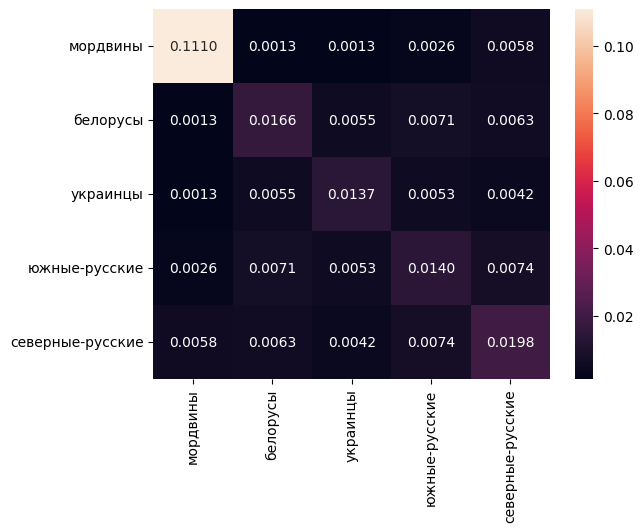

In [34]:
sns.heatmap(probs, annot=True, xticklabels=types, yticklabels=types, fmt='.4f')

In [201]:
df_processed[(df_processed.node_id1 == all_nodes[0]) | (df_processed.node_id2 == all_nodes[0])]

node_id1  node_id2  label_id1  label_id2   ibd_sum  ibd_n
0          0         5          0          0  29.81720      4
1          0        10          0          0  11.63220      1
2          0        11          0          0  23.90440      2
3          0        18          0          0  11.25290      1
4          0        20          0          0   8.88252      1
5          0        22          0          0   8.83162      1
6          0        23          0          0   8.68091      1
7          0       357          0          3   8.06633      1
8          0       663          0          4   9.49832      1
9          0       791          0          1   8.85877      1
10         0      1142          0          4   8.67970      1
11         0      1370          0          3   8.55866      1
12         0      1464          0          4   8.38051      1
13         0      1754          0          3   8.06633      1
14         0      1914          0          2  12.47290      1
15         0      2202          0          3   8.26762      1
16         0        58          0          0   9.73823      1
17         0        73          0          0   9.81949      1
18         0      2276          0          0   9.43231      1
19         0      2424          0          3  11.22040      1
20         0      2764          0          1  11.07410      1
21         0      3147          0          3   9.68256      1
22         0      3163          0          3  11.31730      1

In [202]:
# accuracy by the biggest weight
preds_max = []
real = []
for i in range(len(all_nodes)):
    df_cp = df_processed[(df_processed.node_id1 == all_nodes[i]) | (df_processed.node_id2 == all_nodes[i])]
#     print(df_cp.ibd_sum)
    df_cp_max = df_cp.iloc[np.argmax(df_cp.ibd_sum), :].to_numpy()
#     print(df_cp_max)
    if df_cp_max[0] == all_nodes[i]:
        preds_max.append(df_cp_max[3])
        real.append(df_cp_max[2])
    if df_cp_max[1] == all_nodes[i]:
        preds_max.append(df_cp_max[2])
        real.append(df_cp_max[3])

In [203]:
sum(np.array(real) == np.array(preds_max)) / len(all_nodes)

0.7382532519246084

In [204]:
hashmap = np.array([1e6 for i in range(len(all_nodes)+100)]).astype(int)
for i, node in enumerate(all_nodes):
    hashmap[node] = i

nf = np.zeros((len(all_nodes), len(types)*2))
targets = np.zeros(len(all_nodes))

In [205]:
@njit(cache=True)
def get_node_features_for_comprehensive_analysis(features_array, df, hashmap, types, targets):
    for i in range(df.shape[0]):
        row = df[i]
        
        features_array[hashmap[int(row[0])], int(row[3])] += row[4] 
        features_array[hashmap[int(row[1])], int(row[2])] += row[4] 
        features_array[hashmap[int(row[0])], int(row[3]) + len(types)] += 1
        features_array[hashmap[int(row[1])], int(row[2]) + len(types)] += 1
        
        targets[hashmap[int(row[0])]] = int(row[2])
        targets[hashmap[int(row[1])]] = int(row[3])

In [206]:
get_node_features_for_comprehensive_analysis(nf, df_processed.to_numpy(), hashmap, types, targets)

In [207]:
print(nf.shape)
print(targets)

(3767, 10)
[0. 0. 0. ... 1. 2. 1.]


In [208]:
sum_ibd = nf[:, :len(types)]
num_edges = nf[:, len(types):]
mean_ibd = sum_ibd / num_edges
print(np.sum(np.isinf(mean_ibd)))
mean_ibd = np.nan_to_num(mean_ibd)
mean_ibd.shape

0


C:\Users\Alex\AppData\Local\Temp\ipykernel_11188\353761808.py:3: RuntimeWarning: invalid value encountered in true_divide
  mean_ibd = sum_ibd / num_edges


(3767, 5)

In [209]:
# np.sum((np.argmax(sum_ibd, axis=1) == targets) | (np.argmax(num_edges, axis=1) == targets) | (np.array(real) == np.array(preds_max)))

wrong_nodes = np.array(all_nodes)[(np.argmax(sum_ibd, axis=1) != targets) & (np.argmax(num_edges, axis=1) != targets) & (np.array(real) != np.array(preds_max))]
wrong_nodes

array([   9,   18,   33,   34,   37,   38,   39,   40,   44,   47,   54,
        137,  140,  146,  153,  157,  168,  174,  183,  187,  189,  202,
        215,  227,  231,  235,  257,  267,  268,  270,  274,  291,  299,
        316,  323,  328,  338,  343,  344,  345,  350,  373,  374,  378,
        392,  400,  409,  410,  413,  414,  417,  420,  428,  442,  458,
        467,  472,  491,  518,  544,  564,  581,  583,  584,  595,  599,
        612,  621,  622,  625,  638,  644,  648,  649,  651,  659,  661,
        663,  664,  665,  669,  689,  703,  712,  717,  721,  730,  732,
        734,  738,  751,  752,  765,  770,  774,  782,  785,  791,  793,
        806,  807,  819,  825,  829,  832,  837,  838,  839,  841,  843,
        847,  849,  857,  863,  865,  892,  898,  900,  901,  902,  903,
        915,  922,  924,  929,  931,  937,  949,  950,  973,  974,  981,
        983,  994, 1000, 1013, 1015, 1020, 1021, 1026, 1036, 1043, 1049,
       1055, 1071, 1076, 1078, 1093, 1111, 1114, 11

In [175]:
types

['мордвины', 'белорусы', 'украинцы', 'южные-русские', 'северные-русские']

In [184]:
deg = []
for id in range(len(wrong_nodes)):
    deg_tmp = df_processed[(df_processed.node_id1 == wrong_nodes[id]) | (df_processed.node_id2 == wrong_nodes[id])].shape[0]
    deg.append(deg_tmp)
    
np.mean(deg)

29.351791530944624

In [215]:
id = 4
print(wrong_nodes[id])
df_processed[(df_processed.node_id1 == wrong_nodes[id]) | (df_processed.node_id2 == wrong_nodes[id])]

37


node_id1  node_id2  label_id1  label_id2   ibd_sum  ibd_n
572        37        40          2          1  10.60450      1
573        37       352          2          3   8.71206      1
574        37       707          2          3   8.00956      1
575        37       929          2          4   8.85902      1
576        37      1259          2          1   8.56828      1
577        37      1428          2          2  12.30890      1
578        37      1641          2          4   9.34458      1
579        37      1761          2          3   8.24403      1
580        37      1766          2          3   8.54424      1
581        37      1832          2          3   8.10836      1
582        37      2121          2          1  14.66050      2
583        37      2589          2          3   8.47485      1
584        37      2886          2          3  14.57870      1
585        37      3458          2          3   8.23779      1
586        37       118          2          2   8.00974      1

In [141]:
tmp = df_processed[(df_processed.node_id1 == 316) | (df_processed.node_id2 == 316)]
print(tmp.shape)
tmp

(8, 6)


node_id1  node_id2  label_id1  label_id2   ibd_sum  ibd_n
1866       271       316          4          0   8.40805      1
2609       316       322          0          0  23.70520      3
2610       316       370          0          0   8.59319      1
2611       316       380          0          0   8.03535      1
2612       316       490          0          0   8.96111      1
2613       316       528          0          0   9.39301      1
2614       316       594          0          0  10.81780      1
2615       316       630          0          0   8.07588      1

In [142]:
tmp = df_processed[(df_processed.node_id1 == 326) | (df_processed.node_id2 == 326)]
print(tmp.shape)
tmp

(41, 6)


node_id1  node_id2  label_id1  label_id2   ibd_sum  ibd_n
1867       271       326          4          3   9.09630      1
2113       297       326          3          3   8.38710      1
2336       306       326          3          3  23.16960      3
2387       307       326          1          3   8.51561      1
2401       308       326          3          3  22.96360      2
2568       315       326          3          3   8.76768      1
2695       325       326          0          3  10.28830      1
2738       326       330          3          0  10.85940      1
2739       326       331          3          1  13.92750      1
2740       326       338          3          3  24.07330      3
2741       326       339          3          0  16.94500      2
2742       326       344          3          2  10.71520      1
2743       326       361          3          3  17.60210      2
2744       326       362          3          0  10.31550      1
2745       326       365          3          3  32.73180      4
2746       326       375          3          5   9.05705      1
2747       326       377          3          3  23.78190      3
2748       326       385          3          3  46.95100      6
2749       326       387          3          0  17.27490      1
2750       326       396          3          0   8.72722      1
2751       326       410          3          3  35.59420      4
2752       326       426          3          0  14.87060      2
2753       326       452          3          5  13.36850      1
2754       326       478          3          0  21.28810      2
2755       326       491          3          0   8.68460      1
2756       326       492          3          3  42.17140      4
2757       326       518          3          3  15.95030      2
2758       326       527          3          5   8.46135      1
2759       326       544          3          3  31.94510      4
2760       326       560          3          3   9.02509      1
2761       326       562          3          3  61.14200      8
2762       326       580          3          0  10.92720      1
2763       326       582          3          0   8.07926      1
2764       326       589          3          3  44.56410      5
2765       326       598          3          5  13.36850      1
2766       326       608          3          3   8.08553      1
2767       326       610          3          3  10.24350      1
2768       326       622          3          3   8.80473      1
2769       326       623          3          3  12.37470      1
2770       326       625          3          5  10.87320      1
2771       326       627          3          0   9.48169      1

In [143]:
tmp = df_processed[(df_processed.node_id1 == 339) | (df_processed.node_id2 == 339)]
print(tmp.shape)
tmp

(60, 6)


node_id1  node_id2  label_id1  label_id2   ibd_sum  ibd_n
207         24       339          1          0   8.47770      1
1868       271       339          4          0   8.49134      1
2115       297       339          3          0  37.67490      4
2168       299       339          0          0  59.90570      6
2403       308       339          3          0   8.65155      1
2453       309       339          0          0   9.70384      1
2638       319       339          0          0  15.35180      2
2699       325       339          0          0  32.14540      4
2741       326       339          3          0  16.94500      2
3109       338       339          3          0   9.55630      1
3153       339       342          0          0  37.70800      5
3154       339       346          0          4  10.88770      1
3155       339       349          0          0  19.69140      2
3156       339       359          0          0  15.33810      2
3157       339       361          0          3  29.68500      4
3158       339       362          0          0  16.07000      2
3159       339       365          0          3  12.29430      1
3160       339       367          0          3  18.28380      1
3161       339       370          0          0   8.09916      1
3162       339       371          0          1  11.97100      1
3163       339       377          0          3   8.34111      1
3164       339       378          0          0  45.21540      5
3165       339       380          0          0  12.33530      1
3166       339       383          0          0  36.20070      4
3167       339       385          0          3  18.81700      2
3168       339       387          0          0  18.32330      2
3169       339       396          0          0  53.96590      5
3170       339       404          0          0  13.27430      1
3171       339       410          0          3  13.24270      1
3172       339       416          0          0  33.76530      4
3173       339       419          0          0  25.43210      3
3174       339       420          0          0  18.40300      1
3175       339       426          0          0  23.34730      3
3176       339       478          0          0  37.15550      4
3177       339       488          0          3  29.89970      4
3178       339       490          0          0   8.26984      1
3179       339       491          0          0  68.22300      8
3180       339       492          0          3  14.14830      2
3181       339       526          0          3  17.44060      2
3182       339       528          0          0  23.25190      3
3183       339       536          0          0  29.79460      4
3184       339       543          0          0  15.52340      2
3185       339       546          0          0  35.12300      3
3186       339       549          0          2  10.29370      1
3187       339       550          0          0  35.41570      5
3188       339       556          0          3   8.56228      1
3189       339       572          0          3  27.00010      3
3190       339       574          0          0   8.86739      1
3191       339       579          0          3  14.77450      2
3192       339       582          0          0  45.72000      6
3193       339       590          0          4   8.61433      1
3194       339       594          0          0  54.64150      6
3195       339       599          0          0  44.17700      5
3196       339       601          0          3   8.05200      1
3197       339       605          0          3   8.27618      1
3198       339       610          0          3  20.42150      2
3199       339       611          0          0  12.64230      1
3200       339       616          0          0   9.55016      1
3201       339       618          0          0  41.37540      5
3202       339       623          0          3  26.24190      3

In [106]:
False == False

True

In [107]:
im_targets = np.argmax(mean_ibd, axis=1)
im_targets

array([0, 0, 0, ..., 1, 2, 1], dtype=int64)

In [108]:
np.sum(im_targets == targets) / len(all_nodes)

0.5683567825856118

In [15]:
wrong_answers = im_targets != targets
nf_wrong = nf[wrong_answers]
targets_wrong = targets[wrong_answers]

C:\Users\Alex\AppData\Local\Temp\ipykernel_42740\2112597899.py:8: RuntimeWarning: invalid value encountered in true_divide
  ax3.plot(nf_wrong[id, :len(types)] / nf_wrong[id, len(types):])


<Figure size 640x480 with 0 Axes>

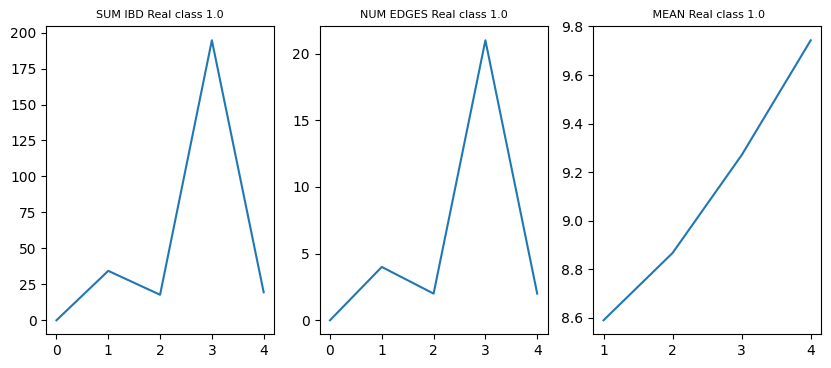

In [17]:
id = 100
targets_wrong_current = targets_wrong[id]

plt.clf()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(nf_wrong[id, :len(types)])
ax2.plot(nf_wrong[id, len(types):])
ax3.plot(nf_wrong[id, :len(types)] / nf_wrong[id, len(types):])
ax1.set_title(f'SUM IBD Real class {targets_wrong_current}', fontsize=8)
ax2.set_title(f'NUM EDGES Real class {targets_wrong_current}', fontsize=8)
ax3.set_title(f' MEAN Real class {targets_wrong_current}', fontsize=8)
plt.show()

In [74]:
# syntens = [16, 20, 12, 18, 14, 17, 15, 6, 8, 19, 11, 13, 10, 4, 5, 2, 7, 3, 1, 9]
# syntens = [1, 7, 6, 10, 9, 8, 2, 11, 3, 5, 4]
# signs = [1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1]

syntens = [2, 6, 8, 17, 7, 14, 18, 3, 5, 16, 11, 19, 4, 10, 13, 20, 1, 9, 12, 15]
signs = [1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1]

+2 +6 -8 -17 +7 -14 +18 +3 -5 -16 -11 -19 -4 +10 +13 -20 -1 +9 -12 +15

print(np.array(syntens) * np.array(signs))

counter = 1
num_reversals = 0
while counter != len(syntens)+1:
#     if signs[counter-1] > 0 and syntens[counter-1] == counter:
#         num_reversals += 1
    if syntens[counter-1] != counter:
        signs[counter-1:syntens.index(counter)+1] = list(-np.array(signs[counter-1:syntens.index(counter)+1][::-1]))
        syntens[counter-1:syntens.index(counter)+1] = syntens[counter-1:syntens.index(counter)+1][::-1]
        num_reversals += 1
        print(counter, np.array(syntens) * np.array(signs))
    if signs[counter-1] < 0:
        signs[counter-1] *= -1
        num_reversals += 1
        print(counter, np.array(syntens) * np.array(signs))

    counter += 1
    
    
print(syntens, num_reversals, signs, counter)

[  2   6  -8 -17   7 -14  18   3  -5 -16 -11 -19  -4  10  13 -20  -1   9
 -12  15]
1 [  1  20 -13 -10   4  19  11  16   5  -3 -18  14  -7  17   8  -6  -2   9
 -12  15]
2 [  1   2   6  -8 -17   7 -14  18   3  -5 -16 -11 -19  -4  10  13 -20   9
 -12  15]
3 [  1   2  -3 -18  14  -7  17   8  -6  -5 -16 -11 -19  -4  10  13 -20   9
 -12  15]
3 [  1   2   3 -18  14  -7  17   8  -6  -5 -16 -11 -19  -4  10  13 -20   9
 -12  15]
4 [  1   2   3   4  19  11  16   5   6  -8 -17   7 -14  18  10  13 -20   9
 -12  15]
5 [  1   2   3   4  -5 -16 -11 -19   6  -8 -17   7 -14  18  10  13 -20   9
 -12  15]
5 [  1   2   3   4   5 -16 -11 -19   6  -8 -17   7 -14  18  10  13 -20   9
 -12  15]
6 [  1   2   3   4   5  -6  19  11  16  -8 -17   7 -14  18  10  13 -20   9
 -12  15]
6 [  1   2   3   4   5   6  19  11  16  -8 -17   7 -14  18  10  13 -20   9
 -12  15]
7 [  1   2   3   4   5   6  -7  17   8 -16 -11 -19 -14  18  10  13 -20   9
 -12  15]
7 [  1   2   3   4   5   6   7  17   8 -16 -11 -19 -14  18  10  13 

In [68]:
a = -np.array([1, 2, -3, 4, -5, 6, 7, 8])
a[4:1:-1]

array([ 5, -4,  3])

In [77]:
np.arange(0,1_000_000-4000-1,1000)

array([     0,   1000,   2000,   3000,   4000,   5000,   6000,   7000,
         8000,   9000,  10000,  11000,  12000,  13000,  14000,  15000,
        16000,  17000,  18000,  19000,  20000,  21000,  22000,  23000,
        24000,  25000,  26000,  27000,  28000,  29000,  30000,  31000,
        32000,  33000,  34000,  35000,  36000,  37000,  38000,  39000,
        40000,  41000,  42000,  43000,  44000,  45000,  46000,  47000,
        48000,  49000,  50000,  51000,  52000,  53000,  54000,  55000,
        56000,  57000,  58000,  59000,  60000,  61000,  62000,  63000,
        64000,  65000,  66000,  67000,  68000,  69000,  70000,  71000,
        72000,  73000,  74000,  75000,  76000,  77000,  78000,  79000,
        80000,  81000,  82000,  83000,  84000,  85000,  86000,  87000,
        88000,  89000,  90000,  91000,  92000,  93000,  94000,  95000,
        96000,  97000,  98000,  99000, 100000, 101000, 102000, 103000,
       104000, 105000, 106000, 107000, 108000, 109000, 110000, 111000,
      

# Check isomorphism (september 2023)

In [38]:
df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
df

node_id1   node_id2 label_id1 label_id2   ibd_sum  ibd_n
0         node_0     node_5  мордвины  мордвины  29.81720      4
1         node_0    node_10  мордвины  мордвины  11.63220      1
2         node_0    node_11  мордвины  мордвины  23.90440      2
3         node_0    node_18  мордвины  мордвины  11.25290      1
4         node_0    node_20  мордвины  мордвины   8.88252      1
...          ...        ...       ...       ...       ...    ...
67498  node_3741  node_3752  белорусы  белорусы   9.51327      1
67499  node_3745  node_3755  белорусы  белорусы   9.23221      1
67500  node_3749  node_3764  белорусы  белорусы  10.63310      1
67501  node_3754  node_3755  украинцы  белорусы   8.04722      1
67502  node_3758  node_3766  белорусы  белорусы   8.77936      1

[67503 rows x 6 columns]

In [39]:
# concatenate all nodes in one column
n = pd.concat([df['node_id1'], df['node_id2']], axis=0)

# concatenate all labels in one column
l = pd.concat([df['label_id1'], df['label_id2']], axis=0)

# merge all nodes and all labels column-wise
df_new = pd.concat([n, l], axis=1)

df_new = df_new.drop_duplicates()

types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
# get class for every node 
# df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))

df_new = dict(df_new.to_numpy())
df_new

{'node_0': 0,
 'node_1': 0,
 'node_2': 0,
 'node_3': 0,
 'node_4': 0,
 'node_5': 0,
 'node_6': 0,
 'node_7': 0,
 'node_8': 0,
 'node_9': 0,
 'node_10': 0,
 'node_11': 0,
 'node_12': 0,
 'node_13': 0,
 'node_14': 0,
 'node_15': 0,
 'node_16': 0,
 'node_17': 0,
 'node_18': 0,
 'node_19': 0,
 'node_20': 0,
 'node_21': 0,
 'node_22': 0,
 'node_23': 0,
 'node_24': 0,
 'node_25': 0,
 'node_26': 0,
 'node_27': 0,
 'node_28': 0,
 'node_29': 0,
 'node_30': 0,
 'node_31': 0,
 'node_32': 0,
 'node_33': 1,
 'node_34': 1,
 'node_35': 1,
 'node_36': 1,
 'node_37': 2,
 'node_38': 1,
 'node_39': 1,
 'node_40': 1,
 'node_41': 1,
 'node_42': 1,
 'node_43': 1,
 'node_44': 2,
 'node_45': 1,
 'node_46': 1,
 'node_47': 2,
 'node_48': 2,
 'node_49': 2,
 'node_50': 2,
 'node_51': 2,
 'node_52': 2,
 'node_53': 2,
 'node_54': 2,
 'node_135': 3,
 'node_136': 3,
 'node_137': 4,
 'node_138': 3,
 'node_139': 3,
 'node_140': 2,
 'node_141': 3,
 'node_142': 3,
 'node_143': 3,
 'node_144': 2,
 'node_145': 3,
 'node_14

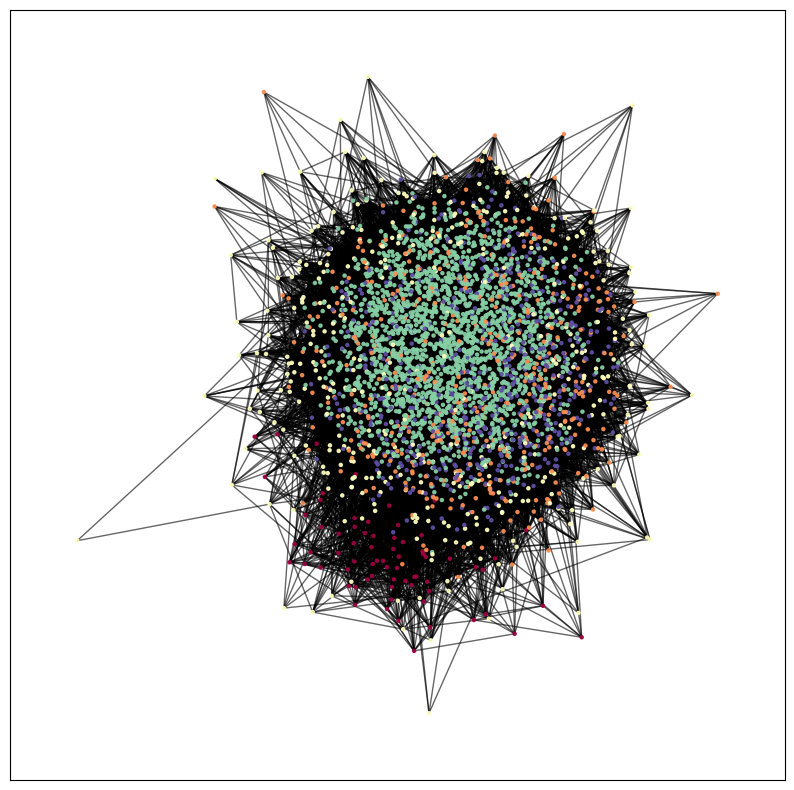

In [40]:
# code for visualization
G = nx.Graph()

G.add_edges_from(list(map(tuple, df.iloc[:, :2].to_numpy())))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

jet = plt.get_cmap('Spectral')

node_cols = []
for n in list(G.nodes):
    node_cols.append(df_new[n])

pos = nx.spring_layout(G)
sc = nx.draw_networkx_nodes(G, pos = pos, alpha=0.9, node_color=node_cols, cmap = jet, node_size=5)
nx.draw_networkx_edges(G, pos = pos, alpha=0.6)#, width=edge_wts)

In [18]:
if len(np.unique(df.iloc[:, :2].to_numpy())) < np.array(list(map(lambda x: int(x.split('_')[1]), list(np.unique(df.iloc[:, :2].to_numpy()))))).max():
        n = pd.concat([df['node_id1'], df['node_id2']], axis=0)
    
        # concatenate all labels in one column
        l = pd.concat([df['label_id1'], df['label_id2']], axis=0)

        # merge all nodes and all labels column-wise
        df_new = pd.concat([n, l], axis=1)

        # get class for every node 
        df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
        df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))

        if len(df_new.iloc[:, 0].unique()) < df_new.iloc[:, 0].max():
            print('Relabelling!!!')
            new_labels = {i:n for n, i in enumerate(df_new.iloc[:, 0].unique())}
    #         print(new_labels)
            for i in range(df.shape[0]):
                df.iloc[i, 0] = 'node_' + str(new_labels[int(df.iloc[i, 0].split('_')[1])])
                df.iloc[i, 1] = 'node_' + str(new_labels[int(df.iloc[i, 1].split('_')[1])])
df.iloc[:, 0] = df.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda n: int(n.split('_')[1]))
df

Relabelling!!!


node_id1  node_id2 label_id1 label_id2   ibd_sum  ibd_n
0            0         1   чеченцы   чеченцы   9.76537      1
1            0        13   чеченцы   чеченцы  26.49970      3
2            0        15   чеченцы   чеченцы   8.31678      1
3            0       528   чеченцы   чеченцы   8.64458      1
4            1         8   чеченцы   чеченцы   8.14209      1
...        ...       ...       ...       ...       ...    ...
6292       557       566    ингуши   осетины  11.24220      1
6293       557       574    ингуши   чеченцы  14.70900      2
6294       558       559   осетины   осетины   8.26460      1
6295       558       566   осетины   осетины   8.91348      1
6296       559       566   осетины   осетины  48.95750      6

[6297 rows x 6 columns]

In [15]:
G_networkx = nx.Graph()
G_torch_geometric_subgraph = nx.Graph()

G_networkx.add_edges_from(list(map(tuple, df.iloc[:, :2].to_numpy())))

G_torch_geometric_subgraph.add_edges_from(list(map(tuple, data_old.edge_index.cpu().numpy().T)))
G_networkx_subgraph = G_networkx.subgraph(tr)

In [75]:
data.x.sum(axis=0)

tensor([  8985.4217,  96878.7714,  67846.1944, 602433.4686, 108476.0053],
       dtype=torch.float64)

In [66]:
data_old.edge_index

tensor([[   0,    0,    0,  ..., 2634, 2634, 2634],
        [1956,  857, 1174,  ..., 2584, 1241,  451]], device='cuda:0')

In [47]:
np.array(tr)

array([2643, 1942,  835, ...,   32,   64, 2271], dtype=int64)

In [22]:
types

['Mordvins',
 'Belarusians',
 'Ukranians',
 'Southern Russians',
 'Northen Russians']

In [65]:
sel_node = 1942

df_only_for_debug = df[(df.iloc[:, 0] == sel_node) + (df.iloc[:, 1] == sel_node)]
df_only_for_debug = df_only_for_debug[(df_only_for_debug.iloc[:, 2] == 'южные-русские') * (df_only_for_debug.iloc[:, 3] == 'южные-русские')]
# df_only_for_debug.iloc[:, 4].sum()
training_mask = []
for row in df_only_for_debug.iloc[:, :2].to_numpy():
    if (row[0] not in tr) or (row[1] not in tr):
        training_mask.append(False)
    else:
        training_mask.append(True)
        
print(df_only_for_debug.shape)
print(df_only_for_debug[training_mask].shape)
        
print(df_only_for_debug[training_mask].iloc[:, 4].sum())
df_only_for_debug[training_mask]
# df_only_for_debug

(15, 6)
(13, 6)
135.73895000000002


C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


node_id1  node_id2      label_id1      label_id2   ibd_sum  ibd_n
866         138      1942  южные-русские  южные-русские  17.36170      1
4949        253      1942  южные-русские  южные-русские  11.86460      1
8809        362      1942  южные-русские  южные-русские   9.06332      1
11776       451      1942  южные-русские  южные-русские   8.56560      1
22378       776      1942  южные-русские  южные-русские   8.26935      1
23763       822      1942  южные-русские  южные-русские  11.38780      1
24627       852      1942  южные-русские  южные-русские  12.07400      1
25676       886      1942  южные-русские  южные-русские  11.74970      1
39613      1430      1942  южные-русские  южные-русские   9.32861      1
50208      1942      2280  южные-русские  южные-русские  10.10050      1
50209      1942      2380  южные-русские  южные-русские   8.86626      1
50210      1942      2402  южные-русские  южные-русские   9.05934      1
50211      1942      2880  южные-русские  южные-русские   8.04817      1

In [16]:
nx.could_be_isomorphic(G_torch_geometric_subgraph, G_networkx_subgraph)

True

In [17]:
nx.vf2pp_is_isomorphic(G_torch_geometric_subgraph, G_networkx_subgraph, node_label=None)

True

In [72]:
len(data.edge_index.cpu().T)

9092

In [73]:
len(G_torch_geometric_subgraph.edges())

4546

In [74]:
len(G_networkx_subgraph.edges())

4523

In [28]:
G = nx.path_graph(5000)
G.add_edge(2, 5)

H = nx.path_graph(5000)
H.add_edge(3, 5)

nx.vf2pp_is_isomorphic(G, H, node_label=None)

False

# More tests

In [447]:
data

Data(x=[426, 8], edge_index=[2, 5886], y=[426], weight=[5886], num_classes=8)

In [446]:
test_graphs[-1]

Data(x=[427, 8], edge_index=[2, 5894], y=[427], weight=[5894], num_classes=8)

In [17]:
np.array(mask_array)

array([False, False, False, ...,  True,  True,  True])

In [281]:
test_graphs[0].weight

tensor([10.1470, 15.2814,  8.3013,  ..., 16.0841, 10.5904,  9.1950],
       dtype=torch.float64)

In [27]:
test_graphs[0].edge_index

tensor([[   0,    0,    0,  ..., 2635, 2635, 2635],
        [ 880, 2328,  208,  ..., 2366, 2496, 2606]], device='cuda:0')

In [101]:
# import pickle

# with open('data_genotek.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('test_graphs_genotek.pickle', 'wb') as handle:
#     pickle.dump(test_graphs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [118]:
Phe = 'MVNSSKSILIHAQNKNGTHEEEQYLFAVNNTKAEYPRDKTIHQLFEEQVSKRPNNVAIVCENEQLTYHELNVKANQLARIFIEKGIGKDTLVGIMMEKSIDLFIGILAVLKAGGAYVPIDIEYPKERIQYILDDSQARMLLTQKHLVHLIHNIQFNGQVEIFEEDTIKIREGTNLHVPSKSTDLAYVIYTSGTTGNPKGTMLEHKGISNLKVFFENSLNVTEKDRIGQFASISFDASVWEMFMALLTGASLYIILKDTINDFVKFEQYINQKEITVITLPPTYVVHLDPERILSIQTLITAGSATSPSLVNKWKEKVTYINAYGPTETTICATTWVATKETIGHSVPIGAPIQNTQIYIVDENLQLKSVGEAGELCIGGEGLARGYWKRPELTSQKFVDNPFVPGEKLYKTGDQARWLSDGNIEYLGRIDNQVKIRGHRVELEEVESILLKHMYISETAVSVHKDHQEQPYLCAYFVSEKHIPLEQLRQFSSEELPTYMIPSYFIQLDKMPLTSNGKIDRKQLPEPDLTFGMRVDYEAPRNEIEETLVTIWQDVLGSHHHHHH'
Dhv = 'AKLLEQIEKWAAETPDQTAFVWRDAKITYKQLKEDSDALAHWISSEYPDDRSPIMVYGHMQPEMIINFLGCVKAGHAYIPVDLSIPADRVQRIAENSGAKLLLSATAVTVTDLPVRIVSEDNLKDIFFTHKGNTPNPEHAVKGDENFYIIYTSGSTGNPKGVQITYNCLVSFTKWAVEDFNLQTGQVFLNQAPFSFDLSVMDIYPSLVTGGTLWAIDKDMIARPKDLFASLEQSDIQVWTSTPSFAEMCLMEASFSESMLPNMKTFLFCGEVLPNEVARKLIERFPKATIMNTYGPTEATVAVTGIHVTEEVLDQYKSLPVGYCKSDCRLLIMKEDGTIAPDGEKGEIVIVGPSVSVGYLGSPELTEKAFTMIDGERAYKTGDAGYVENGLLFYNGRLDFQIKLHGYRMELEEIEHHLRACSYVEGAVIVPIKKGEKYDYLLAVVVPGEHSFEKEFKLTSAIKKELNERLPNYMIPRKFMYQSSIPMTPNGKVDRKKLLSEVTALEHHHHHH'
Ite = 'GSGAVSIASSKVSAQYTSTVPPSHYIETWAKTHPEWKAVEVATGFLGSQKIVTEDWTYKKLNETANQVANLIIHASLHGRAIAVSLDRSLIAFAIIVGIXKSGNTYVPIEAGLPNDRKSFLLRDSRAAXAFVCDNNFDGVELPPETKVLDTKNQSFIENLSTQDTSDILNNYPENLDAYLLYTSGSTGTPKGVRVSRHNLSSFSDAWGKLIGNVAPKSLELGGVGKFLCLASRAFDVHIGEXFLAWRFGLCAVTGERLSXLDDLPRTFRELGVTHAGIVPSLLDQTGLVPEDAPHLVYLGVGGEKXTPRTQQIWSSSDRVALVNVYGPTEVTIGCSAGRILPDSDTRCIGHPLGDSVAHVLAPGSNEHVKKGXAGELVIEGSLVANGYLNRPDAKGFCDINGRKXYRTGDIVRXDADSSILFLGRKDEQVKVRGQRLELGEVSEVIRSLSPTDIDVVTLLLNHPGTSKQFLVSFVASSGAAVRGELRWINENYKEINNSLRQACEQTLPAYXVPDFIIPISFIPLRDTSAKTDAKALEHXFHTLSLGELFGESSSLVNKPTT'
Vsq = 'MSQFSKDQVQDMYYLSPMQEGMLFHAILNPGQSFYLEQITMKVKGSLNIKCLEESMNVIMDRYDVFRTVFIHEKVKRPVQVVLKKRQFHIEEIDLTHLTGSEQTAKINEYKEQDKIRGFDLTRDIPMRAAIFKKAEESFEWVWSYHHIILDGWCFGIVVQDLFKVYNALREQKPYSLPPVKPYKDYIKWLEKQDKQASLRYWREYLEGFEGQTTFAEQRKKQKDGYEPKELLFSPSEAETKAFTELAKSQHTTLSTALQAVWSVLISRYQQSGDLAFGTVVSGRPAEIKGVEHMVGLFINVVPRRVKLSEGITFNGLLKRLQEQSLQSEPHQYVPLYDIQSQADQPKLIDHIIVFENYPLQDAKNEESSENGFDMVDVHVFEKSNYDLNLMASPGDEMLIKLAYNENVFDEAFILRLKSQLLTAIQQLIQNPDQPVSTINLVDDREREFLLTGLNPPAQAHETKPLTYWFKEAVNANPDAPALTYSGQTLSYRELDEEANRIARRLQKHGAGKGSVVALYTKRSLELVIGILGVLKAGAAYLPVDPKLPEDRISYMLADSAAACLLTHQEMKEQAAELPYTGTTLFIDDQTRFEEQASDPATAIDPNDPAYIMYTSGTTGKPKGNITTHANIQGLVKHVDYMAFSDQDTFLSVSNYAFDAFTFDFYASMLNAARLIIADEHTLLDTERLTDLILQENVNVMFATTALFNLLTDAGEDWMKGLRCILFGGERASVPHVRKALRIMGPGKLINCYGPTEGTVFATAHVVHDLPDSISSLPIGKPISNASVYILNEQSQLQPFGAVGELCISGMGVSKGYVNRADLTKEKFIENPFKPGETLYRTGDLARWLPDGTIEYAGRIDDQVKIRGHRIELEEIEKQLQEYPGVKDAVVVADRHESGDASINAYLVNRTQLSAEDVKAHLKKQLPAYMVPQTFTFLDELPLTTNGKVNKRLLPKPDQDQLAEEWIGPRNEMEETIAQIWSEVLGRKQIGIHDDFFALGGHALKAMTAASRIKKELGIDLPVKLLFEAPTIAGISAYLKNGGSDGLQDVTIMNQDQEQIIFAFPPVLGYGLMYQNLSSRLPSYKLCAFDFIEEEDRLDRYADLIQKLQPEGPLTLFGYSAGCSLAFEAAKKLEEQGRIVQRIIMVDSYKKQGVSDLDGRTVESDVEALMNVNRDNEALNSEAVKHGLKQKTHAFYSYYVNLISTGQVKADIDLLTSGADFDIPEWLASWEEATTGVYRMKRGFGTHAEMLQGETLDRNAEILLEFLNTQTVTVSKGEFEAYVEQKLISEEDLNSAVDHHHHHH'
Abw = 'MTAADYPQATDTRCFPPSPAQAGLWFASTYGTDPTAYNQPLVLRLGTLVDHTLLHRALRLVHREHCALRTTFDMDADGELRQIVHGELEPIVDVRVHAGGDSEAWVAEQVEQVAATVFDLRRGPLARVRHLRLVAEGRSLLVFNIHHTVFDGLSWKPYLSRLEAVYTALARGQEPPRKPRRQAVEAYARWSERWADSGSLSHWLDKLADAPAAAPVGLPGEGPARHVTHKAVLDDRLSAQVKTFCATEGITTGMFFAALAFVLLHRHTGQDDILLGVPVTVRGSGDAEVVGHLTNTVVLRHRLAPGATARDVLHAVKRDMLDALRHRHVPLEAVVGELRALGGGKDGVGDLFNAMLTVMPASARRLDLREWGVETWEHVSGGAKYELAVVVDETPGRYTLVVEHTSASAGAGSLAAYLARRLETLVRSVMADPDTDVRRLRWVSAEEERAVTGLCARRQDAPELGTEVTADLFAEAAAAAAADPAVVADGVVTSYAELARQADAVAADLAARGVRDGRPVAVLMRPGLDLVATVVGILRAGGSYVVLDADQPRERLSFALADSGAKILLHDPDADLAGVRLPDGMQTATMPGTEGGVVLEPGRRKSPDDQVYVVYTSGSTGRPKGVVLLEPTLTNLVRNQAVLSSHRRMRTLQYMPPAFDVFTLEVFGTLCTGGTLVVPPPHARTDFEALAALLAEQRIERAYFPYVALRELAAVLRSSGTRLPDLREVYVTGERLVVTEDLREMFRRHPGARLINAYGPSEAHLVSAEWLPADPDTWPAVPPIGRVVAGLDARVLLEGDEPAPFGVEGELCVAGPVVSPGYIGLPEKTRQAMVPDPFVPGQLMYRTGDVVVLDPDGRLHYRGRADDQIKIRGYRVEPGEVEAALERVLHVEAAAVIAVPAGHDRALHAFVRSGQEPPSNWRSRLGTVLPGYMIPRGITRVDAIPVTPNGKTDRRALEARLADRAGTEPAGGGGMDWTDCERAIADLWTEVLGHGPATPDDDFFELGGHSLLAARLHRLVRQRLDSDVPLSVLLGTPTVRGMAGSLAGRGASGTVDLREEARLHDLVVGERREPADGAVLLTGATGFLGSHLLDELQRAGRRVCCLVRAGSVEEARGRLRAAFEKFALDPSRLDRAEIWLGDLARPRLGLGDGFAARAHEVGEVYHAAAHINFAVPYHTVKRTNVDGLRRVLDFCGVNRTPLRLISTLGVFPPDSAPGVIGEDTVPGDPASLGIGYSQSKWVAEHLALQARQAGLPVTVYRVGRIAGHSRTGACRHDDFFWLQMKGFALLGRCPDDIADAPAVDLLPVDYVARAIVRLAEGKPDDANWHLYHPQGLAWSVILETIRAEGYAVSPATRSAWLAALERQAGTEAQGQGLGPLVPLMREGAMRLGSHSFDNGRTMRAVADVGCPCPPADTEWIRRMFEYFRAIGSVPPPDGVTLGGHVA'
Np7 = 'MAKSGLEDILPLSPLQEGMLFHNLFDEEELDAYNVQVFIDLEGGTDPERLRRAGQALLERHANLRAAFRHEGLKRPVQLIPRRVVLPWGEEDLSGVAEPEREAAAERVAERDRWTRFDLSRPPLIRFTLVRLGPARHRLLLTLHHILADGWSMPILLRELMTLYTVHGDGTALPRVRPYRDYLGWLGGRDRDAARQAWTEAFAGLDAPSIVAPGRGALTAAPERIDFSEDEAASAALTRFARSNGLTVNTVIQGCWGLVLSHLTGRDDVVFGVTVSGRPPELPGIDTMVGLFMNTLPLRVRLRPAETLTGFLRRLQGEQARLIDHQWVGLAEIQRWAGSGELFDTAMVFENYPLNSSRGRPPGAAPDADLPTVLGVRSKDQMHYPLGLLALPRETLRFSLGYLPQVFDPARVEAVIAAFRRALRTVLDAPDTRVGAVALLDPEVRGTVLEKWSGSDDVRPAERFTDLFEEQVARTPGKTALIAPDGRLTYAELDAAANRLARRLVELGVGPERHVAVAVGRRTELVVGMLAVLKAGGAYVPVDPEYPPDRIRHMIQDADPALVLTTSDVDDRIGEECCGPLTFVMDDPNTGTSLGRHSGTALTDADRAAPLLPGHPAYVIYTSGTTGRPKGVVVEHRALSAFVRHCRSSQAPDISGLSVMQASASFDQSVGSLHAPLISGGCVRLTDLRALAETAGSEPGFHRATFMKGTPSHLALLATMPPEVAPSGTLTLGGEELRGEILAPWREAAGDVTVVNVYGPTEATGHCLEHWIAPDRTVEPGPVPIGTPHEGVRVYVLDSALRPVAPGLDGEVYLAGVQLARGYLGRGGLTAERFTADPFGAPGSRMYRTGDVAHWNEAGELVFAGRADRQVKLRGYRIELGEIEAAVAGGPGVRQAAVVLREDRPGDQRLVAYVVPDPGHWDEAAARARLALSLPDFMMPSAFVALDALPLSPNGKLDRAALPAPTYTGRTAGRAPRTPAEEILCDLYAEVLSLPGVTVDDDFFDLGGHSLLATRLVSRVRTTLGAELSIRQFFEAPTPAALAVVLAGAGRARAALTARPRPERLPLSYAQQRLWFLHLLEGPSPTYNIPTVLRLSGPLRPDALRAALLDVVGRHESLRTTFTEDERGARQVVHPADGVRPVFETAESTEADYEADLARAARHAFDLGAEIPVRARLLRLSEREHVLLLLVHHIASDAWSRGPLAQDLTAAYTARCAGDAPAWQPLPVQYADYALWQQEILGDDTDPDTLAGRQLAYWKQQLAGLPERLDLPTDRPRPATADHTGDRVEFALPADLHTRLTELARATDTTLYMVLQAALATLLTRHGAGEDIPIGTPVAGRTDDATDHLVGFFVNTLVLRTDTSGNPTFRDLLTRVRDTDLTAYTHQDLPFERLVEALNPTRSLTHHPLFQVVLSLRSTAPRRADGEGAPALPGGLRVSGTGGAAATAAKVDLGFSVTERRAADHTPDGVAGVLDFRTDLFDRGTAQGLVDRLVRVLADAAAHPDRPLSRIDVLGPRERHRVVEEWNATAKGLAPATLPELFERHVRERPGAEAVVAGDTSLSYAELNARANRLARLLVARGAGPERLVALALPRSAELPVAVLAVAKAGAAYLPLDPAHPAERIAGTLDDAAPVALLTTAAVAAGLPDTDVPRLLLDEEPAAGGGEDAADLTDADRLAPLLPGHPAYVIYTSGTTGRPKGVTVTHSGLPALLDIFTSQLDVVPGSRVLHHLSPAFDGGFWELAMGLLTGAALVVVEPGTVPGPALAALAVRHRVTHAAITPAVLQLIPEGALPAGTTLVVAAETCPPELVARWSAGRLMRNSYGPTETTVCATMSAPLAGAAVPPIGRPIADTAGYVLDDALQPVPPGVPGELYVRGPGLARGYLGRPSLTAGRFVACPFGPAGGVMYRTGDLVRHRADGDLEYLGRTDTQVKLRGMRVEPAEIEAVTAGLPGVAQAAVLVREDTPGDRRLVGYVVPDAGASVDPGALRQALRGSLPEYMVPAALVVLDALPLTTNGKLDHRALPAPEYRTVEGRSPRTPREEALCRLFAEVLGLELVGLDDGFFDLGGHSLLAIRLVERVRAELGEELGVRDLFAAPTVADLAVRLAARGGREPMERLLPLRAAGTARPVFCVHPGSGMSWCYSGLVRHLPPGIPVYGLQAAGLDGDGPLPATLQEMAAEYADLVRQTQPEGPYRLLGWSLGGNVAFAMARELRARGQEVELLAFLDAYPRRAGAGPEAPLAEVFAHNLRDAGFDVAEEELTGGRFPTARYRAFLNAAGDPMGRLDEAELAAVLEVFMNNAALMRGHTPGTYDGDVLVLAAERADGDKLARRGAESWRPHVRGRIERVGVDADHLGLVQSDAALAVIGRALAGRLDPATGHAASAAVPETEGVTAMNPSPEPAPSPESLDSTEVA'
Yp5 = 'MAKLALSAAQHGIWLGQQLDPSSPLYNTAEYVALRGAVELTNLTAAIKQAFAEAATLHLRFGLEHDQPYALVEPQPINLTVHDLRDLPDAEVRAIAWMQHDLGNVVDLATGPLFNTAILQLADDQVWWYLRAHHIALDGYSFALLTKRVAEIYSALQTKATLSPSFGELVPVIAEDHAYQVSIQATLDREFWVNRFADNPQVVSLTQQTALSQPRSIRLSTALANDLIERLTAIAKPSRSTWPDALMAVVAAYLARWNNSESVVLGMPLMSRLGSVALRVPCMAMNIVPLCLNVAAEHDLAQLTAVVAAERNAFRKHGRYRYEQLRRDLGFVGAGRRLFGPVVNIMPFDHPLNFGDCQAQSTTLTAGPVEDLAFNVILRGNQLYLTLEANPACYSQAALEYHFAAIQHLLNGWLANPSIPVAEQQVLPAPLVLDGGELRLPLTSVIERILHNARQQPHALALVTDTEQLSYAELASHVHAWAGQLVQRGVTAGSVVGVALPRSREAIVAILATLCCGAAYLPLDPQWPQSRLASVVAQAQPVLVLAQQAFDLPNLLLVEQLSKANAWFEARVDLAQPAYIMYTSGSTGEPKGVVISHQALAGFVQAAAERYAISAADRVLQFAPLAFDASVEEIFVTLCQGATLVLRNDAMLESLQRFVAACQAHAISVLDLPTAFWHELADSVAQGAVQLPECLRVVIIGGEAALPERVQGWLNVVAPNVRLFNTYGPTEATVVATVAELSDPNQPITIGRPLAGVQAAILGSDQRPIFAGDVGDLYLLGNGLATGYYQRPDLDALNFGQLSQLPHAPRAYRTGDRVRLFAGQLQFVGRSDDEFKISGQRVTPAEIESVFLRHTAVREVAVIGQQLGNASKRLFAAVVVSDASLSVAELRNHASQHLPAAVIPAAITIVERLPRSSAGKIDRKAVAALAPAPVMVNAAINDTPALIRQVWAEVLGQTEFNDEADFFGLGGQSLQTIQVANRLGMALGREVTAALIFRYPTIAGLSQALDPEFEQAPEAAPQFLSDANLPEQIVPKQLNAQPRPIQTVLLTGATGFVGAHLLAELLSTTTTNVICVVRAGSNAAAFERLQASLQHYELPSEQLAEQVEAWQGDLAQPQFGLDDQQWQSLIERCDLIYHNAAMVSVVREYSSLRAVNVNATSEILRLAAVHCTPVHYVSTLAVSPPQSVMHRVPEDFVAAHAGLRDGYSQSKWVAERLLEQAATRGLPVAVYRLGRVVGPNQSNFVNQDDLFWRIVQAGVPRGLLPSLPVEEIWNPVDFAAQTIVQFSHNHRGVRVYNLAPNEPISFAQLLGWVGEYGYAVQLCRVEQWYQALRNADDAMSQATLTFFERQADGGELPSAIGTIENKRLLQTLAAHGIAVPVIDRERFFGYLERCIRTGLLPAPDLRQTSIGIR'
Yp0 = 'MSTDGTRDLTARRRELLRRRMADENLLHTSDPEPETAAPAGERPLSPGQQRMWSIQQLDPLTVGYNVTIALDVSGELDADLLGQALELVVARHDILRTVYRLTDDGTGDGQSRVVQVVQDQFTAPYDVCDVRDLDEAARAARVGELARAVAGQPFDLATDPPLRVRLIRTGEASSTLVVVAHHIVWDDGTSAVFFGQLMDDYRRLLSGERVVARRSPRQYADVALGSHGAAGVDDSALAHWRDELTPLPELLDLPGISGGAGGAGQERSHPMREGTGRRVREIARREGASTFMVLFAAVSALLHRYTGAREFLVGAPVVNRDFPGAEDVVGYLGNTIPLRAEVDPSDDFRTLLARSRATCVDAYAHQHVELDDIAKAADAQRFRGDAGLFNVVLSLRSPVLEPFRAAGLQVGRRHVPGTDARFDLTLAVETDGDELAVEANYPARHDADDQVRGLLEHLDRLLDAALADPATPVGELELLAPGERERLLHECNDTATRTDERLLPERFKAQVALTPDALAVTAPGEEAGTELTYAELNARANRLARELVGRGIGPEHVVALAVPRSPAMMVAALAVLKAGAAYVPVDPSYPAERVRLMLADSSPALLLATCTVAAELPDGGVRRLLLDDPEVAEQVAALPGTDLADSDRNAPLLPGHPAYVIYTSGSTGTPKGVVVAHRALSNHLDWAVRRFAGLGGRTLLHSSMSFDFSVTPMYGPLLCGGVLELCEDSPDAIANATGPATFLKITPSHLPLLPSVRFAAEGPRTLVIAGESLHGESLVDRQPPEGEGLDVINEYGPTETTVGCTLHDIPFADGAPAGPVPIGRPVANTRCHVLDQALRPVPAGVPGELYIGGSQLARGYLGRPGLTASRFVADPFAGTGERLYRTGDRVRRRADGALEFVGRVDEQVKIRGHRVEPGEVEAVLLRHPAVAQAVVVGRSDGPSGTYLAAYVVLNDSGQSVVDGAALREQVAAQLPEHMVPGVVVVLGELPLSPSGKADRRALPAPEFTPDAPTSREPSNEVERTLVRLFSEVLHRDDVGVTDSFHALGGDSIVTIQLVARARKAGLRIRPRDVFEHRTAEALAAALPEADAAQTEAAPDDDPVGPVEPTPIVRSFAERGPLGDRHRMSVLLDVPALERGSLVRAVQAVLDTHDALRARSSAGTPGLEVRPRGAVQADSVVRVVAAPRGATPEEVEHEIESAAARLDPRSGVMVQVVWFDAGEQRPGRLLLVVHHSVVDGVSLRILTEDLATAWRAVDAGTDPALPAVGTSLRSWSRGLVRQAPARAHELSHWRSVLAEDSAPGERGVDPARDTWATVRTVTVELDDATTDAVLTTVPQAFFGAVDDVLLAGFGLAVAAWRRDRGEDARSPLVLVEGHGREESAVPGADLSRTVGWFTSQYPVRLGLADIDPDEALAGGPAAGTAVKRVKETLRSVPDHGIGYGMLRYLDPASSGELAAMPEPEFGFNYLGRMDTGSGDWSIAPGGVSAAYDPDMPVAVPLVVNAVTEVGPGGPRLTAHWMYAGNLLADAEVRDLARRWSEALDALVRHAAGPGAGGRTPSDLSLVSLDQAQLDALEAKWKKP'
Aap = 'ILRTSVHWEGLETPVQVVWRRADLQVATLPASDPQRGMLDLTQAPLIRLXREAPEADGALSATLQFHHIAMDHSALEVVRHELIAFLAGEGERLGTPVPFRNYVAQAVLGISEAEHEAFFRDMLEGIDESTLAYGIQDVQGVGXVHNEHSLDXPLAMCQQLRTLARSLGVSVASVFHLAWGRVLGGLTGREQVVFGTVLMGRLQGAEATDRALGIFINTLPVRVDLGSEDLATAIRATHQRLSALMRHEHAPLALAQRCSGVAAPAPLFNALLNYRHSAVDTTQPRRAALAGIDIVESAEATNYPLTLSVDDLGEGFRLTLLASAEVPAQRVCGYLQQVLEGLVQAPQAAVTALAMLPDSERQELLETFNDYPASYERQLALHQRIAQLAEQYPDHVAATCAGACLTYAALNRQANALAQHLISLGVRPDDRVAVVARRSLETLVGLLAVLKAGAGYVPVDPAHPDERVHYLLSDSGPVVVLTQQALQARLGPVEVPVLLLDQPGWPACDSNPLVPGLDASNLAYVIYTSGSTGQPKGVMVEHRTVNNLVDWHCRAFDLCPGRHTSSLAGFGFDAMAWEVWPALCAGATLHLAPASQGNEDLDAMLAWWQAQPLDVSFLPTPVAEYAFNHQLEHPTLRTLLIGGDRLRQFNRTQRFAVVNNYGPTETTVVASSGVLEPGAALHIGRPVDNARLYVLDAHQQPVALGVPGELYIGGAGVARGYLNRPALTAERFLDDPFVATAGGRMYRTGDLVRWLPDGTLDYLGRNDDQVKIRGVRIELGEIESRLSALAGIDEAVVLAREDQPGQPRLVAYFTAQADVKPLTPEGLRAQLQAHLPEYMVPVAFVALQALPLTANGKLDRRALPQPDRSALFEQGYEAPEGELEQALAHVWAELLQVERVGRRDHFFSLGGHSLLAMRMVSQVRVRLGVELSLSELFANPELAAVADVLAKAVRSELPAICPVPRDAPLPMSFAQQRLWFLAQMDGGNQAYNVPMALVLRGPLDADALETALLRIIERHETLRSRFVPRDASAEVVFAATAGGEWFQREDIGADALPARLHEXASAPFDLAHGPLLRACLLRLGAEHHVLALTVHHIVADGWSLGVLTHELSALYTAICQGRDEPLPALAIQYGDYAVWQRRWLSGAQLQRQADYWRQALDGVPSLLKLPSDRPRPERQDFAGASLPLQLEPRLAAGLCTLAQRHGVTLYMAVLSAWAGVLSRLSGQAEVVIGCPVAGRGRAELEPLVGLFVNTLAVRIDTATAPTAHALLEQVRARVLDAQAHQDLPFEQVVEIVRPLRSLGHTPLFQATLNWQATEGAALQLPGLQLEAVAQAGQVAKFDLTLNLGEHGDNLRGSLDYATSLFDEATVRRYVGYFETLMWAMIDNDQQPLAQVQLVGDAERQALLNGFNATQRDYPRECAVQRLFEQRVARHPLALAAVHGDQAVDYATLNERANRLAYYLMGTGVAPGACVAVLLPRSLQLLVAQLAVLKCGAVYVPLDIHAPADRQAFVVEDCQAAAVLTLAATPVDLVVRRVNLDQLSLDDQPGHNPGLAQDAGSTAYVMYTSGTTGKPKGVCVTHRGIARLVLNDSFAELTAGDRIAFASNPAFDASTLEVWGALLNGGQVRVIDHHTLVDPQRFAAALVDQGITVLFLTTALFNQYVQLIPEALALLRVLISGGERAEPAAFRTLLQKAPGLRLVNGYGPTETTTFAVTFRSAELAPNAPQVPIGRPIGNTQVYVLDAWQQPVPQGVVGELYIGGDGVALGYLNRPELTAQRFIDDPFSQQPGARLYRTGDLVRWQPDGQLECLGRNDDQVKIRGYRIELGEIEQQLALAPGVGEVVVMAVPGEQGPLRLVAWFTRLEAALQATELRAFLRGRLPEYMVPSAFVALPRMPLNNNGXVDRQALPAPGPQDLALTAYEAPEGEREQALATLWGELLQLQXVGRXDRFFKLGGHSLLAMRMVAQVRQRLGLELALGDLFADDSLAAVAARLAHDGNALPAIQPGPRQGALPLSFAQQRLWFLAQMEEASAAYHIPLALRLQGRLDCAALERALRRLVERHESLRSHFVKRDGEPQVVLASGSDGFQLGWEICNGLDELALAALIREEAGRPFALARDLPVRARMLQLRPGPPCAVADLAXSGGRRLVAGRVGTXVGGAVPGFRQRWRXPVXSLXCAXHXLCPVAAALAERRCAAPAGRLLGRPVGRGTGADQPALGPPTGRAPAVCRWQRRGVPGAALEPXPESAVPAPWCDALHAVHGGLGGAVEPACRPGQVVIGSPVANRRQAEVDGLVGMFVNAMALRVQTSDAPDVAHVAGQGQGRGAGRAGAPETCRSSRWSELLRPRRSLAHTPLYQATLDWDASPERQALQLADLAVSAVGGPACIAKFDLSLSLGEAGEGFAGGIVYATALFERATIXRYAGYFEQLLWTFVESDRAIPAHTGLPDADERKRLLQGFNDTAVAYNLEQTLHGLIEAQVVRTPDAVAVLAEEGSLSYRELNEQANRLAHXLIALGVKPDDRVAICVERGLSMVVGLLAILKAGGAYVPVDPDYPTERVRHMLSDSAPVAVLVHSATRHVPEAAQLIDLDRPTWNAQPSSNPVVPTLTPRHLAYVIYTSGSTGLPKGVMNEHAGVVNRLLWMQDAYNLGAEDVVLQKTPFSFDVSVWEFLWPLQTGACLVMARPGGHRDPEYLRQVIRSEGVTTLHFVPSMLDVFLAHGDASADALKRVLCSGEALPGSLVRRFHAQLPTVELHEXGDRPDRSGGGRQRLALRDGAGQHPDRQAHRQHHAVRARYAGPAGTARRRWRAVHRRRASRPWLPQPRRTDRRTLHRRPVQHSPRARLYRTGDLARHLSDGNIEYLGRNDDQVKIHGLRIELGEIQAGLTRIEGXQGSRGDRPRTAAARVLHGPIPSSGSAALVVAQAPADVHGSRAVHTPGGATAKPQRQARPQGLAAARRRSPAIPRIPSPRRRHRDPAGRDLGRTAGRGAGRAPRQLLRTRRPFPGRDPAGRQDHQGGFASGHQRCVPAAQRRLAGGAAGQPGCRAAWCDHGAGQRYADTAVPGSR'

In [206]:
print(len(Phe))
print(len(Dhv))
print(len(Ite))
print(len(Vsq))
print(len(Abw))
print(len(Np7))
print(len(Yp5))
print(len(Yp0))
print(len(Aap))

563
512
562
1304
1446
2417
1413
1583
3066


In [ ]:
VNVYGPTEVTIGCS
FNTYGPTEATVVAT
INAYGPSEAH-LVS
MNTYGPTEATVAVT
INEYGPTETTVGCT
VNVYGPTEATGHCL
INCYGPTEGT-VFA
INAYGPTETT-ICA
VNNYGPTETT-VVA

In [128]:
len('KHMYISETAVSVHKD')

15

In [134]:
pos = 301  # 236, 239, 278, 299, and 301
print(Phe[pos:pos+6],
Dhv[pos],
Ite[pos],
Vsq[pos],
Abw[pos],
Np7[pos],
Yp5[pos],
Yp0[pos],
Aap[pos])

GSATSP A G V R L Q L T


In [11]:
import numba
numba.__version__

'0.55.1'

In [39]:
from numba import njit

@njit
def foo(x):
    a = []
    for i in x:
        a.append((i, 1))
        
#     a = list(np.array(a))
#     a[0] = a.index(5)
    return a

foo(np.array([3, 4, 5]))

[(3, 1), (4, 1), (5, 1)]

In [9]:
df.iloc[[1, 2]]

node_id1 node_id2 label_id1 label_id2  ibd_sum  ibd_n
1   node_0  node_10  мордвины  мордвины  11.6322      1
2   node_0  node_11  мордвины  мордвины  23.9044      2

In [42]:
print(a := 5)
a

5


5

Training

In [39]:
test_graphs[1]

Data(x=[427, 8], edge_index=[2, 5906], y=[427], weight=[5906], num_classes=8)

In [40]:
for tg in test_graphs:
    print(tg.x.shape[0])

427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427


# Training all net classes

In [166]:
GATv2Conv(in_channels=1,
out_channels=1,
heads=200, 
edge_dim=1)

GATv2Conv(1, 1, heads=200)

In [190]:
import torch
from torch.nn import Linear, BatchNorm1d
import gc

In [40]:
from torch_geometric.nn.models import GIN

class GATConv_3l_32h(torch.nn.Module):
    def __init__(self):
        super(GATConv_3l_32h, self).__init__()
        self.conv1 = GATConv(data.num_features, 32, heads=2, aggr='mean', add_self_loops=False, edge_dim=1)
#         self.conv2 = GATConv(32, 32, heads=2, aggr='mean')
#         self.conv3 = GATConv(32, int(data.num_classes), heads=2, aggr='mean')
        self.fc1 = Linear(64, 32)
        self.fc2 = Linear(32, data.num_features)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
#         x = F.elu(self.conv2(x, edge_index, edge_attr))
#         x = self.conv3(x, edge_index, edge_attr)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x

class MLP_3l_32h(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = BatchNorm1d(5)
        self.fc1 = Linear(5, 128)
        self.fc2 = Linear(128, 128)
        self.fc3 = Linear(128, 5)

    def forward(self, data):
        h, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.norm(h)
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        h = h.relu()
        h = self.fc3(h)
        return h

class MLP_3l_128h(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = BatchNorm1d(5)
        self.fc1 = Linear(5, 128)
        self.fc2 = Linear(128, 128)
        self.fc3 = Linear(128, 5)

    def forward(self, data):
        h, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.norm(h)
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        h = h.relu()
        h = self.fc3(h)
        return h
    
class MLP_3l_512h(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = BatchNorm1d(8)
        self.fc1 = Linear(8, 512)
        self.fc2 = Linear(512, 512)
        self.fc3 = Linear(512, 8)

    def forward(self, data):
        h, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.norm(h)
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        h = h.relu()
        h = self.fc3(h)
        return h
    
class MLP_9l_128h(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = BatchNorm1d(8)
        self.fc1 = Linear(8, 128)
        self.fc2 = Linear(128, 128)
        self.fc3 = Linear(128, 128)
        self.fc4 = Linear(128, 128)
        self.fc5 = Linear(128, 128)
        self.fc6 = Linear(128, 128)
        self.fc7 = Linear(128, 128)
        self.fc8 = Linear(128, 128)
        self.fc9 = Linear(128, 8)

    def forward(self, data):
        h, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.norm(h)
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        h = h.relu()
        h = self.fc3(h)
        h = h.relu()
        h = self.fc4(h)
        h = h.relu()
        h = self.fc5(h)
        h = h.relu()
        h = self.fc6(h)
        h = h.relu()
        h = self.fc7(h)
        h = h.relu()
        h = self.fc8(h)
        h = h.relu()
        h = self.fc9(h)
        return h
    
class MLP_9l_512h(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = BatchNorm1d(8)
        self.fc1 = Linear(8, 512)
        self.fc2 = Linear(512, 512)
        self.fc3 = Linear(512, 512)
        self.fc4 = Linear(512, 512)
        self.fc5 = Linear(512, 512)
        self.fc6 = Linear(512, 512)
        self.fc7 = Linear(512, 512)
        self.fc8 = Linear(512, 512)
        self.fc9 = Linear(512, 8)

    def forward(self, data):
        h, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.norm(h)
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        h = h.relu()
        h = self.fc3(h)
        h = h.relu()
        h = self.fc4(h)
        h = h.relu()
        h = self.fc5(h)
        h = h.relu()
        h = self.fc6(h)
        h = h.relu()
        h = self.fc7(h)
        h = h.relu()
        h = self.fc8(h)
        h = h.relu()
        h = self.fc9(h)
        return h

class TAGConv_3l_128h_w_k3(torch.nn.Module):
    def __init__(self, data):
        super(TAGConv_3l_128h_w_k3, self).__init__()
        self.conv1 = TAGConv(data.num_features, 128)
        self.conv2 = TAGConv(128, 128)
        self.conv3 = TAGConv(128, int(data.num_classes))
        self.n1 = GraphNorm(128)
        self.n2 = GraphNorm(128)
        self.m1 = MemPooling(128, 128, 3, 3)
        self.m2 = MemPooling(128, 128, 3, 3)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = self.n1(x)
        x = self.m1(x)
        print(x)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.n2(x)
        x = self.m2(x)
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
    
class TAGConv_3l_128h_wnw_k3(torch.nn.Module):
    def __init__(self, data):
        super(TAGConv_3l_128h_wnw_k3, self).__init__()
        self.conv1w = TAGConv(data.num_features, 128)
        self.conv2w = TAGConv(128, 128)
        self.conv3w = TAGConv(128, 128)
        
        self.conv1nw = TAGConv(data.num_features, 128)
        self.conv2nw = TAGConv(128, 128)
        self.conv3nw = TAGConv(128, 128)
        
        self.classifier = Linear(256, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        xw = F.elu(self.conv1w(x, edge_index, edge_attr))
        xw = F.elu(self.conv2w(xw, edge_index, edge_attr))
        xw = F.elu(self.conv3w(xw, edge_index, edge_attr))
        
        xnw = F.elu(self.conv1nw(x, edge_index))
        xnw = F.elu(self.conv2nw(xnw, edge_index))
        xnw = F.elu(self.conv3nw(xnw, edge_index))
        
        x_all = torch.cat((xw, xnw), 1)
        x_all = self.classifier(x_all)
        
        return x_all
    
    
class TAGConv_3l_128h_w_k5(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_128h_w_k5, self).__init__()
        self.conv1 = TAGConv(data.num_features, 128, K=5)
        self.conv2 = TAGConv(128, 128, K=5)
        self.conv3 = TAGConv(128, int(data.num_classes), K=5)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
class TAGConv_3l_512h_w_k3(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_512h_w_k3, self).__init__()
        self.conv1 = TAGConv(data.num_features, 512)
        self.conv2 = TAGConv(512, 512)
        self.conv3 = TAGConv(512, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
class TAGConv_3l_512h_nw_k3(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_512h_nw_k3, self).__init__()
        self.conv1 = TAGConv(data.num_features, 512)
        self.conv2 = TAGConv(512, 512)
        self.conv3 = TAGConv(512, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x
    
class TAGConv_3l_128h_nw_k3(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_128h_nw_k3, self).__init__()
        self.conv1 = TAGConv(data.num_features, 128)
        self.conv2 = TAGConv(128, 128)
        self.conv3 = TAGConv(128, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x
    
class TAGConv_9l_128h_k3(torch.nn.Module):
    def __init__(self):
        super(TAGConv_9l_128h_k3, self).__init__()
        self.conv1 = TAGConv(data.num_features, 128)
        self.conv2 = TAGConv(128, 128)
        self.conv3 = TAGConv(128, 128)
        self.conv4 = TAGConv(128, 128)
        self.conv5 = TAGConv(128, 128)
        self.conv6 = TAGConv(128, 128)
        self.conv7 = TAGConv(128, 128)
        self.conv8 = TAGConv(128, 128)
        self.conv9 = TAGConv(128, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = F.elu(self.conv4(x, edge_index))
        x = F.elu(self.conv5(x, edge_index))
        x = F.elu(self.conv6(x, edge_index))
        x = F.elu(self.conv7(x, edge_index))
        x = F.elu(self.conv8(x, edge_index))
        x = self.conv9(x, edge_index)
        return x
    
class TAGConv_9l_512h_nw_k3(torch.nn.Module):
    def __init__(self):
        super(TAGConv_9l_512h_nw_k3, self).__init__()
        self.conv1 = TAGConv(data.num_features, 512)
        self.conv2 = TAGConv(512, 512)
        self.conv3 = TAGConv(512, 512)
        self.conv4 = TAGConv(512, 512)
        self.conv5 = TAGConv(512, 512)
        self.conv6 = TAGConv(512, 512)
        self.conv7 = TAGConv(512, 512)
        self.conv8 = TAGConv(512, 512)
        self.conv9 = TAGConv(512, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = F.elu(self.conv4(x, edge_index))
        x = F.elu(self.conv5(x, edge_index))
        x = F.elu(self.conv6(x, edge_index))
        x = F.elu(self.conv7(x, edge_index))
        x = F.elu(self.conv8(x, edge_index))
        x = self.conv9(x, edge_index)
        return x
    
class GCNConv_3l_32h(torch.nn.Module):
    def __init__(self):
        super(GCNConv_3l_32h, self).__init__()
        self.conv1 = GCNConv(data.num_features, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x
    
class GCNConv_3l_128h_w(torch.nn.Module):
    def __init__(self):
        super(GCNConv_3l_128h_w, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x    

class GCNConv_3l_128h(torch.nn.Module):
    def __init__(self, data):
        super(GCNConv_3l_128h, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x
    
class GCNConv_9l_128h(torch.nn.Module):
    def __init__(self):
        super(GCNConv_9l_128h, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)
        self.conv4 = GCNConv(128, 128)
        self.conv5 = GCNConv(128, 128)
        self.conv6 = GCNConv(128, 128)
        self.conv7 = GCNConv(128, 128)
        self.conv8 = GCNConv(128, 128)
        self.conv9 = GCNConv(128, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = F.elu(self.conv4(x, edge_index))
        x = F.elu(self.conv5(x, edge_index))
        x = F.elu(self.conv6(x, edge_index))
        x = F.elu(self.conv7(x, edge_index))
        x = F.elu(self.conv8(x, edge_index))
        x = self.conv9(x, edge_index)
        return x
    
class GCNConv_3l_512h(torch.nn.Module):
    def __init__(self):
        super(GCNConv_3l_512h, self).__init__()
        self.conv1 = GCNConv(data.num_features, 512)
        self.conv2 = GCNConv(512, 512)
        self.conv3 = GCNConv(512, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x
    
class SSGConv_3l_128h_w_a05_k1(torch.nn.Module):
    def __init__(self):
        super(SSGConv_3l_128h_w_a05_k1, self).__init__()
        self.conv1 = SSGConv(data.num_features, 128, alpha=0.5)
        self.conv2 = SSGConv(128, 128, alpha=0.5)
        self.conv3 = SSGConv(128, int(data.num_classes), alpha=0.5)

    def forward(self, d):
        x, edge_index, edge_attr = d.x.float(), d.edge_index, d.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
class SSGConv_3l_128h_w_a09_k1(torch.nn.Module):
    def __init__(self, data):
        super(SSGConv_3l_128h_w_a09_k1, self).__init__()
        self.conv1 = SSGConv(data.num_features, 128, alpha=0.1)
        self.conv2 = SSGConv(128, 128, alpha=0.1)
        self.conv3 = SSGConv(128, int(data.num_classes), alpha=0.1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
class GINnn(torch.nn.Module):
    def __init__(self, data):
        super(GINnn, self).__init__()
        self.gin = GIN(in_channels=data.num_features, hidden_channels=32, num_layers=3, out_channels=data.num_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        output = self.gin(x, edge_index)
        return output
    
class SAGEConv_3l_128h(torch.nn.Module):
    def __init__(self, data):
        super(SAGEConv_3l_128h, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 128)
        self.conv2 = SAGEConv(128, 128)
        self.conv3 = SAGEConv(128, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

class ChebConv_3l_128h_w_k3(torch.nn.Module):
    def __init__(self, data):
        super(ChebConv_3l_128h_w_k3, self).__init__()
        self.conv1 = ChebConv(data.num_features, 128, K=3)
        self.conv2 = ChebConv(128, 128, K=3)
        self.conv3 = ChebConv(128, int(data.num_classes), K=3)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
class AttnGCN(torch.nn.Module):
    def __init__(self, data):
        super(AttnGCN, self).__init__()
#         torch.manual_seed(1234)

        self.emb1 = GCNConv(in_channels=5,
                          out_channels=5,
                          add_self_loops=False,
                          normalize=False,
                          aggr="mean"
                          )

        # self.emb2 = GCNConv(in_channels=5,
        #                   out_channels=5,
        #                   add_self_loops=False,
        #                   normalize=False,
        #                   aggr="mean"
        #                   )
        
        self.att_conv1 = GATConv(in_channels=5,
                             out_channels=64,
                             heads=2, 
                             edge_dim=1, 
                             aggr="add")
        self.att_conv2 = GATConv(in_channels=128,
                             out_channels=64,
                             heads=2, 
                             edge_dim=1)
        # self.conv3 = GATConv(in_channels=128,
        #                      out_channels=128,
        #                      heads=1, 
        #                      edge_dim=1)
        self.fc1 = Linear(128, 20)
        self.fc2 = Linear(20, 20)
        self.fc3 = Linear(20, 5)


    def forward(self, data):
        h, edge_index, edge_weight = data.x.float(), data.edge_index, data.weight.float()
        h = self.emb1(h, edge_index, edge_weight)#.relu()
        #h = self.emb2(h, edge_index, edge_weight).relu()
        h = self.att_conv1(h, edge_index, edge_weight).relu()
        #h = F.dropout(h, p=0.3, training=self.training)
        
        #h = self.att_conv2(h, edge_index, edge_weight).relu()
        #h = F.dropout(h, p=0.3, training=self.training)
        
        #h = self.conv3(h, edge_index, edge_weight).relu()
        #h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc1(h).relu()
        #h = F.dropout(h, p=0.1, training=self.training)
        
        h = self.fc2(h).relu()
        #h = F.dropout(h, p=0.1, training=self.training)
        
        h = self.fc3(h)
    
        return h

In [47]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, NNConv, SGConv, ARMAConv, TAGConv, ChebConv, DNAConv, \
EdgeConv, FiLMConv, FastRGCNConv, SSGConv, SAGEConv, GATv2Conv, BatchNorm, GraphNorm, MemPooling, SAGPooling
from torch.nn import Linear, LayerNorm

In [66]:
class exp_model(torch.nn.Module):
    def __init__(self, data):
        super(exp_model, self).__init__()
        self.conv1 = TAGConv(data.num_features, 64)
        self.conv2 = TAGConv(64, 64)
        self.conv3 = TAGConv(64, int(data.num_classes))
        self.n1 = GraphNorm(64)
        self.n2 = GraphNorm(64)
        self.m1 = SAGPooling(64)
        self.m2 = SAGPooling(64)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = self.n1(x)
        x = self.m1(x, edge_index, edge_attr)
#         print(x)
        x = F.elu(self.conv2(x[0], edge_index, edge_attr))
        x = self.n2(x)
        x = self.m2(x, edge_index, edge_attr)
        x = self.conv3(x[0], edge_index, edge_attr)
        return x

In [69]:
model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [68]:
# types = ['Chechens', 'Kabardians, Circassians, Adyghes', 'Karachays, Balkars', 'Ingush', 'Dagestan peoples', 'Ossetians', 'Kumyks', 'Nogais']
types = ['Mordvins', 'Belarusians', 'Ukranians', 'Southern Russians', 'Northen Russians']

start = time.time()
 

    
# class Net3(torch.nn.Module):
#     def __init__(self):
#         super(Net3, self).__init__()
#         self.net = Net()
#         self.conv1 = FastRGCNConv(data.num_features, 128)
#         self.conv2 = FastRGCNConv(128, 128)
#         self.conv3 = FastRGCNConv(128, int(data.num_classes))

#     def forward(self, data):
#         x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
#         x = F.elu(self.conv1(x, edge_index))
#         x = F.elu(self.conv2(x, edge_index))
#         x = self.conv3(x, edge_index)
#         return x
    
# class Net4(torch.nn.Module):
#     def __init__(self):
#         super(Net4, self).__init__()
#         self.net = Net()
#         self.conv1 = EdgeConv(self.net)

#     def forward(self, data):
#         x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
#         x = self.conv1(x, edge_index)
#         return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = exp_model(data[0]).to(device)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)  # Define optimizer.

max_f1_score = 0
max_f1_score_macro = 0

def evaluation(model, test_graphs, step):
    
    global start
    
    print('Time elapsed in min: ', (time.time() - start) / 60)
    
    model.eval()
    y_true = []
    y_pred = []
    
    global max_f1_score, max_f1_score_macro

    for i in range(len(test_graphs)):
#         if tnd[i] > 30:
        p = F.softmax(model(test_graphs[i].to(device))[-1], dim=0).cpu().detach().numpy()
        y_pred.append(np.argmax(p))
        y_true.append(test_graphs[i].y[-1].cpu().detach())
    
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    y_true = np.array(y_true)
    
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    sns.heatmap(cm, annot=True, fmt=".2f", ax=ax)
    ax.set_xticks([i for i in range(len(types))])
    ax.set_xticklabels([f'{t} ({len(y_true[y_true == n])})' for n, t in enumerate(types)])
    ax.set_yticks([i for i in range(len(types))])
    ax.set_yticklabels([f'{t} ({len(y_true[y_true == n])})' for n, t in enumerate(types)])
#     fig.suptitle("Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90) 
#     plt.savefig(rf"C:\HSE\genotek\cm_cr_{step}.png", bbox_inches="tight")
    
    current_f1_score = f1_score(y_true, y_pred, average='weighted')
    current_f1_score_macro = f1_score(y_true, y_pred, average='macro')
    
    print(f"Current f1 score weighted: {current_f1_score}")
    print(f"Current f1 score macro: {current_f1_score_macro}")
    if current_f1_score > max_f1_score:
        max_f1_score = current_f1_score
#         max_f1_score_macro = current_f1_score_macro
#         plt.savefig(rf"C:\HSE\genotek\cm_nc_best.png", bbox_inches="tight")
        
    if current_f1_score_macro > max_f1_score_macro:
        max_f1_score_macro = current_f1_score_macro
        plt.savefig(rf"C:\HSE\genotek\cm_nc_best.png", bbox_inches="tight")
        
    print(f"Max f1 score weighted: {max_f1_score}")
    print(f"Max f1 score macro: {max_f1_score_macro}")
    
    plt.show()
        
    model.train()
    

def train(data, num_epochs, test_graphs, mask_array):
    model.train()
#     data =  data.to(device)
    losses = []
    for i in range(num_epochs):
        tmp_loss = []
#         if i % log_step == 0:
#             print(f'Step {i}')
        evaluation(model, test_graphs, i)
    
#         # only weak classes for loss
        selector = np.array([i for i in range(len(data))])
        np.random.shuffle(selector)
#         print(selector[:10])
        
#         southern_russians_counter = 0
        
        for j in selector:
            
#             if data[j].y[-1] == 3:
#                 southern_russians_counter += 1
                
#             if southern_russians_counter >= 1450 and data[j].y[-1] == 3:
#                 pass
#             else:
            data_curr = data[j].to(device)
            optimizer.zero_grad()  # Clear gradients.
            out = model(data_curr)  # Perform a single forward pass.
        #         loss = criterion(out[mask_array], data.y[mask_array])  # Compute the loss solely based on the training nodes.
            loss = criterion(out[-1], data_curr.y[-1])
            loss.backward()  # Derive gradients.
            tmp_loss.append(loss.detach().cpu().numpy())
            optimizer.step()  # Update parameters based on gradients.
        
        print(loss)
        losses.append(np.mean(tmp_loss))
        plt.clf()
        plt.plot(losses)
        plt.show()
#         data[j].cpu()

train(data, 100, test_graphs, mask_array)

# model = None
# gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [18]:
data[0]

Data(x=[2640, 5], edge_index=[2, 66526], y=[2640], weight=[66526], num_classes=5)

In [112]:
metrics = {}
metrics['TF_median_auc'] = 100
metrics['DHS_median_auc'] = 200
metrics['HM_median_auc'] = 300
metrics['mean_auc'] = (metrics['TF_median_auc'] + metrics['DHS_median_auc'] + metrics['HM_median_auc']) / 3.0

for key in sorted(metrics.keys()):
    print(key)

DHS_median_auc
HM_median_auc
TF_median_auc
mean_auc


In [16]:
torch.save(model, 'model_for_kenenbek_TAGConv_3l_512h_w_k3.pth')

In [ ]:
0.9653819121575911

In [195]:
np.all(np.unique(data.edge_index.cpu().detach().numpy()) == np.arange(2635))

True

In [196]:
np.arange(2635)

array([   0,    1,    2, ..., 2632, 2633, 2634])

# Train on test graphs

In [20]:
model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

In [51]:
class SSGConv_3l_xh_w_a09_k1(torch.nn.Module):
    def __init__(self):
        super(SSGConv_3l_xh_w_a09_k1, self).__init__()
        self.conv1 = SSGConv(data.num_features, 128, alpha=0.5, add_self_loops=False, K=2)
        self.conv2 = SSGConv(128, 128, alpha=0.5, add_self_loops=False, K=2)
        self.conv3 = SSGConv(128, int(data.num_classes), alpha=0.5, add_self_loops=False, K=2)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
class TAGConv_3l_xh_w_k3(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_xh_w_k3, self).__init__()
        self.conv1 = TAGConv(data.num_features, 64)
        self.conv2 = TAGConv(64, 64)
        self.conv3 = TAGConv(64, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
class GATv2Conv_3l_xh(torch.nn.Module):
    def __init__(self):
        super(GATv2Conv_3l_xh, self).__init__()
        self.conv1 = GATConv(data.num_features, 128, add_self_loops=False)
        self.conv2 = GATConv(128, 128, add_self_loops=False)
        self.conv3 = GATConv(128, int(data.num_classes), add_self_loops=False)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x

In [59]:
# types = ['Chechens', 'Kabardians, Circassians, Adyghes', 'Karachays, Balkars', 'Ingush', 'Dagestan peoples', 'Ossetians', 'Kumyks', 'Nogais']
types = ['Mordvins', 'Belarusians', 'Ukranians', 'Southern Russians', 'Northen Russians']

start = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

max_f1_score = 0
max_f1_score_macro = 0

def evaluation_x(model, data, step, all_steps, device):
    
    global start
    
    tmp_t = (time.time() - start) / 60
    one_epoch_time = tmp_t / (step+1)
    print(f'Time elapsed in min: {tmp_t}, step: {step}/{all_steps}, estimated (min): {one_epoch_time*all_steps - tmp_t}')

    p = F.softmax(model(data.to(device))[-1], dim=0).cpu().detach().numpy()
    y_pred = np.argmax(p)
    y_true = data.y[-1].cpu().detach()
    
    return y_pred, y_true
    

def train_x(num_epochs, test_graphs, device):
    
    all_predictions = []
    all_ground_truth = []
    
    for j in range(len(test_graphs)):
    
        model = SSGConv_3l_xh_w_a09_k1().to(device)

        criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Define optimizer.

        model.train()
        data =  test_graphs[j].to(device)
        for i in range(num_epochs):
            optimizer.zero_grad()  # Clear gradients.
            out = model(data)  # Perform a single forward pass.
            loss = criterion(out[:-1], data.y[:-1])
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
        
        print(f'LOSS: {loss}')
        model.eval()
        pred_val, true_val = evaluation_x(model, data, j, len(test_graphs), device)
        test_graphs[j].cpu()
        
        all_predictions.append(pred_val)
        all_ground_truth.append(true_val)
        f1_score_weighted = f1_score(all_ground_truth, all_predictions, average='weighted')
        f1_score_macro = f1_score(all_ground_truth, all_predictions, average='macro')
        print(f"TMP weighted/macro: {f1_score_weighted}/{f1_score_macro}")
        
    f1_score_weighted = f1_score(all_ground_truth, all_predictions, average='weighted')
    f1_score_macro = f1_score(all_ground_truth, all_predictions, average='macro')
    print(f"Final f1 score weighted: {f1_score_weighted}")
    print(f"Final f1 score macro: {f1_score_macro}")
        

train_x(1000, test_graphs, device)

# model = None
# gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing

LOSS: 1.1287968158721924
Time elapsed in min: 0.10051737229029338, step: 0/1127, estimated (min): 113.18256119887035
TMP weighted/macro: 0.0/0.0
LOSS: 1.1060547828674316
Time elapsed in min: 0.1948114315668742, step: 1/1127, estimated (min): 109.58143025636673
TMP weighted/macro: 0.0/0.0
LOSS: 1.1286169290542603
Time elapsed in min: 0.28917473554611206, step: 2/1127, estimated (min): 108.34413425127664
TMP weighted/macro: 0.0/0.0


KeyboardInterrupt: 

In [16]:
np.array([1, 2, 3,4, 5, 6])[:-1]

array([1, 2, 3, 4, 5])

# Check generated graphs (my method) vs networkx

In [198]:
import torch_geometric

In [199]:
train_graph_my_method_to_network_x = torch_geometric.utils.to_networkx(data)

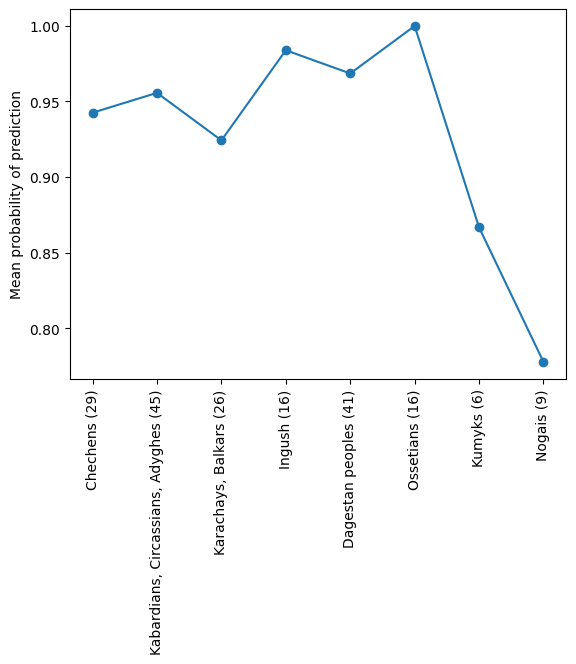

In [52]:
p_answers_sel = np.zeros(len(types))
for i in range(len(types)):
    p_true = np.array(p_true)
    p_true_idx = p_true == i

    p_answers_sel[i] = (np.sum(np.array(p_answers)[p_true_idx], axis=0) / len(p_true[p_true_idx]))[i]

plt.clf()
plt.plot(p_answers_sel, marker='o')
plt.ylabel('Mean probability of prediction')
plt.xticks([i for i in range(len(types))], [f'{t} ({len(p_true[p_true == n])})' for n, t in enumerate(types)], rotation=90)
plt.savefig(rf"C:\HSE\genotek\robust_cr.png", bbox_inches="tight")
plt.show()

In [36]:
p_answers

[]

# TripletLoss GNN

In [57]:
def _masked_minimum_torch(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = torch.max(data, dim, keepdims=True)[0]
    masked_minimums = (
        torch.min(
            torch.multiply(data - axis_maximums, mask), dim, keepdims=True
        )[0]
        + axis_maximums
    )
    return masked_minimums


def _masked_maximum_torch(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = torch.min(data, dim, keepdims=True)[0]
    masked_maximums = (
        torch.max(
            torch.multiply(data - axis_minimums, mask), dim, keepdims=True
        )[0]
        + axis_minimums
    )
    return masked_maximums

In [58]:
class TripletSemiHardLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletSemiHardLoss, self).__init__()
        
        self.margin = margin

    def forward(self, y_pred, y_true):
        labels = y_true
        embeddings = y_pred

        convert_to_float32 = (
            embeddings.dtype == torch.float16 or embeddings.dtype == torch.bfloat16
        )
        precise_embeddings = (
            embeddings.type(torch.float32) if convert_to_float32 else embeddings
        )

        # Reshape label tensor to [batch_size, 1].
        lshape = labels.shape
        labels = labels.view(lshape[0], 1)

        # Build pairwise squared distance matrix

        pdist_matrix = torch.cdist(precise_embeddings, precise_embeddings)
        
#         print(pdist_matrix)

        # Build pairwise binary adjacency matrix.
        adjacency = torch.eq(labels, labels.T).long()
#         print(adjacency)
        # Invert so we can select negatives only.
        adjacency_not = torch.logical_not(adjacency).long()
#         print(adjacency_not)

        batch_size = labels.shape[0]

        # Compute the mask.
        pdist_matrix_tile = torch.tile(pdist_matrix, (batch_size, 1))
#         print(pdist_matrix_tile)
        
        mask = torch.logical_and(
            torch.tile(adjacency_not, (batch_size, 1)),
            torch.gt(
                pdist_matrix_tile, pdist_matrix.T.reshape(-1, 1))
            ).long()
#         tf.print(mask)
        
        mask_final = torch.gt(
                torch.sum(
                    mask.type(torch.float32), axis=1, keepdims=True
                ),
                0.0,
            ).view((batch_size, batch_size))
        
#         print(mask_final)
        
        mask_final = mask_final.T

        adjacency_not = adjacency_not.type(torch.float32)
        mask = mask.type(torch.float32)

        # negatives_outside: smallest D_an where D_an > D_ap.
        negatives_outside = _masked_minimum_torch(pdist_matrix_tile, mask).view(batch_size, batch_size)
        
#         print(negatives_outside)
        
        negatives_outside = negatives_outside.T

        # negatives_inside: largest D_an.
        negatives_inside = torch.tile(
            _masked_maximum_torch(pdist_matrix, adjacency_not), (1, batch_size)
        )
#         print(negatives_inside)
        
        semi_hard_negatives = torch.where(mask_final, negatives_outside, negatives_inside)
        
#         print(semi_hard_negatives)

        loss_mat = torch.add(self.margin, pdist_matrix - semi_hard_negatives)
    
#         print(loss_mat)

        mask_positives = adjacency.type(torch.float32) - torch.diag(
            torch.ones(batch_size).to('cuda')
        )
    
#         print(mask_positives)

        # In lifted-struct, the authors multiply 0.5 for upper triangular
        #   in semihard, they take all positive pairs except the diagonal.
        num_positives = torch.sum(mask_positives)
        
#         print(num_positives)

        triplet_loss = torch.true_divide(
            torch.sum(
                torch.maximum(tmp := torch.multiply(loss_mat, mask_positives), torch.zeros(tmp.shape).to('cuda'))
            ),
            num_positives,
        )
    
#         print(
#                 torch.max(tmp := torch.multiply(loss_mat, mask_positives), torch.zeros(tmp.shape).to('cuda'))[0]
#             )
    ################################TF###############################
#         triplet_loss = tf.math.truediv(
#             tf.math.reduce_sum(
#                 tf.math.maximum(tf.math.multiply(loss_mat, mask_positives), 0.0)
#             ),
#             num_positives,
#         )
    ###############################TF#######################################
    
#         print(triplet_loss)

        if convert_to_float32:
            return triplet_loss.type(embeddings.dtype)
        else:
            return triplet_loss

In [86]:
class SSGConv_3l_128h_w_k1_l128(torch.nn.Module):
    def __init__(self):
        super(SSGConv_3l_128h_w_k1_l128, self).__init__()
        self.conv1 = SSGConv(data.num_features, 128, alpha=0.5)
        self.conv2 = SSGConv(128, 128, alpha=0.5)
        self.conv3 = SSGConv(128, 128, alpha=0.5)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x
    
class SSGConv_3l_128h_w_k3_l128(torch.nn.Module):
    def __init__(self):
        super(SSGConv_3l_128h_w_k3_l128, self).__init__()
        self.conv1 = SSGConv(data.num_features, 128, K=3, alpha=1.)
        self.conv2 = SSGConv(128, 128, K=3, alpha=1.)
        self.conv3 = SSGConv(128, 128, K=3, alpha=1.)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x

class TAGConv_3l_128h_w_k3_l128(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_128h_w_k3_l128, self).__init__()
        self.norm = LayerNorm(data.num_features)
        self.conv1 = TAGConv(data.num_features, 128)
        self.conv2 = TAGConv(128, 128)
        self.conv3 = TAGConv(128, 128)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = self.norm(x)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x
    
class TAGConv_9l_128h_w_k3_l128(torch.nn.Module):
    def __init__(self):
        super(TAGConv_9l_128h_w_k3_l128, self).__init__()
        self.conv1 = TAGConv(data.num_features, 128)
        self.conv2 = TAGConv(128, 128)
        self.conv3 = TAGConv(128, 128)
        self.conv4 = TAGConv(128, 128)
        self.conv5 = TAGConv(128, 128)
        self.conv6 = TAGConv(128, 128)
        self.conv7 = TAGConv(128, 128)
        self.conv8 = TAGConv(128, 128)
        self.conv9 = TAGConv(128, 128)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = F.elu(self.conv3(x, edge_index, edge_attr))
        x = F.elu(self.conv4(x, edge_index, edge_attr))
        x = F.elu(self.conv5(x, edge_index, edge_attr))
        x = F.elu(self.conv6(x, edge_index, edge_attr))
        x = F.elu(self.conv7(x, edge_index, edge_attr))
        x = F.elu(self.conv8(x, edge_index, edge_attr))
        x = self.conv9(x, edge_index, edge_attr)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x
    
class TAGConv_3l_512h_w_k3_l128(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_512h_w_k3_l128, self).__init__()
        self.conv1 = TAGConv(data.num_features, 512)
        self.conv2 = TAGConv(512, 512)
        self.conv3 = TAGConv(512, 128)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x
    
class GCNConv_3l_128h_w_l128(torch.nn.Module):
    def __init__(self):
        super(GCNConv_3l_128h_w_l128, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x
    
class ChebConv_3l_128h_w_k3(torch.nn.Module):
    def __init__(self):
        super(ChebConv_3l_128h_w_k3, self).__init__()
        self.conv1 = ChebConv(data.num_features, 128, K=3)
        self.conv2 = ChebConv(128, 128, K=3)
        self.conv3 = ChebConv(128, 128, K=3)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x
    
class GINnn(torch.nn.Module):
    def __init__(self):
        super(GINnn, self).__init__()
        self.gin = GIN(in_channels=data.num_features, hidden_channels=32, num_layers=3, out_channels=data.num_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = self.gin(x, edge_index)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x

In [49]:
torch.nn.functional.normalize(torch.tensor(np.arange(12).reshape(3, -1).astype(float)), p=2, dim=1)

tensor([[0.0000, 0.2673, 0.5345, 0.8018],
        [0.3563, 0.4454, 0.5345, 0.6236],
        [0.4182, 0.4704, 0.5227, 0.5750]], dtype=torch.float64)

In [60]:
np.sort([7, 8, 2, 5, 1])

array([1, 2, 5, 7, 8])

In [6]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
target = torch.tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
loss(m(input), target)

tensor(0.7552)

In [87]:
model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

Step 0
LOSS: 0, 0/50000
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        20
           1       0.22      0.06      0.09       138
           2       0.43      0.44      0.44       127
           3       0.68      0.87      0.77       653
           4       0.24      0.15      0.19       189

    accuracy                           0.59      1127
   macro avg       0.38      0.33      0.33      1127
weighted avg       0.52      0.59      0.54      1127

Final f1 score weighted: 0.5388784877019107
Final f1 score macro: 0.32705063611211727
Max f1 score weighted: 0.5388784877019107
Max f1 score macro: 0.32705063611211727


<Figure size 640x480 with 0 Axes>

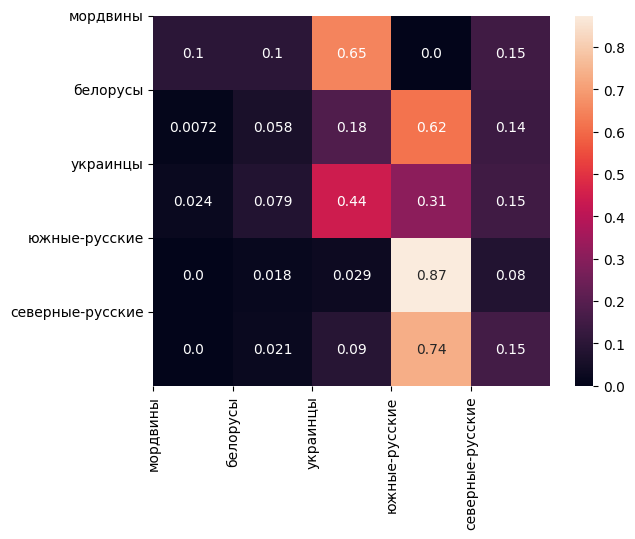

Step 2000
LOSS: 0.20000003278255463, 2000/50000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00       138
           2       0.00      0.00      0.00       127
           3       0.58      1.00      0.73       653
           4       0.00      0.00      0.00       189

    accuracy                           0.58      1127
   macro avg       0.12      0.20      0.15      1127
weighted avg       0.34      0.58      0.43      1127

Final f1 score weighted: 0.4251208837223213
Final f1 score macro: 0.14674157303370786
Max f1 score weighted: 0.5388784877019107
Max f1 score macro: 0.32705063611211727


C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Figure size 640x480 with 0 Axes>

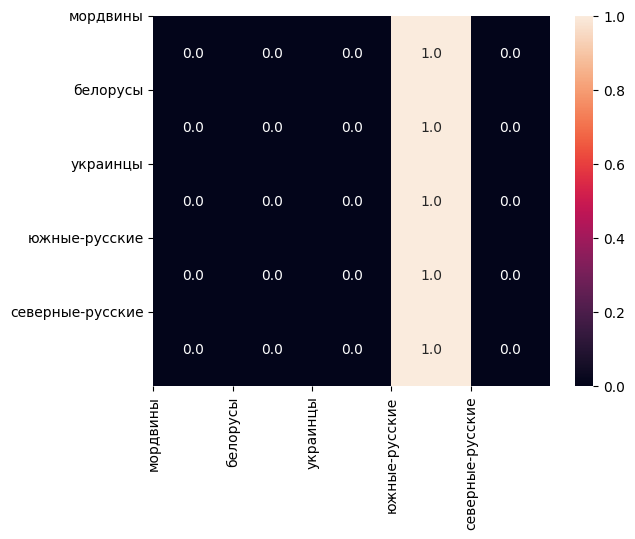

Step 4000
LOSS: 0.20000004768371582, 4000/50000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00       138
           2       0.00      0.00      0.00       127
           3       0.58      1.00      0.73       653
           4       0.00      0.00      0.00       189

    accuracy                           0.58      1127
   macro avg       0.12      0.20      0.15      1127
weighted avg       0.34      0.58      0.43      1127

Final f1 score weighted: 0.4251208837223213
Final f1 score macro: 0.14674157303370786
Max f1 score weighted: 0.5388784877019107
Max f1 score macro: 0.32705063611211727


C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Figure size 640x480 with 0 Axes>

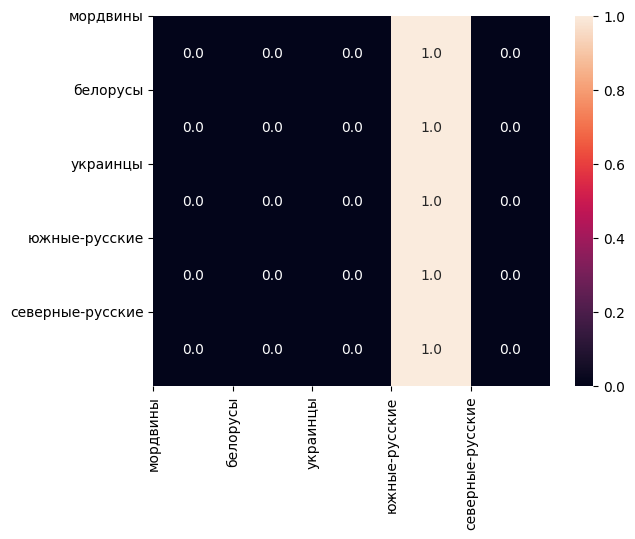

KeyboardInterrupt: 

In [88]:
# Implementation with TripletLoss

# import gc
# import torch
# import torch.nn as nn
import torch.nn.functional as F
# from sklearn.metrics import f1_score
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, NNConv, SGConv, ARMAConv, TAGConv, ChebConv, DNAConv, SSGConv
import time
# from torch.nn import Linear
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GINnn().to(device)

criterion = TripletSemiHardLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Define optimizer.
# scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)

max_f1_score = 0
max_f1_score_macro = 0

def evaluation(model, test_graphs, i, types):
    
    model.eval()
    
    global max_f1_score, max_f1_score_macro
    
    target_train = np.zeros((len(data.y), len(types)))
    for i in range(len(data.y)):
        target_train[i, data.y[i]] = 1
    
    results_train = model(data).cpu().detach().numpy()
        
    target_test = []
    for i in range(len(test_graphs)):
        tmparray = np.zeros(len(types))
        tmparray[test_graphs[i][0].y[-1]] = 1
        target_test.append(tmparray)

    target_test = np.array(target_test)

    results_test = []
    for i in range(len(test_graphs)):
        tmp_test_results = []
        min_distances = []
        for j in range(len(types)):
            tmp_test_results.append(model(test_graphs[i][j].to(device))[-1].cpu().detach().numpy())
            test_graphs[i][j].cpu()
            min_distances.append(np.min(np.linalg.norm(tmp_test_results[-1] - results_train, axis=1)))
        results_test.append(tmp_test_results[np.argmin(min_distances)])
        

    results_test = np.array(results_test)
    
    # actually calculating labels
    
    ground_truth = []
    predicted_labels = []
    for i in range(len(results_test)):
        vec = results_test[i]
        real = target_test[i]
        
        class_list = np.argmax(target_train[np.argsort(np.linalg.norm(vec - results_train, axis=1))[:10]],
                               axis=-1).squeeze()

        ground_truth.append(np.argmax(real.squeeze()))

        uniq, cnts = np.unique(class_list, return_counts=True)
        u_l = np.asarray((uniq, cnts)).T
        u_l_as = np.argsort(u_l[:, 1])
        predicted_labels.append(u_l[u_l_as[::-1]][0, 0])

    print(classification_report(ground_truth, predicted_labels))
    cm = confusion_matrix(ground_truth, predicted_labels, normalize='true')

    final_f1_weighted_score = f1_score(ground_truth, predicted_labels, average='weighted')
    final_f1_macro_score = f1_score(ground_truth, predicted_labels, average='macro')

    print(f"Final f1 score weighted: {final_f1_weighted_score}")
    print(f"Final f1 score macro: {final_f1_macro_score}")
    
    if final_f1_weighted_score > max_f1_score:
        max_f1_score = final_f1_weighted_score
        
    if final_f1_macro_score > max_f1_score_macro:
        max_f1_score_macro = final_f1_macro_score
        
    print(f"Max f1 score weighted: {max_f1_score}")
    print(f"Max f1 score macro: {max_f1_score_macro}")

    plt.clf()

    px = 1 / plt.rcParams['figure.dpi']

    fig, ax = plt.subplots(1, 1)#figsize=(4000 * px, 4000 * px))
    sns.heatmap(cm, annot=True, ax=ax, annot_kws={'size': 10}, fmt='.2')
    ax.set_xticks([i for i in range(len(types))])
    ax.set_xticklabels([f'{types[i]}' for i in range(0, len(types))])
    ax.set_yticks([i for i in range(len(types))])
    ax.set_yticklabels([f'{types[i]}' for i in range(0, len(types))])
    plt.yticks(rotation=0)
    plt.xticks(rotation=90) 
    plt.show()
    
    model.train()
    

def train(data, log_step, num_epochs, test_graphs, types):
    model.train()
    data =  data.to(device)
    loss = 0
    for i in range(num_epochs):
        
        if i % log_step == 0:
            print(f'Step {i}')
            print(f'LOSS: {loss}, {i}/{num_epochs}')
#             print(scheduler.get_lr())
            evaluation(model, test_graphs, i, types)
        
        optimizer.zero_grad()  # Clear gradients.
        out = model(data)  # Perform a single forward pass.
        
        selector = np.array([True if i < 256 else False for i in range(out.shape[0])]) # 256 for CR, 1024 for NC !!!!!!!!!
        randomize = np.arange(out.shape[0])
        np.random.shuffle(randomize)
        selector = selector[randomize]
        
        loss = criterion(out[selector], data.y[selector])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
#         scheduler.step()

start = time.time()
train(data, 2000, 50000, test_graphs, types)
end = time.time()

print(f'RUNTIME (min): {(end-start) / 60}')

# model = None
# gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing

In [18]:
for i in range(len(test_graphs)):
    test_graphs[i] = test_graphs[i].cpu()

# Testing TripletLoss (clustering algorithms) - new approach

In [35]:
model.eval()

SSGConv_3l_128h_w_k3_l128(
  (conv1): SSGConv(8, 128, K=1, alpha=0.9)
  (conv2): SSGConv(128, 128, K=1, alpha=0.9)
  (conv3): SSGConv(128, 128, K=1, alpha=0.9)
)

In [36]:
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import v_measure_score

In [38]:
target_train = np.zeros((len(data.y), len(types)))
for i in range(len(data.y)):
    target_train[i, data.y[i]] = 1
    
results_train = model(data).cpu().detach().numpy()

In [39]:
target_test = []
for i in range(len(test_graphs)):
    tmparray = np.zeros(len(types))
    tmparray[test_graphs[i].y[-1]] = 1
    target_test.append(tmparray)
    
target_test = np.argmax(np.array(target_test), axis=1)

In [40]:
results_test = []
for i in range(len(test_graphs)):
    print(f'{i} / {len(test_graphs)} node')
    results_test.append(model(test_graphs[i].to(device))[-1].cpu().detach().numpy())
    test_graphs[i].cpu()
    
results_test = np.array(results_test)

0 / 188 node
1 / 188 node
2 / 188 node
3 / 188 node
4 / 188 node
5 / 188 node
6 / 188 node
7 / 188 node
8 / 188 node
9 / 188 node
10 / 188 node
11 / 188 node
12 / 188 node
13 / 188 node
14 / 188 node
15 / 188 node
16 / 188 node
17 / 188 node
18 / 188 node
19 / 188 node
20 / 188 node
21 / 188 node
22 / 188 node
23 / 188 node
24 / 188 node
25 / 188 node
26 / 188 node
27 / 188 node
28 / 188 node
29 / 188 node
30 / 188 node
31 / 188 node
32 / 188 node
33 / 188 node
34 / 188 node
35 / 188 node
36 / 188 node
37 / 188 node
38 / 188 node
39 / 188 node
40 / 188 node
41 / 188 node
42 / 188 node
43 / 188 node
44 / 188 node
45 / 188 node
46 / 188 node
47 / 188 node
48 / 188 node
49 / 188 node
50 / 188 node
51 / 188 node
52 / 188 node
53 / 188 node
54 / 188 node
55 / 188 node
56 / 188 node
57 / 188 node
58 / 188 node
59 / 188 node
60 / 188 node
61 / 188 node
62 / 188 node
63 / 188 node
64 / 188 node
65 / 188 node
66 / 188 node
67 / 188 node
68 / 188 node
69 / 188 node
70 / 188 node
71 / 188 node
72

In [42]:
raw_preds = []

# neigh = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
# neigh.fit(results_train, np.argmax(np.array(target_train), axis=1))

for k, res in enumerate(results_test):
    print(f'{k}/{len(results_test)}')
    current_results_test = np.concatenate([results_train, np.expand_dims(res, axis=0)])
    current_sk = SpectralClustering(n_clusters=len(types), n_init=100, assign_labels='discretize', gamma=5, random_state=0).fit(current_results_test)
    raw_preds.append(current_sk.labels_[-1])
#     raw_preds.append(neigh.predict(current_results_test)[-1])
raw_preds = np.array(raw_preds)

ars = adjusted_rand_score(target_test, raw_preds)
vms = v_measure_score(target_test, raw_preds)
print(ars, vms)

0/188
1/188
2/188
3/188
4/188
5/188
6/188
7/188
8/188
9/188
10/188
11/188
12/188
13/188
14/188
15/188
16/188
17/188
18/188
19/188
20/188
21/188
22/188
23/188
24/188
25/188
26/188
27/188
28/188
29/188
30/188
31/188
32/188
33/188
34/188
35/188
36/188
37/188
38/188
39/188
40/188
41/188
42/188
43/188
44/188
45/188
46/188
47/188
48/188
49/188
50/188
51/188
52/188
53/188
54/188
55/188
56/188
57/188
58/188
59/188
60/188
61/188
62/188
63/188
64/188
65/188
66/188
67/188
68/188
69/188
70/188
71/188
72/188
73/188
74/188
75/188
76/188
77/188
78/188
79/188
80/188
81/188
82/188
83/188
84/188
85/188
86/188
87/188
88/188
89/188
90/188
91/188
92/188
93/188
94/188
95/188
96/188
97/188
98/188
99/188
100/188
101/188
102/188
103/188
104/188
105/188
106/188
107/188
108/188
109/188
110/188
111/188
112/188
113/188
114/188
115/188
116/188
117/188
118/188
119/188
120/188
121/188
122/188
123/188
124/188
125/188
126/188
127/188
128/188
129/188
130/188
131/188
132/188
133/188
134/188
135/188
136/188
137/188
138/18

In [202]:
np.argmax([[0, 0, 0, 1], [0, 0, 1, 0]], axis=1)

array([3, 2], dtype=int64)

In [139]:
np.mean([0, 0, 0, 1, 1])

0.4

In [141]:
np.mean([1, 1, 1, 0, 0])

4.6

In [143]:
v_measure_score([1, 1, 1, 0, 0], [0, 0, 0, 1, 1])

1.0

In [29]:
raw_preds

array([4, 4, 4, ..., 0, 0, 4], dtype=int64)

In [129]:
target_test

array([3, 5, 3, 3, 5, 7, 3, 4, 5, 3, 4, 4, 3, 7, 4, 5, 5, 4, 4, 4, 4, 5,
       4, 3, 1, 2, 7, 1, 1, 1, 3, 5, 5, 0, 7, 2, 5, 1, 4, 4, 4, 2, 3, 0,
       7, 4, 3, 1, 2, 1, 2, 2, 2, 5, 1, 0, 5, 0, 7, 4, 4, 5, 1, 0, 4, 0,
       1, 1, 1, 2, 7, 0, 0, 1, 1, 1, 4, 3, 4, 4, 0, 3, 5, 1, 4, 4, 1, 4,
       0, 3, 1, 4, 0, 6, 2, 4, 4, 4, 2, 1, 1, 4, 0, 2, 3, 2, 0, 6, 5, 0,
       4, 2, 0, 1, 1, 1, 4, 1, 4, 2, 2, 4, 0, 2, 5, 6, 1, 2, 1, 1, 4, 0,
       1, 0, 4, 2, 1, 1, 1, 1, 2, 1, 1, 6, 7, 7, 2, 0, 1, 4, 2, 0, 4, 1,
       0, 1, 5, 2, 6, 3, 2, 1, 4, 4, 0, 0, 0, 4, 3, 4, 1, 1, 2, 0, 1, 2,
       0, 2, 0, 0, 0, 1, 1, 6, 1, 1, 4, 4], dtype=int64)

In [30]:
results_train.shape

(2635, 128)

In [31]:
results_test.shape

(1132, 128)

In [37]:
target_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### Spektral Clustering

In [107]:
# clustering_sk = SpectralClustering(n_clusters=len(types), assign_labels='discretize', random_state=0).fit(all_results)
# clustering_sk.labels_

array([3, 2, 7, 7, 0, 1, 7, 2, 3, 1, 1, 1, 7, 3, 1, 3, 1, 3, 1, 3, 2, 1,
       6, 3, 2, 5, 0, 4, 5, 7, 3, 3, 7, 3, 3, 3, 2, 6, 5, 0, 3, 5, 2, 7,
       2, 3, 0, 2, 2, 0, 5, 3, 7, 7, 1, 2, 2, 7, 3, 3, 1, 7, 3, 7, 7, 3,
       0, 1, 1, 0, 5, 7, 2, 1, 3, 0, 1, 7, 0, 3, 1, 0, 3, 7, 6, 5, 7, 7,
       0, 3, 3, 5, 6, 7, 3, 3, 5, 7, 4, 7, 7, 7, 7, 7, 0, 7, 6, 3, 5, 7,
       1, 3, 7, 6, 0, 5, 7, 0, 1, 2, 6, 0, 1, 3, 3, 0, 0, 4, 7, 2, 1, 0,
       3, 7, 5, 3, 3, 6, 5, 3, 0, 3, 5, 3, 3, 6, 7, 7, 0, 7, 2, 0, 5, 3,
       7, 1, 3, 3, 3, 0, 3, 7, 2, 3, 3, 1, 0, 7, 7, 7, 5, 0, 7, 1, 7, 7,
       1, 1, 7, 3, 1, 2, 3, 1, 1, 0, 0, 1, 5, 3, 7, 3, 1, 3, 3, 7, 7, 7,
       5, 6, 0, 7, 5, 7, 5, 1, 2, 6, 3, 0, 3, 7, 3, 2, 3, 2, 0, 7, 2, 4,
       2, 7, 5, 0, 0, 3, 3, 3, 2, 1, 0, 3, 2, 7, 6, 6, 0, 3, 3, 1, 7, 5,
       7, 3, 4, 5, 2, 5, 5, 6, 7, 7, 3, 3, 2, 1, 2, 0, 0, 0, 3, 1, 1, 3,
       7, 1, 1, 2, 5, 2, 1, 7, 1, 3, 7, 0, 7, 5, 7, 6, 7, 7, 1, 0, 7, 2,
       7, 7, 1, 3, 7, 7, 0, 7, 2, 7, 7, 3, 7, 7, 0,

In [229]:
ars = adjusted_rand_score(target_test, raw_preds)
vms = v_measure_score(target_test, raw_preds)
print(ars, vms)

0.8745293452801638 0.8988048283222152


In [43]:
all_classes_unique_ids = np.unique(target_test)
mapping = dict()
for u_id in all_classes_unique_ids:
    selected_pred = raw_preds[target_test == u_id]
    mapping[u_id] = np.bincount(selected_pred).argmax()

print(mapping)
mapping = dict((v,k) for k,v in mapping.items())
if len(mapping) < len(types):
    print('Same label for different classes!!!')
else:
    predicted_labels = []
    for l in raw_preds:
        predicted_labels.append(mapping[l])

{0: 5, 1: 4, 2: 6, 3: 1, 4: 7, 5: 0, 6: 2, 7: 3}


In [44]:
all_results = np.concatenate([results_train, results_test], axis=0)
all_results.shape

(614, 128)

In [45]:
all_targets = np.concatenate([np.argmax(target_train, axis=1), target_test], axis=0)
all_targets.shape

(614,)

In [46]:
predicted_targets = np.concatenate([np.argmax(target_train, axis=1), predicted_labels], axis=0)
predicted_targets.shape

(614,)

In [27]:
f1_score(target_test, predicted_labels, average='weighted')

0.9467994552264216

In [28]:
f1_score(target_test, predicted_labels, average='macro')

0.9455418008186363

<Figure size 640x480 with 0 Axes>

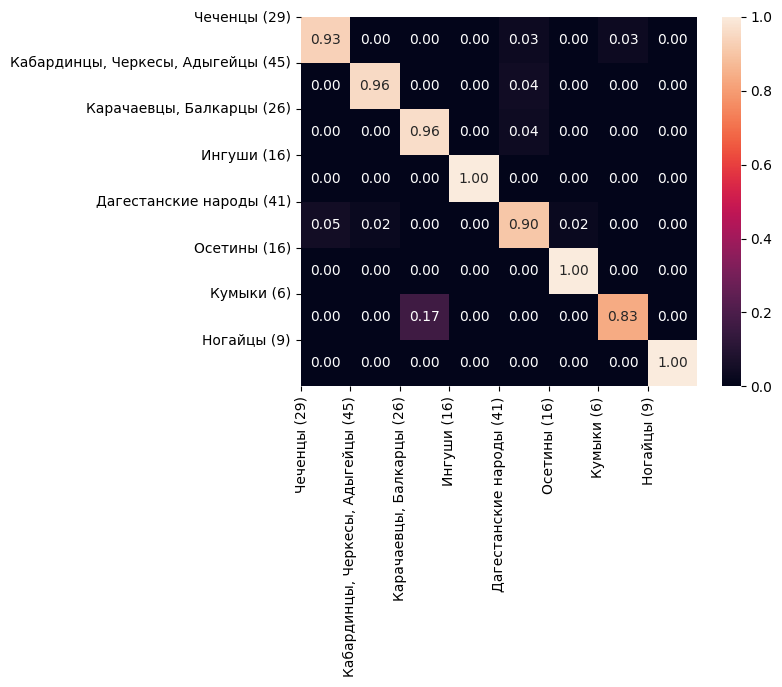

In [34]:
types = ['Чеченцы (29)', 'Кабардинцы, Черкесы, Адыгейцы (45)', 'Карачаевцы, Балкарцы (26)', 'Ингуши (16)', 'Дагестанские народы (41)', 'Осетины (16)', 'Кумыки (6)', 'Ногайцы (9)']

cm = confusion_matrix(target_test, predicted_labels, normalize='true')

plt.clf()
    
px = 1 / plt.rcParams['figure.dpi']

fig, ax = plt.subplots(1, 1)#figsize=(4000 * px, 4000 * px))
sns.heatmap(cm, annot=True, ax=ax, annot_kws={'size': 10}, fmt=".2f")
ax.set_xticks([i for i in range(len(types))])
ax.set_xticklabels([f'{types[i]}' for i in range(0, len(types))])
ax.set_yticks([i for i in range(len(types))])
ax.set_yticklabels([f'{types[i]}' for i in range(0, len(types))])
# fig.suptitle(f"Confusion matrix, F1: {round(f1_score(ground_truth, predicted_labels, average='weighted'), 4)}")
plt.yticks(rotation=0)
plt.xticks(rotation=90) 
plt.savefig(f"nc_tripletloss_grant_ii.png", bbox_inches="tight")
plt.show()

In [288]:
from sklearn.metrics import classification_report
print(classification_report(target_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        29
           1       0.96      0.98      0.97        45
           2       1.00      0.96      0.98        26
           3       1.00      1.00      1.00        16
           4       0.97      0.90      0.94        41
           5       0.94      1.00      0.97        16
           6       0.86      1.00      0.92         6
           7       1.00      1.00      1.00         9

    accuracy                           0.96       188
   macro avg       0.96      0.98      0.97       188
weighted avg       0.96      0.96      0.96       188



In [47]:
all_results_2d = TSNE(n_components=2, learning_rate=1, init='random', perplexity=40).fit_transform(all_results)

In [50]:
alpha_mask = [0.2 if i < len(results_train) else 1 for i in range(len(all_results))]

C:\Users\Alex\AppData\Local\Temp\ipykernel_29140\939482645.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', len(types))


<Figure size 640x480 with 0 Axes>

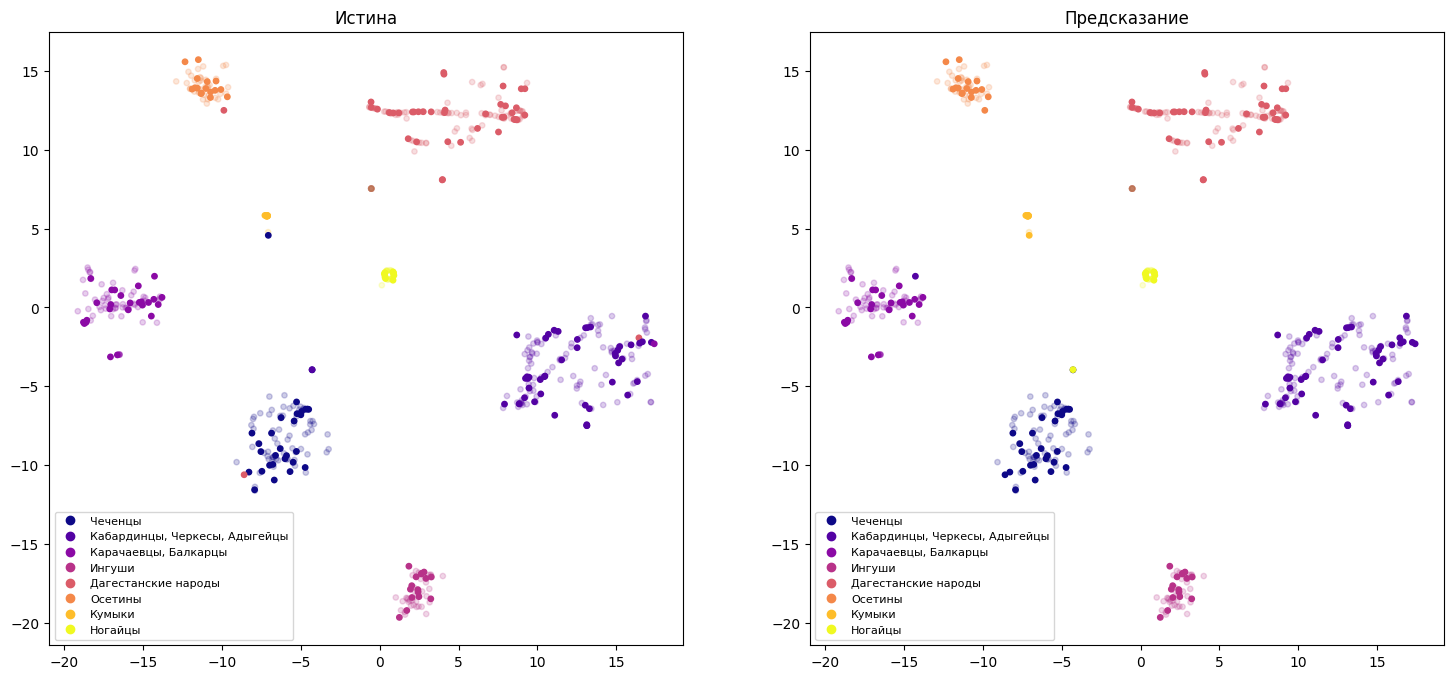

In [52]:
types = ['Чеченцы', 'Кабардинцы, Черкесы, Адыгейцы', 'Карачаевцы, Балкарцы', 'Ингуши', 'Дагестанские народы', 'Осетины', 'Кумыки', 'Ногайцы']


from pylab import *
import matplotlib.pylab as pplt

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

pplt.clf()
fig, (ax1, ax2) = pplt.subplots(1, 2, figsize=(18, 18))
# fig.suptitle('Horizontally stacked subplots')
ax1.set_title('Истина')
ax2.set_title('Предсказание')
ax1.set_aspect(1)
ax2.set_aspect(1)
a1s = ax1.scatter(*all_results_2d.T, c=all_targets, s=15, cmap='plasma', alpha=alpha_mask)
a2s = ax2.scatter(*all_results_2d.T, c=predicted_targets, s=15, cmap='plasma', alpha=alpha_mask)
# ax1.legend(handles=a1s.legend_elements()[0], labels=types, fontsize=8)
# ax2.legend(handles=a2s.legend_elements()[0], labels=types, fontsize=8)

cmap = cm.get_cmap('plasma', len(types))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
legend_pics = []
for i in range(len(color_list)):
    lp = Line2D([0], [0], label=types[i], color=color_list[i], marker='o', ls="")
    legend_pics.append(lp)
    
ax1.legend(handles=legend_pics, fontsize=8)
ax2.legend(handles=legend_pics, fontsize=8)

plt.savefig(f"nc_clusterization_comparison_grant_ii.png", bbox_inches="tight")
plt.show()

### DBSCAN

In [33]:
clustering_DBSCAN = DBSCAN(eps=0.5, min_samples=2).fit(all_results)
clustering_DBSCAN.labels_

array([ 0,  1,  2,  2,  3,  4,  2,  1,  0,  4,  4,  4,  2,  0,  4,  0,  4,
        0,  4,  0,  1,  4,  5,  0,  1,  6,  3,  7,  6,  2,  0,  0,  2,  0,
        0,  0,  1,  5,  6,  3,  0,  6,  1,  2,  1,  0,  3,  1,  1,  3,  6,
        0,  2,  2,  4,  1,  1,  2,  0,  0,  4,  2,  0,  8,  2,  0,  3,  4,
        4,  3,  6,  2,  1,  4,  0,  3,  4,  2,  3,  0,  4,  3,  0,  2,  5,
        6,  2,  2,  3,  0,  0,  6,  5,  2,  0,  0,  6,  2,  7,  2,  2,  2,
        2,  2,  3,  2,  5,  0,  6,  2,  4,  0,  2,  5,  3,  6,  8,  3,  4,
        1,  5,  3,  4,  0,  0,  3,  3,  7,  2,  1, -1,  3,  0,  2,  6,  0,
        0,  5,  6,  0,  3,  0,  6,  0,  0,  5,  2,  2,  3,  2,  1,  3,  6,
        0,  8,  4,  0,  0,  0,  3,  0,  2,  1,  0,  0,  4,  3,  2,  2,  2,
        6,  3,  2,  4,  2,  2,  4,  4,  2,  0,  4,  1,  0,  4,  4,  3,  3,
        4,  6,  0,  2,  0,  4,  0,  0,  2,  2,  2,  6,  5,  3,  2,  6,  2,
        6,  4,  1,  5,  0,  3,  0,  2,  0,  1,  0,  1,  3,  2,  1,  7,  1,
        2,  6,  3,  3, -1

In [55]:
ars = adjusted_rand_score(all_targets, clustering_DBSCAN.labels_)
vms = v_measure_score(all_targets, clustering_DBSCAN.labels_)
print(ars, vms)

0.9354953206435681 0.9191928672806021


In [68]:
print(f'Num ground truth unique labels: {len(np.unique(all_targets))}')
print(f'Num predicted unique labels: {len(np.unique(clustering_DBSCAN.labels_))}')

all_classes_unique_ids = np.unique(all_targets)
mapping = dict()
for u_id in all_classes_unique_ids:
    selected_pred = (clustering_DBSCAN.labels_ + 1)[all_targets == u_id] # +1 to avoid -1 for np.bincount, -1 became 0
    mapping[u_id] = np.bincount(selected_pred).argmax()

print(mapping)
if 0 in mapping.values():
    print('WARNING!!! Outliers == class!!!')
else:
    mapping = dict((v,k) for k,v in mapping.items())
    if len(mapping) < len(types):
        print('Same label for different classes!!!')
    else:
        mapping[0] = -1
        predicted_labels = []
        for l in (clustering.labels_ + 1):
            if l in mapping.keys():
                predicted_labels.append(mapping[l])
            else:
                predicted_labels.append(l + len(mapping))
                
print(f'Num new predicted unique labels: {len(np.unique(predicted_labels))}')

Num ground truth unique labels: 8
Num predicted unique labels: 10
{0: 4, 1: 1, 2: 5, 3: 2, 4: 3, 5: 7, 6: 8, 7: 6}
Num new predicted unique labels: 10


In [76]:
np.sum(all_targets == predicted_labels) / len(all_targets)

0.9592833876221498

In [74]:
f1_score(all_targets, predicted_labels, average='weighted')

0.971867370073251

In [75]:
f1_score(all_targets, predicted_labels, average='macro')

0.7728029498701816

# Model explainer

In [150]:
! pip install captum

     ---------------------------------------- 1.3/1.3 MB 3.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [112]:
from torch_geometric.explain.algorithm import CaptumExplainer
from captum.attr import IntegratedGradients
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer

In [245]:
def model_forward(edge_mask, data):
    out = model(data)
    return out

In [246]:
ig = IntegratedGradients(model_forward)

In [247]:
data.y.shape

torch.Size([2635])

In [114]:
torch.save(model.state_dict(), 'TAGConv_3l_128h_w_k3_for_Explainer.bin')

In [115]:
class SSGConv_3l_128h_w_a05_k1_Explainer(torch.nn.Module):
    def __init__(self):
        super(SSGConv_3l_128h_w_a05_k1_Explainer, self).__init__()
        self.conv1 = SSGConv(data.num_features, 128, alpha=0.5)
        self.conv2 = SSGConv(128, 128, alpha=0.5)
        self.conv3 = SSGConv(128, int(data.num_classes), alpha=0.5)

    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x
    
class TAGConv_3l_128h_w_k3_Explainer(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_128h_w_k3_Explainer, self).__init__()
        self.conv1 = TAGConv(data.num_features, 128)
        self.conv2 = TAGConv(128, 128)
        self.conv3 = TAGConv(128, int(data.num_classes))

    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x

In [116]:
model = TAGConv_3l_128h_w_k3_Explainer()

In [117]:
model.load_state_dict(torch.load('TAGConv_3l_128h_w_k3_for_Explainer.bin'))
model.eval()

TAGConv_3l_128h_w_k3_Explainer(
  (conv1): TAGConv(8, 128, K=3)
  (conv2): TAGConv(128, 128, K=3)
  (conv3): TAGConv(128, 8, K=3)
)

In [118]:
data = data.to('cuda')
model = model.to('cuda')

In [119]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

kwargs = {'edge_attr': data.weight.float()}
# Generate explanation for the node at index `10`:
explanation = explainer(x=data.x.float(), edge_index=data.edge_index, index=10, **kwargs)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0.1504, 0.1815, 0.1460,  ..., 0.1540, 0.1529, 0.0000], device='cuda:0')
tensor([[0.1513, 0.1583, 0.0000,  ..., 0.1490, 0.0000, 0.0000],
        [0.2500, 0.0000, 0.1844,  ..., 0.1724, 0.0000, 0.0000],
        [0.1409, 0.0000, 0.0000,  ..., 0.0000, 0.1428, 0.0000],
        ...,
        [0.2490, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')


In [197]:
len(np.unique(data.edge_index.detach().cpu().numpy()))

2635

In [198]:
data.x.shape

torch.Size([2635, 5])

In [186]:
all_data_analysis_to = {i:[] for i in range(torch.max(data.edge_index))}
all_data_analysis_from = {i:[] for i in range(torch.max(data.edge_index))}

em = explanation.edge_mask
em = em - em.min()
em = em / em.max()

for i in range(len(all_data_analysis)):
    mask_to = data.edge_index[1, :] == i # direction TO node under analysis
    if not (True in mask_to.detach().cpu().numpy()):
        print('WARNING')
    deg_to = torch.sum(mask_to) # check later
    att_to = torch.sum(em[mask_to])
    
    all_data_analysis_to[i].append(deg_to.detach().cpu().item())
    all_data_analysis_to[i].append(att_to.detach().cpu().item())
    
    mask_from = data.edge_index[0, :] == i # direction TO node under analysis
    deg_from = torch.sum(mask_from) # check later
    att_from = torch.sum(em[mask_from])
    
    all_data_analysis_from[i].append(deg_from.detach().cpu().item())
    all_data_analysis_from[i].append(att_from.detach().cpu().item())

WARNING
WARNING
WARNING
WARNING
WARNING
WARNING
WARNING
WARNING
WARNING
WARNING
WARNING


(0.9598884073829815, 1.0109267116599752e-235)
(0.9675277174531417, 8.95370177077688e-255)


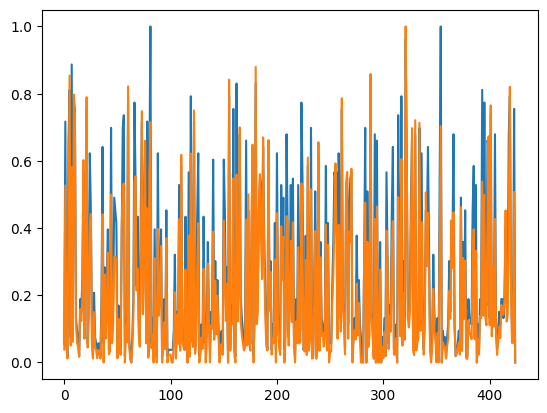

In [178]:
from scipy.stats import pearsonr

all_data_analysis_to_array = np.array(list(all_data_analysis_to.values()))
all_data_analysis_from_array = np.array(list(all_data_analysis_from.values()))

print(pearsonr(all_data_analysis_to_array[:, 0], all_data_analysis_to_array[:, 1]))
print(pearsonr(all_data_analysis_from_array[:, 0], all_data_analysis_from_array[:, 1]))

all_data_analysis_to_array[:, 0] = all_data_analysis_to_array[:, 0] - all_data_analysis_to_array[:, 0].min()
all_data_analysis_to_array[:, 0] = all_data_analysis_to_array[:, 0] / all_data_analysis_to_array[:, 0].max()

all_data_analysis_to_array[:, 1] = all_data_analysis_to_array[:, 1] - all_data_analysis_to_array[:, 1].min()
all_data_analysis_to_array[:, 1] = all_data_analysis_to_array[:, 1] / all_data_analysis_to_array[:, 1].max()

plt.clf()
plt.plot(all_data_analysis_to_array)
plt.show()

In [179]:
all_data_analysis_to_array[:, 1] > all_data_analysis_to_array[:, 0]

array([False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,

In [172]:
np.array(list(all_data_analysis_to.values()))

array([[ 3.        ,  0.48462987],
       [38.        ,  6.64917278],
       [ 4.        ,  0.60449398],
       [ 1.        ,  0.14895606],
       [35.        ,  5.41808891],
       [43.        , 10.77825546],
       [ 4.        ,  0.63310778],
       [47.        ,  7.3359499 ],
       [ 5.        ,  0.77178454],
       [41.        , 10.06155872],
       [40.        ,  9.32278252],
       [ 7.        ,  1.49711823],
       [ 5.        ,  0.74184102],
       [ 4.        ,  0.60476577],
       [ 1.        ,  0.21311516],
       [10.        ,  1.99909699],
       [ 8.        ,  1.55310452],
       [13.        ,  2.40612602],
       [30.        ,  7.60414028],
       [ 6.        ,  0.89006239],
       [27.        ,  4.39569902],
       [40.        ,  9.96658707],
       [ 3.        ,  0.56109333],
       [10.        ,  1.59410727],
       [33.        ,  5.13226891],
       [24.        ,  5.58172464],
       [ 5.        ,  0.74321109],
       [ 1.        ,  0.14397751],
       [11.        ,

In [135]:
data.x.shape

torch.Size([426, 8])

In [126]:
explanation.edge_mask.shape

torch.Size([5886])

In [137]:
print(torch.max(explanation.edge_mask))

tensor(0.3075, device='cuda:0')


In [125]:
explanation.node_mask.shape

torch.Size([426, 8])

In [131]:
explanation.edge_index.shape

torch.Size([2, 5886])

In [132]:
explanation.edge_index

tensor([[  0,   0,   0,  ..., 423, 423, 425],
        [ 81, 315,  33,  ..., 126,  48, 127]], device='cuda:0')

In [141]:
data.y[4]

tensor(0, device='cuda:0')

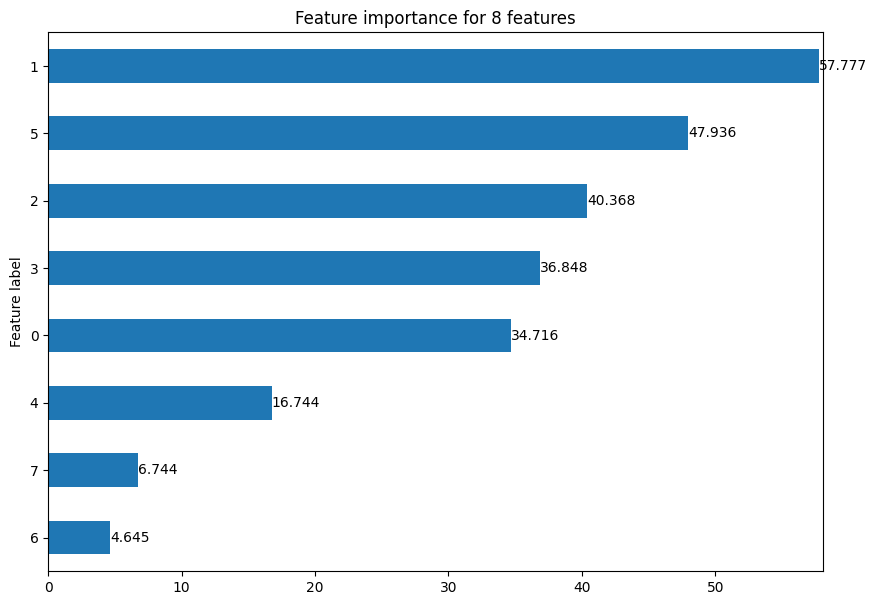

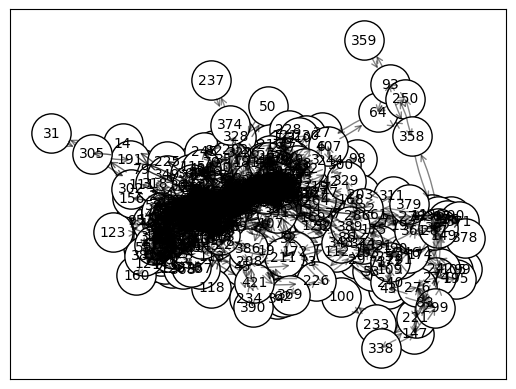

In [130]:
explanation.visualize_feature_importance()

# explanation.visualize_graph()

In [136]:
explanation.get_explanation_subgraph()

Explanation(node_mask=[388, 8], edge_mask=[5842], prediction=[388, 8], target=[388], index=10, x=[388, 8], edge_index=[2, 5842], edge_attr=[5842])

In [121]:
def offset(d, pos, dist = .1):
    for (u,v),obj in d.items():
        par = dist*(pos[v] - pos[u])
        dx,dy = par[1],-par[0]
        x,y = obj.get_position()
        const = 0.4
        obj.set_position((x+const*dx,y+const*dy))

In [148]:
from math import sqrt
def _visualize_graph_via_networkx(
    edge_index,
    edge_weight,
    index,
    path = None,
):
    import matplotlib.pyplot as plt
    import networkx as nx
    
    mask_array = []
    for i in range(edge_weight.shape[0]):
        if edge_index[0, i] == index or edge_index[1, i] == index:
            mask_array.append(True)
        else:
            mask_array.append(False)
            
    edge_index = edge_index[:, mask_array]
    edge_weight = edge_weight[mask_array]
    
    print(edge_weight)
    print(edge_index)
    
    print(edge_index.shape)
    print(edge_weight.shape)

    g = nx.DiGraph()
    node_size = 800

    for node in edge_index.view(-1).unique().tolist():
        g.add_node(node)

    for (src, dst), w in zip(edge_index.t().tolist(), edge_weight.tolist()):
        g.add_edge(src, dst, alpha=w, weight=round(w, 2))
        
    print(g.nodes)

    px = 1 / plt.rcParams['figure.dpi']

    fig, ax = plt.subplots(1, 1, figsize=(4000 * px, 5000 * px))
        
#     ax = plt.gca()
    pos = nx.spring_layout(g)
#     for src, dst, data in g.edges(data=True):
#         ax.annotate(
#             '',
#             xy=pos[src],
#             xytext=pos[dst],
#             arrowprops=dict(
#                 arrowstyle="->",
#                 alpha=data['alpha'],
#                 shrinkA=sqrt(node_size) / 2.0,
#                 shrinkB=sqrt(node_size) / 2.0,
#                 connectionstyle='arc3,rad=0.2',
#             ),
#         )

    for u,v,d in g.edges(data=True):
        d['weight'] = round(d['alpha'], 2)
        
    _,weights = zip(*nx.get_edge_attributes(g,'weight').items())

#     nodes = nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='orange', margins=0.1)
    labels = nx.get_edge_attributes(g,'weight')
    nx.draw_networkx(g, pos, with_labels=True, edgelist=g.edges, edge_color=weights, width=1.0, connectionstyle = 'arc3,rad=0.1', node_color='orange', edge_cmap=plt.cm.Greys, node_size=600,  font_size=10)
    d = nx.draw_networkx_edge_labels(g,pos,edge_labels=labels, label_pos=0.5)
    offset(d,pos)
#     nodes.set_edgecolor('black')
#     nx.draw_networkx_labels(g, pos, font_size=10)

    if path is not None:
        plt.savefig(path)
    else:
        plt.show()

    plt.close()

In [149]:
def visualize_graph(
    edge_index,
    index,
    edge_weight = None,
    path = None,
    backend = None,
):
    
    print('WEIGHT!', edge_weight)
    if edge_weight is not None:  # Normalize edge weights.
        edge_weight = edge_weight - edge_weight.min()
        edge_weight = edge_weight / edge_weight.max()

    if edge_weight is not None:  # Discard any edges with zero edge weight:
        mask = edge_weight > 1e-7
        edge_index = edge_index[:, mask]
        edge_weight = edge_weight[mask]

    if edge_weight is None:
        edge_weight = torch.ones(edge_index.size(1))

    if backend is None:
        backend = 'graphviz' if has_graphviz() else 'networkx'

    if backend.lower() == 'networkx':
        return _visualize_graph_via_networkx(edge_index, edge_weight, index, path)
    elif backend.lower() == 'graphviz':
        return _visualize_graph_via_graphviz(edge_index, edge_weight, path)

    raise ValueError(f"Expected graph drawing backend to be in "
                     f"{BACKENDS} (got '{backend}')")

In [150]:
edge_mask = explanation.get('edge_mask')
if edge_mask is None:
    raise ValueError(f"The attribute 'edge_mask' is not available "
                     f"in '{explanation.__class__.__name__}' "
                     f"(got {explanation.available_explanations})")
visualize_graph(explanation.edge_index, 4, edge_mask, 'graph_explanation.png', 'networkx')

WEIGHT! tensor([0.1504, 0.1815, 0.1460,  ..., 0.1540, 0.1529, 0.0000], device='cuda:0')
tensor([0.5234, 0.5259, 0.5556, 0.4857, 0.4768, 0.6103, 0.6129, 0.4776, 0.5211,
        0.4771, 0.5064, 0.5136, 0.5127, 0.5634, 0.5419, 0.6475, 0.5270, 0.4705,
        0.6198, 0.5042, 0.5470, 0.4691, 0.5021, 0.5464, 0.4686, 0.5812, 0.5383,
        0.4595, 0.5762, 0.4979, 0.5096, 0.4845, 0.5372, 0.5292, 0.5372, 0.4945,
        0.5152, 0.4537, 0.4802, 0.5373, 0.5365, 0.4659, 0.5074, 0.4842, 0.5228,
        0.4819, 0.5314, 0.5534, 0.4936, 0.4825, 0.4996, 0.5423, 0.4899, 0.5395,
        0.4733, 0.5393, 0.5212, 0.4797, 0.4699, 0.5064, 0.5356, 0.4862, 0.5164,
        0.4642, 0.4814, 0.4809, 0.5006, 0.4656, 0.5237, 0.5334],
       device='cuda:0')
tensor([[  1,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
           4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
           4,   4,   4,   4,   4,   4,   4,   4,  24,  48,  78,  81,  88, 119,
         125, 131, 159, 16

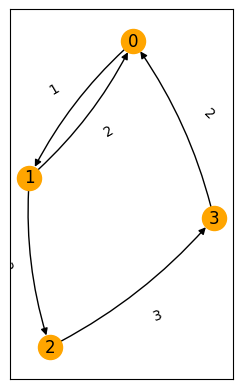

In [187]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_nodes_from(range(4))

G.add_edge(0,1,edge_count = 1)
G.add_edge(1,0,edge_count = 2)
G.add_edge(1,2,edge_count = 2)
G.add_edge(2,3,edge_count = 3)
G.add_edge(3,0,edge_count = 2)

def offset(d, pos, dist = .1):
    for (u,v),obj in d.items():
        par = dist*(pos[v] - pos[u])
        dx,dy = par[1],-par[0]
        x,y = obj.get_position()
        const = 2
        obj.set_position((x+const*dx,y+const*dy))

edge_labels = nx.get_edge_attributes(G,'edge_count')
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos = pos, with_labels=True, connectionstyle = 'arc3,rad=0.05', node_color = 'orange')
d = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = edge_labels)
offset(d,pos)
plt.gca().set_aspect('equal')
plt.show()

# Testing TripletLoss (old approach)

In [58]:
model.eval()

TAGConv_3l_128h_w_k3_l128(
  (conv1): TAGConv(8, 128, K=3)
  (conv2): TAGConv(128, 128, K=3)
  (conv3): TAGConv(128, 128, K=3)
)

In [59]:
data = data.to(device)

In [60]:
target_train = np.zeros((len(data.y), len(types)))
for i in range(len(data.y)):
    target_train[i, data.y[i]] = 1
    
results_train = model(data).cpu().detach().numpy()

In [61]:
target_test = []
for i in range(len(test_graphs)):
    tmparray = np.zeros(len(types))
    tmparray[test_graphs[i].y[-1]] = 1
    target_test.append(tmparray)
    
target_test = np.array(target_test)

In [62]:
results_test = []
for i in range(len(test_graphs)):
    print(f'{i} / {len(test_graphs)} node')
    results_test.append(model(test_graphs[i].to(device))[-1].cpu().detach().numpy())
    test_graphs[i].cpu()
    
results_test = np.array(results_test)

0 / 188 node
1 / 188 node
2 / 188 node
3 / 188 node
4 / 188 node
5 / 188 node
6 / 188 node
7 / 188 node
8 / 188 node
9 / 188 node
10 / 188 node
11 / 188 node
12 / 188 node
13 / 188 node
14 / 188 node
15 / 188 node
16 / 188 node
17 / 188 node
18 / 188 node
19 / 188 node
20 / 188 node
21 / 188 node
22 / 188 node
23 / 188 node
24 / 188 node
25 / 188 node
26 / 188 node
27 / 188 node
28 / 188 node
29 / 188 node
30 / 188 node
31 / 188 node
32 / 188 node
33 / 188 node
34 / 188 node
35 / 188 node
36 / 188 node
37 / 188 node
38 / 188 node
39 / 188 node
40 / 188 node
41 / 188 node
42 / 188 node
43 / 188 node
44 / 188 node
45 / 188 node
46 / 188 node
47 / 188 node
48 / 188 node
49 / 188 node
50 / 188 node
51 / 188 node
52 / 188 node
53 / 188 node
54 / 188 node
55 / 188 node
56 / 188 node
57 / 188 node
58 / 188 node
59 / 188 node
60 / 188 node
61 / 188 node
62 / 188 node
63 / 188 node
64 / 188 node
65 / 188 node
66 / 188 node
67 / 188 node
68 / 188 node
69 / 188 node
70 / 188 node
71 / 188 node
72

[[ 0.09257422 -0.00573273  0.04702277 ...  0.06505466 -0.01043144
   0.02985239]
 [ 0.04141474  0.03202569 -0.00601608 ... -0.07559782 -0.01515797
   0.0363787 ]
 [ 0.10974932 -0.16554883 -0.07763545 ...  0.07867602  0.12493781
  -0.03591006]
 ...
 [-0.06076564  0.07258675  0.10717341 ...  0.00209325  0.01275725
  -0.05041738]
 [-0.03978806 -0.12614445  0.05379133 ...  0.01919    -0.03401702
   0.0602495 ]
 [-0.09377437 -0.03540614  0.15231177 ... -0.0160213   0.02073011
  -0.12454766]]
Distance between clusters 0 and 1 = 1.5090577714729816
Distance between clusters 0 and 2 = 1.3727789766796705
Distance between clusters 0 and 3 = 1.491275982733925
Distance between clusters 0 and 4 = 1.1749894259139464
Distance between clusters 0 and 5 = 1.4413290067539641
Distance between clusters 0 and 6 = 1.3118265488953624
Distance between clusters 0 and 7 = 1.4164778304476322
Distance between clusters 1 and 2 = 1.652293187136543
Distance between clusters 1 and 3 = 0.9380128026397622
Distance betwee

<Figure size 640x480 with 0 Axes>

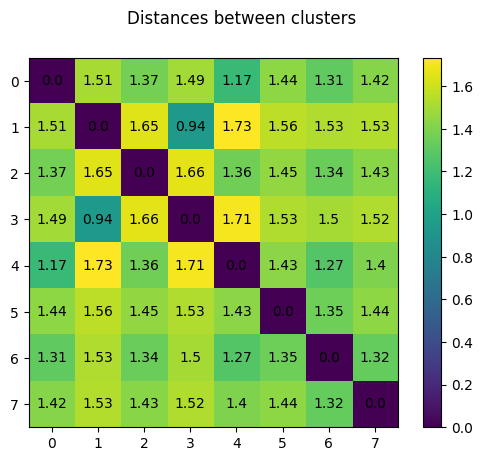

0
0.021884432
1
0.004432561
2
0.022827175
3
0.019013211
4
0.0051648626
5
0.02305474
6
0.10172812
7
0.0038121485
8
0.0101831425
9
0.019858658
10
0.0018206231
11
0.0028105553
12
0.027107166
13
0.018883647
14
0.0074602123
15
0.0043347017
16
0.0024291875
17
0.0011652743
18
0.018935814
19
0.00445794
20
0.0013589975
21
0.0077392617
22
0.006882584
23
0.016546104
24
0.036035486
25
0.008109367
26
0.045930315
27
0.11513009
28
0.05181504
29
GT: 1 Pred: 5
0.7252631
[5 5 5 5 5] Mean class:  5.0
5.0
[[5 5]]
30
0.106060885
31
0.0035721238
32
0.009516483
33
GT: 0 Pred: 6
0.052106284
[6 6 6 6 6] Mean class:  6.0
6.0
[[6 5]]
34
GT: 7 Pred: 1
0.115383595
[1 1 1 1 1] Mean class:  1.0
1.0
[[1 5]]
35
0.10470908
36
0.38906607
37
0.021387348
38
0.005237002
39
GT: 4 Pred: 1
0.62070376
[1 1 1 1 1] Mean class:  1.0
1.0
[[1 5]]
40
0.00031649697
41
0.008246303
42
0.10132439
43
0.0086602075
44
0.01442595
45
0.0046304446
46
0.032990016
47
0.035942324
48
0.0025723635
49
0.033308156
50
0.0036459318
51
0.004186478
52
0

<Figure size 640x480 with 0 Axes>

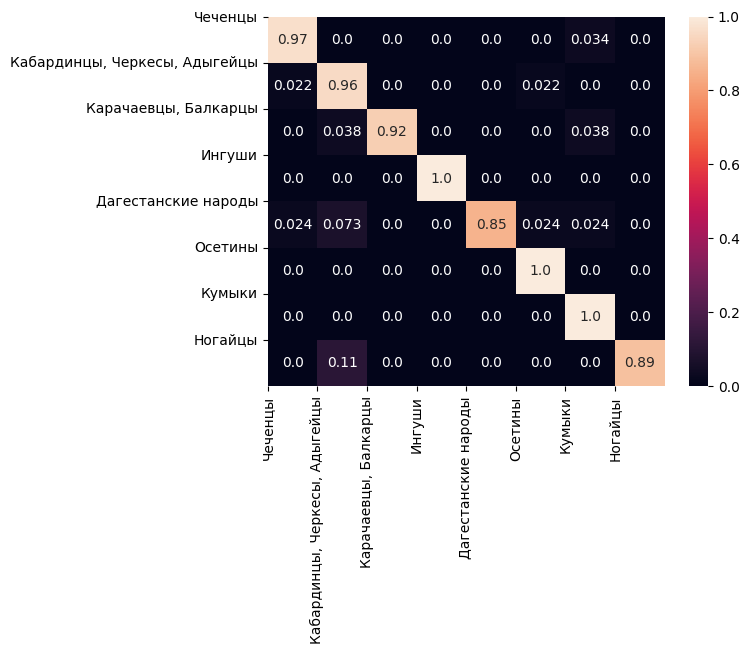

Accuracy: 179/188, exactly: 0.9521
MMD:  0.8044832


In [63]:
types = ['Чеченцы', 'Кабардинцы, Черкесы, Адыгейцы', 'Карачаевцы, Балкарцы', 'Ингуши', 'Дагестанские народы', 'Осетины', 'Кумыки', 'Ногайцы']
# types = ['Мордвины (21)', 'Белорусы (139)', 'Украинцы (128)', 'Южные-русские (654)', 'Северные-русские (190)']


# axis1 = 1
# axis2 = 120

# px = 1 / plt.rcParams['figure.dpi']
# plt.clf()
# fig, ax = plt.subplots(6, 2, figsize=(6400 * px, 6400 * px))

# tmp_train = []
# tmp_test = []
# for i in range(7):
#     for j, vec in enumerate(results_train):
#         if np.argmax(target_train[j]) == i:
#             tmp_train.append(vec)
#     tmp_train = np.array(tmp_train)
#     print(tmp_train.shape)
#     projection_train = np.stack((tmp_train[:, axis1], tmp_train[:, axis2]), axis=-1)
#     dots1 = ax[i % 6][i // 6].scatter(projection_train[:, 0], projection_train[:, 1], s=10, label='Train data')
#     tmp_train = []

#     for j, vec in enumerate(results_test):
#         if np.argmax(target_test[j]) == i:
#             tmp_test.append(vec)
#     tmp_test = np.array(tmp_test)
#     projection_test = np.stack((tmp_test[:, axis1], tmp_test[:, axis2]), axis=-1)
#     dots2 = ax[i % 6][i // 6].scatter(projection_test[:, 0], projection_test[:, 1], s=10, label='Test data')
#     tmp_test = []

#     ax[i % 6][i // 6].legend(handles=[dots1, dots2], fontsize=40)

# for i in range(7):
#     ax[i % 6][i // 6].set_title(f"Class {i + 1}", fontsize=40)

# fig.suptitle(f"Projection for axes {axis1} and {axis2}", fontsize=80)
# fig.savefig("projection.png")

# # projection = np.stack((results_train[:, 128], results_train[:, 988]), axis=-1)
# # print(projection.shape)
# # plt.clf()
# # plt.scatter(projection[:, 0], projection[:, 1], s=0.1)
# # plt.show()

clusters = np.zeros((len(types), 128))
tmp = []
for i in range(len(types)):
    for j, vec in enumerate(results_train):
        if np.argmax(target_train[j].squeeze()) == i:
            tmp.append(vec)
    tmp = np.array(tmp)
    clusters[i, :] = tmp.mean(axis=0)
    tmp = []

print(clusters)

dist = np.zeros((len(types), len(types)))
for i in range(11):
    for j in range(i + 1, len(types)):
        print(f"Distance between clusters {i} and {j} = {np.linalg.norm(clusters[i] - clusters[j])}")
        dist[i, j] = np.linalg.norm(clusters[i] - clusters[j])
        dist[j, i] = np.linalg.norm(clusters[i] - clusters[j])

plt.clf()
fig, ax = plt.subplots(1, 1)
img = ax.imshow(dist)
for (j, i), label in np.ndenumerate(dist):
    ax.text(i, j, round(label, 2), ha='center', va='center')
fig.colorbar(img)
fig.suptitle("Distances between clusters")
plt.show()
# plt.savefig("cluster_distances.png")

# tsne = TSNE(learning_rate=10, perplexity=10)
# embedded = tsne.fit_transform(results_train)
# print('New Shape of X: ', embedded.shape)
# print('Kullback-Leibler divergence after optimization: ', tsne.kl_divergence_)
# print('No. of iterations: ', tsne.n_iter_)
#
# plt.clf()
# fig, ax = plt.subplots(5, 2, figsize=(6400 * px, 6400 * px))
# for i in range(10):
#     for j, vec in enumerate(embedded):
#         if np.argmax(target_train[j].squeeze()) == i:
#             tmp_train.append(vec)
#     tmp_train = np.array(tmp_train)
#     dots = ax[i % 5][i // 5].scatter(tmp_train[:, 0], tmp_train[:, 1], s=10, label=f'Class {i}')
#     tmp_train = []
#     ax[i % 5][i // 5].legend(handles=[dots], fontsize=40)
#
# plt.savefig("New_clusters.png")

# print(target_test[0])
mmd = 0
ground_truth = []
predicted_labels = []
counter = 0
for i in range(len(results_test)):
    # for i, vec in enumerate(results_test):
    # if i % 100 == 0:
    print(i)
    vec = results_test[i]
    real = target_test[i]
    norm_arg = np.argmin(np.linalg.norm(vec - results_train, axis=1))
    # print(np.min(np.linalg.norm(vec - results_train, axis=1)))
    # norm_arg = np.argmin(np.linalg.norm(vec - clusters, axis=1))
    answer = target_train[norm_arg]
    if np.argmax(real.squeeze()) != np.argmax(answer.squeeze()):
        print(f'GT: {np.argmax(real.squeeze())}', f'Pred: {np.argmax(answer.squeeze())}')
        flagg = True
    else:
        flagg = False
    md = np.sort(np.linalg.norm(vec - results_train, axis=1))[0]
    print(md)
    class_list = np.argmax(target_train[np.argsort(np.linalg.norm(vec - results_train, axis=1))[:5]],
                           axis=-1).squeeze()
    if md > mmd:
        mmd = md
    if flagg:
        print(class_list, "Mean class: ", np.mean(class_list))
        print(np.round(np.mean(class_list)))
    # if np.abs(np.argmax(real.squeeze()) - np.argmax(answer.squeeze())) <= 1:
    ground_truth.append(np.argmax(real.squeeze()))
#     predicted_labels.append(int(np.round(np.mean(class_list))))

    uniq, cnts = np.unique(class_list, return_counts=True)
    u_l = np.asarray((uniq, cnts)).T
    u_l_as = np.argsort(u_l[:, 1])
    if flagg:
        print(u_l[u_l_as[::-1]])
    predicted_labels.append(u_l[u_l_as[::-1]][0, 0])
    
    if np.abs(np.argmax(real.squeeze()) - np.round(np.mean(class_list))) <= 1:
        counter += 1
        
print(classification_report(ground_truth, predicted_labels))
cm = confusion_matrix(ground_truth, predicted_labels, normalize='true')

final_f1_weighted_score = f1_score(ground_truth, predicted_labels, average='weighted')
final_f1_macro_score = f1_score(ground_truth, predicted_labels, average='macro')

print(f"Final f1 score weighted: {final_f1_weighted_score}")
print(f"Final f1 score macro: {final_f1_macro_score}")

plt.clf()
    
px = 1 / plt.rcParams['figure.dpi']

fig, ax = plt.subplots(1, 1)#figsize=(4000 * px, 4000 * px))
sns.heatmap(cm, annot=True, ax=ax, annot_kws={'size': 10}, fmt='.2')
ax.set_xticks([i for i in range(len(types))])
ax.set_xticklabels([f'{types[i]}' for i in range(0, len(types))])
ax.set_yticks([i for i in range(len(types))])
ax.set_yticklabels([f'{types[i]}' for i in range(0, len(types))])
# fig.suptitle(f"Confusion matrix, F1: {round(f1_score(ground_truth, predicted_labels, average='weighted'), 4)}")
plt.yticks(rotation=0)
plt.xticks(rotation=90) 
plt.savefig(f"cr_tripletloss_grant_ii.png", bbox_inches="tight")
plt.show()

print(f"Accuracy: {counter}/{len(results_test)}, exactly: {round(counter / len(results_test), 4)}")
# norm_arg = np.argmin(np.linalg.norm(results_test[0] - results_train, axis=1))
# print(target_train[norm_arg])
print('MMD: ', mmd)

# Making clusters (new)

In [97]:
all_results = np.concatenate([results_train, results_test], axis=0)
all_targets = np.argmax(np.concatenate([target_train, target_test], axis=0), axis=1)
all_predicted = np.concatenate([np.argmax(target_train, axis=1), predicted_labels], axis=0)

In [98]:
alpha_mask = [0.2 if i < len(results_train) else 1 for i in range(len(all_results))]
np.array(alpha_mask)

array([0.2, 0.2, 0.2, ..., 1. , 1. , 1. ])

In [41]:
predicted_labels

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 2,
 1,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 2,
 4,
 3,
 3,
 3,
 4,
 1,
 3,
 4,
 3,
 1,
 3,
 1,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 2,
 3,
 3,
 3,
 3,
 4,
 2,
 3,
 1,
 3,
 1,
 3,
 4,
 2,
 3,
 3,
 1,
 3,
 1,
 2,
 3,
 1,
 3,
 3,
 2,
 4,
 4,
 4,
 3,
 2,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 1,
 3,
 2,
 3,
 3,
 3,
 3,
 1,
 3,
 2,
 1,
 3,
 2,
 3,
 3,
 1,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 2,
 3,
 3,
 1,
 3,
 3,
 2,
 3,
 4,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 1,
 3,
 4,
 2,
 1,
 1,
 3,
 1,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 1,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 2,
 2,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 1,
 4,
 3,
 4,
 1,
 3,
 3,
 4,
 3,
 2,
 3,
 3,
 4,
 3,
 3,
 1,
 4,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 1,
 3,
 3,
 3,
 4,
 1,
 2,
 3,
 1,
 3,
 2,
 4,
 3,


In [99]:
all_results_2d = TSNE(n_components=2, learning_rate=1, init='random', perplexity=40).fit_transform(all_results)

In [40]:
import matplotlib
matplotlib.__version__

'3.7.2'

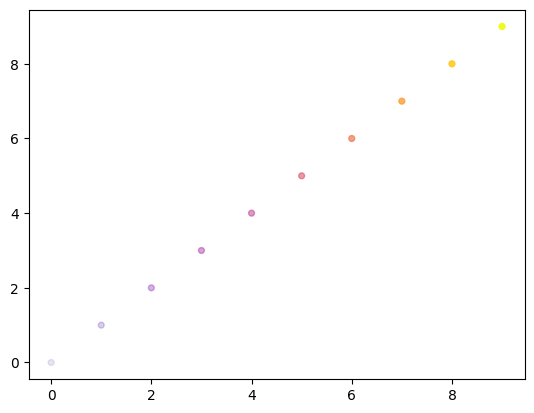

In [49]:
import numpy as np
import matplotlib.pylab as pplt

x = np.arange(10)
y = np.arange(10)

alphas = np.linspace(0.1, 1, 10)

fig, ax = pplt.subplots(1, 1)
ax.scatter(x, y, c=np.arange(10), s=18, cmap='plasma', alpha=alphas)
pplt.show()

C:\Users\Alex\AppData\Local\Temp\ipykernel_23456\1233063440.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', len(types))


<Figure size 640x480 with 0 Axes>

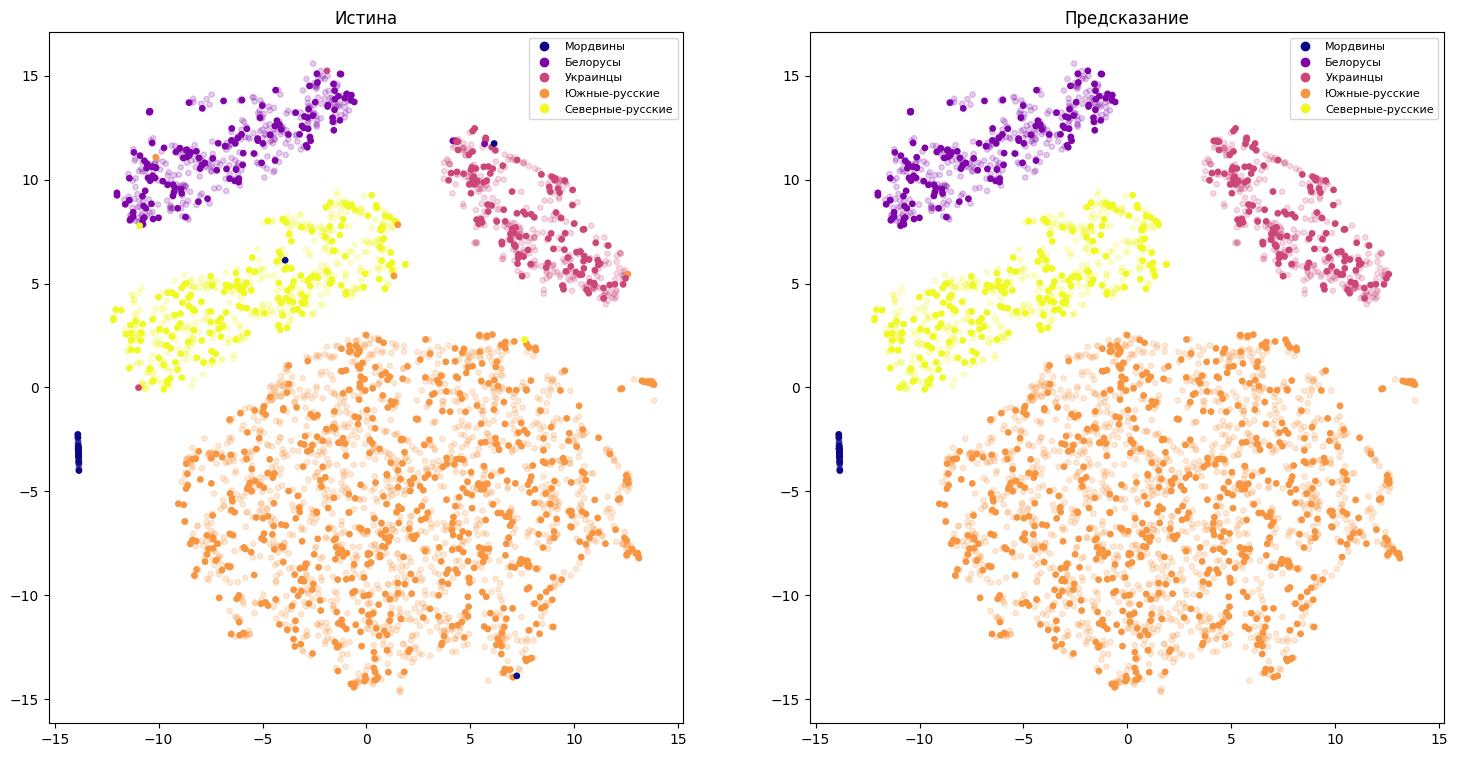

In [101]:
# check why it is clustering so good but prediction has an errors (done)

from pylab import *

types = ['Мордвины', 'Белорусы', 'Украинцы', 'Южные-русские', 'Северные-русские']

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

pplt.clf()
fig, (ax1, ax2) = pplt.subplots(1, 2, figsize=(18, 18))
# fig.suptitle('Horizontally stacked subplots')
ax1.set_title('Истина')
ax2.set_title('Предсказание')
ax1.set_aspect(1)
ax2.set_aspect(1)
a1s = ax1.scatter(*all_results_2d.T, c=all_targets, s=15, cmap='plasma', alpha=alpha_mask)
a2s = ax2.scatter(*all_results_2d.T, c=all_predicted, s=15, cmap='plasma', alpha=alpha_mask)
# ax1.legend(handles=a1s.legend_elements()[0], labels=types, fontsize=8)
# ax2.legend(handles=a2s.legend_elements()[0], labels=types, fontsize=8)

cmap = cm.get_cmap('plasma', len(types))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
legend_pics = []
for i in range(len(color_list)):
    lp = Line2D([0], [0], label=types[i], color=color_list[i], marker='o', ls="")
    legend_pics.append(lp)
    
ax1.legend(handles=legend_pics, fontsize=8)
ax2.legend(handles=legend_pics, fontsize=8)

pplt.savefig(f"cr_clusterization_comparison_grant_ii.png", bbox_inches="tight")
pplt.show()

## Partially clusterization

In [83]:
partial_idx = 97
all_results_partial = np.concatenate([results_train, np.expand_dims(results_test[partial_idx], axis=0)], axis=0)
all_targets_partial = np.argmax(np.concatenate([target_train, np.expand_dims(target_test[partial_idx], axis=0)], axis=0), axis=1)
all_predicted_partial = np.concatenate([np.argmax(target_train, axis=1), np.expand_dims(predicted_labels[partial_idx], axis=0)], axis=0)

In [84]:
all_results_2d_partial = TSNE(n_components=2, learning_rate=1, init='random', perplexity=40).fit_transform(all_results_partial)

In [92]:
alpha_mask_partial = [0.01 if i < len(results_train) else 1 for i in range(len(all_results_partial))]

C:\Users\Alex\AppData\Local\Temp\ipykernel_23456\3454995517.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', len(types))


<Figure size 640x480 with 0 Axes>

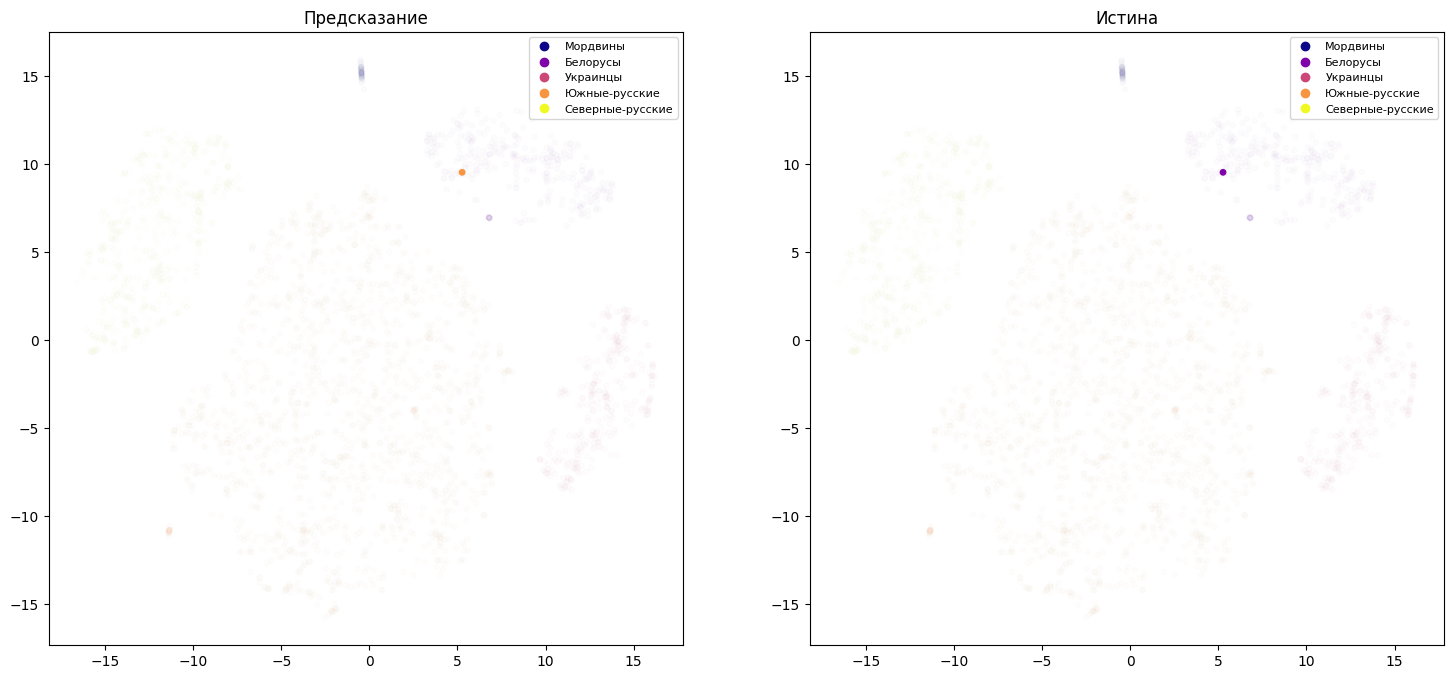

In [93]:
# check why it is clustering so good but prediction has an errors
from pylab import *

types = ['Мордвины', 'Белорусы', 'Украинцы', 'Южные-русские', 'Северные-русские']

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

pplt.clf()
fig, (ax1, ax2) = pplt.subplots(1, 2, figsize=(18, 18))
# fig.suptitle('Horizontally stacked subplots')
ax1.set_title('Предсказание')
ax2.set_title('Истина')
ax1.set_aspect(1)
ax2.set_aspect(1)
a1s = ax1.scatter(*all_results_2d_partial.T, c=all_targets_partial, s=15, cmap='plasma', alpha=alpha_mask_partial)
a2s = ax2.scatter(*all_results_2d_partial.T, c=all_predicted_partial, s=15, cmap='plasma', alpha=alpha_mask_partial)
# ax1.legend(handles=a1s.legend_elements()[0], labels=types, fontsize=8)
# ax2.legend(handles=a2s.legend_elements()[0], labels=types, fontsize=8)

cmap = cm.get_cmap('plasma', len(types))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
legend_pics = []
for i in range(len(color_list)):
    lp = Line2D([0], [0], label=types[i], color=color_list[i], marker='o', ls="")
    legend_pics.append(lp)
    
ax1.legend(handles=legend_pics, fontsize=8)
ax2.legend(handles=legend_pics, fontsize=8)

# pplt.savefig(f"cr_clusterization_comparison_grant_ii.png", bbox_inches="tight")
pplt.show()

[<matplotlib.collections.PathCollection object at 0x00000198E042E1C0>] ['Original Data']


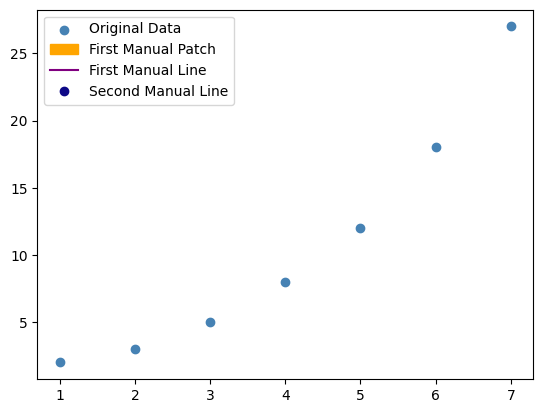

In [75]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

#define data to plot
x = [1, 2, 3, 4, 5, 6, 7]
y = [2, 3, 5, 8, 12, 18, 27]

#create scatter plot of x vs. y
plt.scatter(x, y, label='Original Data', color='steelblue')

#define handles and labels that will get added to legend
handles, labels = plt.gca().get_legend_handles_labels()

print(handles, labels)

#define patches and lines to add to legend
patch1 = mpatches.Patch(color='orange', label='First Manual Patch')
patch2 = mpatches.Patch(color='orange', label='First Manual Patch')   
line1 = Line2D([0], [0], label='First Manual Line', color='purple')
line2 = Line2D([0], [0], label='Second Manual Line', color='#0d0887', marker='o', ls="")

#add handles
handles.extend([patch1, line1, line2])

#add legend
plt.legend(handles=handles)

#display plot
plt.show()

In [74]:
from pylab import *

cmap = cm.get_cmap('seismic', 5)  # matplotlib color palette name, n colors
for i in range(cmap.N):
    rgb = cmap(i)[:3]  # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))

cmap = cm.get_cmap('plasma', 4)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
print(color_list)

#00004c
#0000ff
#ffffff
#ff0000
#800000
['#0d0887', '#9c179e', '#ed7953', '#f0f921']


C:\Users\Alex\AppData\Local\Temp\ipykernel_23456\1362246951.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('seismic', 5)  # matplotlib color palette name, n colors
C:\Users\Alex\AppData\Local\Temp\ipykernel_23456\1362246951.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', 4)


In [70]:
a = {tuple:'hello'}
a[tuple]

'hello'

# Making clusters (old)

In [472]:
from sklearn.manifold import TSNE

def evaluation(model, data, test_graphs):
    model.eval()

    embeddings_train = model(data.to(device)).cpu().detach().numpy()
    
    print(embeddings_train.shape)
    
    embeddings_test = []
    
    for k in range(len(test_graphs)):
        embeddings_test.append(model(test_graphs[k].to(device))[-1].cpu().detach().numpy())
        
    embeddings_test = np.array(embeddings_test)
    
    print(embeddings_test.shape)
    
    embeddings_total = np.concatenate([embeddings_train, embeddings_test], axis=0)
    
    tsne = TSNE(n_components=2, learning_rate=1, init='random', perplexity=40)
    
    tsne_embeddings = tsne.fit_transform(embeddings_total)
    
    axis1 = 1
    axis2 = 120
    
    plt.clf()
    plt.scatter(*tsne_embeddings[:426].T, label='train data', s=2)
    plt.scatter(*tsne_embeddings[426:].T, label='test data', s=2)
#     plt.scatter(embeddings[:, axis1], embeddings[:, axis2])
    plt.legend()
#     plt.savefig("nc_clustering_triplet.png", bbox_inches="tight")
    plt.show()

(426, 128)
(188, 128)


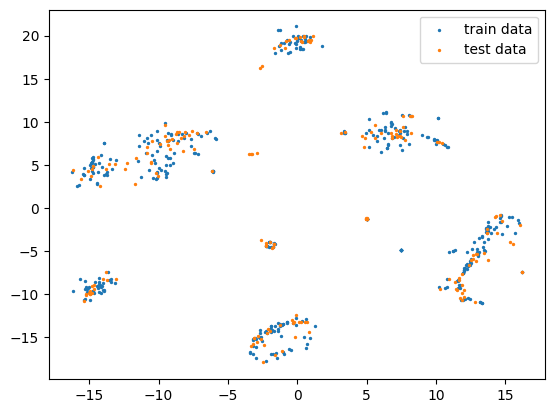

In [473]:
evaluation(model, data, test_graphs)

In [79]:
output = torch.rand(10, 128)
targets = torch.tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [80]:
tl = TripletSemiHardLoss()

In [81]:
tl(output, targets)

tensor(0.0207)

In [14]:
a = (1, 2)
b = (a, 3)
b

((1, 2), 3)

In [33]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
output = torch.cdist(input1, input2)

output.shape

torch.Size([100, 100])

In [61]:
x = tf.constant([[5, 4, 6], [5, 4, 6], [5, 4, 6]])
print(tf.size(x))
y = tf.reshape(tf.constant([5, 2, 5, 5, 2, 5, 5, 2, 5]), [-1, 1])
tf.math.greater(x, y)

tf.Tensor(9, shape=(), dtype=int32)


InvalidArgumentError: {{function_node __wrapped__Greater_device_/job:localhost/replica:0/task:0/device:GPU:0}} Incompatible shapes: [3,3] vs. [9,1]
	 [[{{node Greater}}]] [Op:Greater]

# Tensorflow TripletLoss vs Pytorch TripletLoss

In [12]:
import tensorflow as tf
from tensorflow_addons.losses import metric_learning
from tensorflow_addons.utils.keras_utils import LossFunctionWrapper
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from typeguard import typechecked
from typing import Optional, Union, Callable

In [104]:
def _masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = tf.math.reduce_min(data, dim, keepdims=True)
    masked_maximums = (
        tf.math.reduce_max(
            tf.math.multiply(data - axis_minimums, mask), dim, keepdims=True
        )
        + axis_minimums
    )
    return masked_maximums


def _masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = tf.math.reduce_max(data, dim, keepdims=True)
    masked_minimums = (
        tf.math.reduce_min(
            tf.math.multiply(data - axis_maximums, mask), dim, keepdims=True
        )
        + axis_maximums
    )
    return masked_minimums


def triplet_semihard_loss(
    y_true: TensorLike,
    y_pred: TensorLike,
    margin: FloatTensorLike = 0.2,
    distance_metric: Union[str, Callable] = "L2",
) -> tf.Tensor:
    r"""Computes the triplet loss with semi-hard negative mining.

    Usage:

    >>> y_true = tf.convert_to_tensor([0, 0])
    >>> y_pred = tf.convert_to_tensor([[0.0, 1.0], [1.0, 0.0]])
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric="L2")
    <tf.Tensor: shape=(), dtype=float32, numpy=2.4142137>

    >>> # Calling with callable `distance_metric`
    >>> distance_metric = lambda x: tf.linalg.matmul(x, x, transpose_b=True)
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric=distance_metric)
    <tf.Tensor: shape=(), dtype=float32, numpy=1.0>

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      distance_metric: `str` or a `Callable` that determines distance metric.
        Valid strings are "L2" for l2-norm distance,
        "squared-L2" for squared l2-norm distance,
        and "angular" for cosine similarity.

        A `Callable` should take a batch of embeddings as input and
        return the pairwise distance matrix.

    Returns:
      triplet_loss: float scalar with dtype of `y_pred`.
    """
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix

    if distance_metric == "L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=False
        )
        
#         tf.print(pdist_matrix)

    elif distance_metric == "squared-L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = metric_learning.angular_distance(precise_embeddings)

    else:
        pdist_matrix = distance_metric(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
#     tf.print(adjacency)
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)
#     tf.print(adjacency_not)

    batch_size = tf.size(labels)

    # Compute the mask.
    pdist_matrix_tile = tf.tile(pdist_matrix, [batch_size, 1])
#     tf.print(pdist_matrix_tile)
    
    mask = tf.math.logical_and(
        tf.tile(adjacency_not, [batch_size, 1]),
        tf.math.greater(
            pdist_matrix_tile, tf.reshape(tf.transpose(pdist_matrix), [-1, 1])
        ),
    )
#     tf.print(mask)
    mask_final = tf.reshape(
        tf.math.greater(
            tf.math.reduce_sum(
                tf.cast(mask, dtype=tf.dtypes.float32), 1, keepdims=True
            ),
            0.0,
        ),
        [batch_size, batch_size],
    )
#     tf.print(mask_final)
    
    mask_final = tf.transpose(mask_final)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    mask = tf.cast(mask, dtype=tf.dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = tf.reshape(
        _masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size]
    )
#     tf.print(negatives_outside)
    
    negatives_outside = tf.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = tf.tile(
        _masked_maximum(pdist_matrix, adjacency_not), [1, batch_size]
    )
#     tf.print(negatives_inside)
    semi_hard_negatives = tf.where(mask_final, negatives_outside, negatives_inside)
    
#     tf.print(semi_hard_negatives)

    loss_mat = tf.math.add(margin, pdist_matrix - semi_hard_negatives)
    
#     tf.print(loss_mat)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )
    
#     tf.print(mask_positives)

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = tf.math.reduce_sum(mask_positives)
    
#     tf.print(num_positives)

    triplet_loss = tf.math.truediv(
        tf.math.reduce_sum(
            tf.math.maximum(tf.math.multiply(loss_mat, mask_positives), 0.0)
        ),
        num_positives,
    )
    
#     tf.print(
#             tf.math.maximum(tf.math.multiply(loss_mat, mask_positives), 0.0)
#         )
    
#     tf.print(triplet_loss)

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss

In [18]:
test_array_x = np.random.random_sample((100, 128)).astype(np.float64)
test_array_y = np.array([0 for i in range(25)] + [1 for i in range(25)] + [2 for i in range(25)] + [3 for i in range(25)]).astype(np.float64)

In [105]:
with tf.device('CPU'):
    tf.print(triplet_semihard_loss(tf.cast(tf.convert_to_tensor(test_array_y), tf.float32), tf.cast(tf.convert_to_tensor(test_array_x), tf.float32)))

[[0 0.198365405 0.316806972 ... 0 0 0]
 [0.196273044 0 0.170718387 ... 0 0 0]
 [0.224508 0.178384498 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0.188140586 0.184802726]
 [0 0 0 ... 0.194748595 0 0.184892371]
 [0 0 0 ... 0.197816089 0.194497779 0]]
0.187194243


In [110]:
criterion = TripletSemiHardLoss()

In [111]:
criterion(torch.tensor(test_array_x).to('cuda'), torch.tensor(test_array_y).to('cuda'))

tensor([0.0000, 0.1984, 0.3168, 0.1888, 0.1955, 0.1829, 0.1981, 0.1858, 0.1992,
        0.1648, 0.1926, 0.1838, 0.1697, 0.1981, 0.1974, 0.1988, 0.1834, 0.1898,
        0.1936, 0.1844, 0.1909, 0.1806, 0.1921, 0.1692, 0.1999, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0', dtype=torch.float64)


tensor(0.1872, device='cuda:0', dtype=torch.float64)

Testing

In [62]:
model.eval()

Net(
  (conv1): GCNConv(5, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 5)
)

In [69]:
from sklearn.metrics import f1_score
y_true = []
y_pred = []

for i in range(len(test_graphs)):
    y_pred.append(np.argmax(F.softmax(model(test_graphs[i])[-1], dim=0).cpu().detach().numpy()))
    y_true.append(test_graphs[i].y[-1])
    
print(classification_report(y_true, y_pred))

print(confusion_matrix(y_true, y_pred))

print(f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.50      0.02      0.04        47
           2       0.83      0.12      0.20        43
           3       0.70      0.99      0.82       218
           4       0.89      0.78      0.83        64

    accuracy                           0.73       379
   macro avg       0.78      0.58      0.58       379
weighted avg       0.73      0.73      0.66       379

[[  7   0   0   0   0]
 [  0   1   1  43   2]
 [  0   0   5  36   2]
 [  0   1   0 215   2]
 [  0   0   0  14  50]]
0.6576256956227116


In [54]:
test_graphs[0].y

tensor([3, 3, 4,  ..., 1, 1, 3])

## Real example (old)

In [82]:
df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
n = pd.concat([df['node_id1'], df['node_id2']], axis=0)
l = pd.concat([df['label_id1'], df['label_id2']], axis=0)
df_new = pd.concat([n, l], axis=1)
df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
df_new = df_new.sort_values(by=[0])
df_new = df_new.drop_duplicates()
df_new.iloc[:, 1].to_numpy()

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [22]:
class MyDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(MyDataset, self).__init__('.', transform, None, None)

        df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
        
        types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()

        edge_index = torch.zeros((2, df.shape[0]), dtype=torch.long)
        edge_attr = torch.zeros((df.shape[0],), dtype=torch.float)
        
        n = pd.concat([df['node_id1'], df['node_id2']], axis=0)
        l = pd.concat([df['label_id1'], df['label_id2']], axis=0)
        df_new = pd.concat([n, l], axis=1)
        df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
        df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
        df_new = df_new.sort_values(by=[0])
        df_new = df_new.drop_duplicates()
        y = torch.from_numpy(df_new.iloc[:, 1].to_numpy()).type(torch.long)

        for i in range(df.shape[0]):
            edge_index[:, i] = torch.tensor([int(df.iloc[i, 0].split('_')[1]), int(df.iloc[i, 1].split('_')[1])])
            edge_attr[i] = df.iloc[i, 4]

        data = Data(edge_attr=edge_attr, edge_index=edge_index, y=y)
        
        print(data)
        
        data.num_nodes = len(pd.concat([df['node_id1'], df['node_id2']], axis=0).unique())
        
        data.num_classes = len(types)

#         # splitting the data into train, validation and test
#         X_train, X_test, y_train, y_test = train_test_split(edge_attr, 
#                                                             y,
#                                                             test_size=0.30, 
#                                                             random_state=42)
        
#         n_nodes = len(y)
        
#         # create train and test masks for data
#         train_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         test_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         train_mask[X_train.index] = True
#         test_mask[X_test.index] = True
#         data['train_mask'] = train_mask
#         data['test_mask'] = test_mask

#         self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)



dataset = MyDataset()
print(dataset)
data = dataset[0]

Data(edge_index=[2, 67503], edge_attr=[67503], y=[3767])
MyDataset()


In [34]:
df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
        
types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()

edge_index = torch.zeros((2, df.shape[0]), dtype=torch.long)
edge_attr = torch.zeros((df.shape[0],), dtype=torch.float)

n = pd.concat([df['node_id1'], df['node_id2']], axis=0)
l = pd.concat([df['label_id1'], df['label_id2']], axis=0)
df_new = pd.concat([n, l], axis=1)
df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
df_new = df_new.sort_values(by=[0])
df_new = df_new.drop_duplicates()
y = torch.from_numpy(df_new.iloc[:, 1].to_numpy()).type(torch.long)

for i in range(df.shape[0]):
    edge_index[:, i] = torch.tensor([int(df.iloc[i, 0].split('_')[1]), int(df.iloc[i, 1].split('_')[1])])
    edge_attr[i] = df.iloc[i, 4]

data = Data(x=torch.from_numpy(np.expand_dims(df_new.iloc[:, 1].to_numpy(), axis=-1)).type(torch.float), edge_attr=edge_attr, edge_index=edge_index, y=y)

data.num_nodes = len(pd.concat([df['node_id1'], df['node_id2']], axis=0).unique())
        
data.num_classes = len(types)

In [35]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, int(data.num_classes))

    def forward(self, edge_index):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =  data.to(device)

model = Net().to(device)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out= model(data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

for epoch in range(401):
    loss = train(data)
    print(loss)

tensor(2.1050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6992, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4440, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2880, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2498, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2172, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2153, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2449, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2385, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2469, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2266, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2168, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2021, device='cuda:0', grad_fn=

tensor(1.0949, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0961, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0999, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0951, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0966, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1005, device='cuda:0', grad_fn=

tensor(1.0863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0919, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0891, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0884, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0845, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0881, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0871, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0872, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0840, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0864, device='cuda:0', grad_fn=

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=2)
X, y = np.arange(18).reshape((6, 3)), [0, 0, 0, 0, 1, 1]

a, b = split.split(X, y)
X[a[0]]

array([[ 6,  7,  8],
       [ 9, 10, 11],
       [15, 16, 17]])

In [35]:
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
skf = StratifiedKFold(n_splits=3)

NameError: name 'StratifiedKFold' is not defined

In [18]:
edge_index.t().contiguous()

tensor([[   0,    5],
        [   0,   10],
        [   0,   11],
        ...,
        [3749, 3764],
        [3754, 3755],
        [3758, 3766]])

[How to get rbf_kernel_safe](https://stackoverflow.com/questions/52057836/labelpropagation-how-to-avoid-division-by-zero)

# NC

In [12]:
df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
df

node_id1   node_id2 label_id1 label_id2   ibd_sum  ibd_n
0         node_0     node_5  мордвины  мордвины  29.81720      4
1         node_0    node_10  мордвины  мордвины  11.63220      1
2         node_0    node_11  мордвины  мордвины  23.90440      2
3         node_0    node_18  мордвины  мордвины  11.25290      1
4         node_0    node_20  мордвины  мордвины   8.88252      1
...          ...        ...       ...       ...       ...    ...
67498  node_3741  node_3752  белорусы  белорусы   9.51327      1
67499  node_3745  node_3755  белорусы  белорусы   9.23221      1
67500  node_3749  node_3764  белорусы  белорусы  10.63310      1
67501  node_3754  node_3755  украинцы  белорусы   8.04722      1
67502  node_3758  node_3766  белорусы  белорусы   8.77936      1

[67503 rows x 6 columns]

In [13]:
len(pd.concat([df['node_id1'], df['node_id2']], axis=0).unique())

3767

## Get distribution

In [14]:
nodes_names = set()
all_types_dict = {}

types = df['label_id1'].unique().tolist()

for t in types:
    all_types_dict[t] = 0

for i, n in enumerate(df['node_id1']):
    if n not in nodes_names:
        nodes_names.add(n)
        all_types_dict[df['label_id1'][i]] += 1
        
for i, n in enumerate(df['node_id2']):
    if n not in nodes_names:
        nodes_names.add(n)
        all_types_dict[df['label_id2'][i]] += 1
        
print(all_types_dict)

{'мордвины': 70, 'белорусы': 463, 'украинцы': 426, 'южные-русские': 2177, 'северные-русские': 631}


## Training and results

              precision    recall  f1-score   support

           0       0.69      0.95      0.80        74
           1       0.87      0.67      0.76       111
           2       0.98      0.75      0.85        67
           3       1.00      0.43      0.60        42
           4       0.50      0.97      0.66        80
           5       0.94      0.42      0.59        40
           6       1.00      0.27      0.43        11
           7       0.78      0.41      0.54        17

    accuracy                           0.72       442
   macro avg       0.85      0.61      0.65       442
weighted avg       0.81      0.72      0.71       442

{'0': {'precision': 0.693069306930693, 'recall': 0.9459459459459459, 'f1-score': 0.8, 'support': 74}, '1': {'precision': 0.8705882352941177, 'recall': 0.6666666666666666, 'f1-score': 0.7551020408163265, 'support': 111}, '2': {'precision': 0.9803921568627451, 'recall': 0.746268656716418, 'f1-score': 0.847457627118644, 'support': 67}, '3': {'precisi

<Figure size 432x288 with 0 Axes>

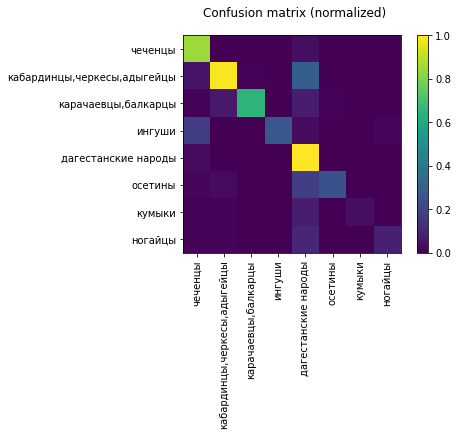

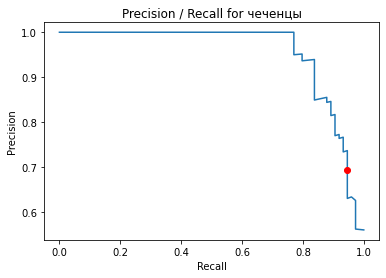

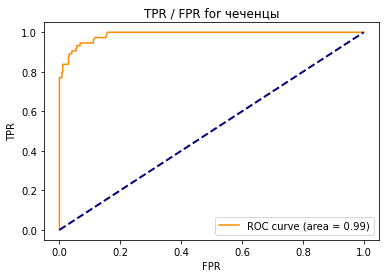

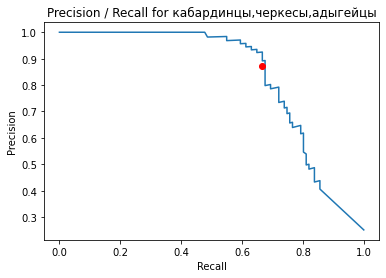

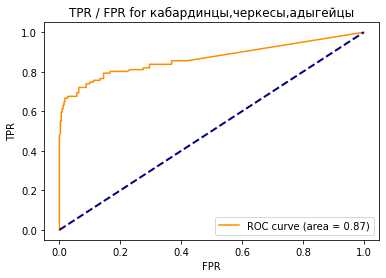

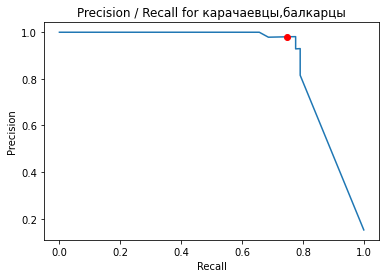

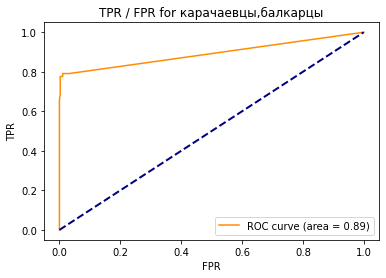

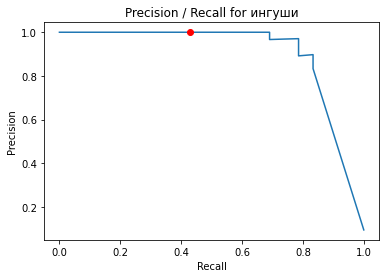

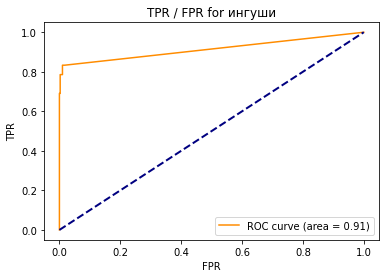

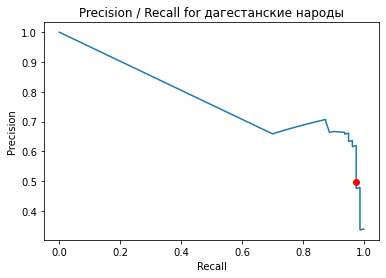

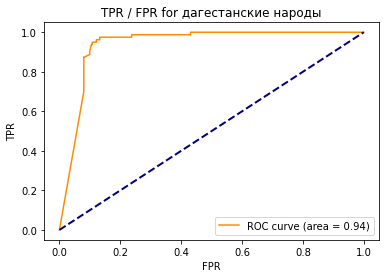

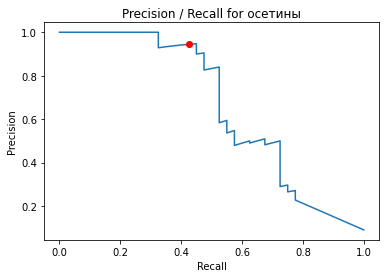

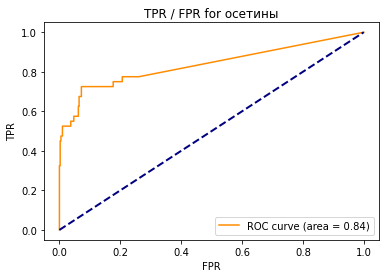

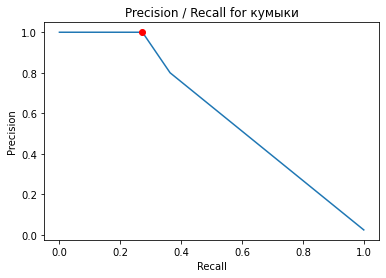

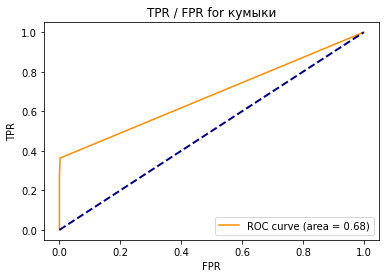

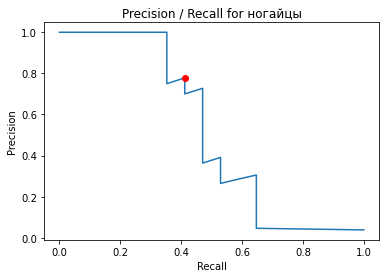

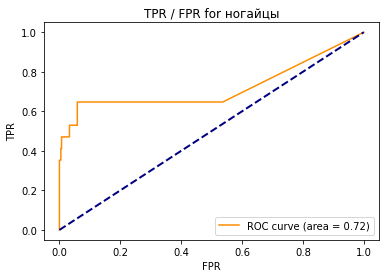

In [91]:
def get_dataset(df, cond):
    types = df['label_id1'].unique().tolist()
    types_dict = {}

    for t in types:
        types_dict[t] = 0

    current_types_dict = types_dict.copy()

    nodes_dict = {}
    
    for i, n in enumerate(df['node_id1']):
        if n in nodes_dict.keys():
            nodes_dict[n][0][df['label_id2'][i]] += df['ibd_sum'][i]
        else:
            if (current_types_dict[df['label_id1'][i]] + 1) / all_types_dict[df['label_id1'][i]] < cond:
                id_ = types.index(df['label_id1'][i])
                current_types_dict[df['label_id1'][i]] += 1
            else:
                id_ = -1
            nodes_dict[n] = [types_dict.copy(), id_]
        
    return nodes_dict

data = get_dataset(df, 0.2) # second number - the part of training data

inputs = [list(i[0].values()) for i in list(data.values())]
targets = [i[1] for i in list(data.values())]

def rbf_kernel_safe(X, Y=None, gamma=None): 

    X, Y = sklearn.metrics.pairwise.check_pairwise_arrays(X, Y) 
    if gamma is None: 
        gamma = 1.0 / X.shape[1] 

    K = sklearn.metrics.pairwise.euclidean_distances(X, Y, squared=True) 
    K *= -gamma 
    K -= K.max()
    np.exp(K, K)    # exponentiate K in-place 
    return K 

# label_prop_model = LabelSpreading(kernel=rbf_kernel_safe, max_iter=1000, tol=1e-3, n_jobs=-1, gamma=200)
label_prop_model = LabelSpreading(kernel='knn', max_iter=1000, tol=1e-3, n_jobs=-1, n_neighbors=11, gamma=100)
label_prop_model.fit(inputs, targets)
predicted = label_prop_model.predict(inputs)

unlabeled_targets = np.array(targets) == -1

data = get_dataset(df, 2) # second number - whatever number > 1 because we need to select all data

targets = np.array([i[1] for i in list(data.values())])

print(classification_report(targets[unlabeled_targets], predicted[unlabeled_targets]))
cr = classification_report(targets[unlabeled_targets], predicted[unlabeled_targets], output_dict=True)

cm = confusion_matrix(targets, predicted, labels=label_prop_model.classes_)
print(cm)

plt.clf()
fig, ax = plt.subplots(1, 1)
img = ax.imshow(cm/np.max(cm))
ax.set_xticks([i for i in range(8)])
ax.set_xticklabels(all_types_dict.keys(), rotation = 90)
ax.set_yticks([i for i in range(8)])
ax.set_yticklabels(all_types_dict.keys())
fig.colorbar(img)
fig.suptitle("Confusion matrix (normalized)")
plt.savefig(r"C:\HSE\genotek\cm_nc.png", bbox_inches="tight")
plt.show()

for i in range(8):
    fpr, tpr, _ = metrics.roc_curve(targets[unlabeled_targets],  label_prop_model.predict_proba(inputs)[:, i][unlabeled_targets], pos_label=i)
    pre, rec, _ = metrics.precision_recall_curve(targets[unlabeled_targets],  label_prop_model.predict_proba(inputs)[:, i][unlabeled_targets], pos_label=i)

    plt.clf()
    plt.title('Precision / Recall for ' + list(all_types_dict.keys())[i])
    plt.plot(rec, pre)
    plt.plot(cr[str(i)]['recall'], cr[str(i)]['precision'], 'ro')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.savefig(rf"C:\HSE\genotek\precision_recall_curves_{list(all_types_dict.keys())[i]}.png", bbox_inches="tight")
    plt.show()
    
    plt.clf()
    plt.title('TPR / FPR for ' + list(all_types_dict.keys())[i])
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr), color="darkorange")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.legend(loc="lower right")
    plt.savefig(rf"C:\HSE\genotek\roc_{list(all_types_dict.keys())[i]}.png", bbox_inches="tight")
    plt.show()